In [167]:
pip install cmap

python(15010) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 954.8/954.8 kB 39.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [77]:
%matplotlib inline
#import fleks,yt
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.cm import ScalarMappable
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from scipy import stats
import numpy as np
import os
import re
#from utilities import get_ticks
from matplotlib import cm, ticker
from cmap import Colormap
from os import listdir
from os.path import isfile, join
import glob
from PIL import Image
from natsort import natsorted
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy import interpolate
from matplotlib.ticker import LogFormatter 
from matplotlib.ticker import LogLocator, LogFormatterSciNotation 
import tecplot as tp
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from tecplot.exception import *
from tecplot.constant import *
import pandas as pd
from scipy.interpolate import griddata
from operator import add
from scipy.ndimage import label
import pickle
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
from scipy.ndimage import gaussian_filter
from matplotlib.ticker import LogLocator, MultipleLocator, LogFormatter, NullFormatter
from mpl_toolkits.mplot3d import axes3d
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.colors import LightSource
from scipy.ndimage import gaussian_filter1d
from matplotlib.colors import SymLogNorm


In [78]:
# Define Constants
amu = 1.67e-27
k_b = 1.38e-23
mu_0 = 1.257e-6
R_M = 2440e3 #m
m_p = 1.67e-27 # kg
e = 1.60218e-19 # C

# Define utility functions
def read_dataset(mypath):
    # Reads in file "mypath" and returns a dataset object. May take a while for larger files.

    print("reading:",mypath)
    # First connect to TecPlot
    tp.session.connect(port=7600)

    # Configure layout
    tp.new_layout()
    dataset = tp.data.load_tecplot(mypath)
    frame = tp.active_frame()
    frame.plot_type = PlotType.Cartesian3D

    # Return dataset
    return dataset

def Bz_dip(x_array,y_array,z_array):
    # Input: arrays of x,y,z (in planet centered coords).
    # Output: Bz at each point
    
    return - 200.9 * (3*(z_array-0.2)**2 - (x_array**2+y_array**2+(z_array-0.2)**2))/((x_array**2+y_array**2+(z_array-0.2)**2)**(5/2))

def extract_line(plane,line_start,line_end,num_points=200):
    # Input: 2d slice of domain (cannot be xz plane) format as a dictionary (like output from extract_values_fast), 
    # and the endpoints of a line to extract data for
    # Output: dictionary with same keys as the plane, but for data along the line
    
    # Define arrays for the line
    x_axis = np.linspace(line_start[0],line_end[0],num_points)
    y_axis = np.linspace(line_start[1],line_end[1],num_points)
    
    # Define empty arrays for each value stored in the plane dictionary
    out_dict = {}
    for key in plane.keys():
        out_dict[key]=np.zeros_like(x_axis)

    # Interpolate to points
    for key in plane.keys():
        out_dict[key] = griddata( (plane["X"].ravel(),plane["Y"].ravel()), plane[key].ravel(), (x_axis,y_axis))
    
    return out_dict

def get_files(dir, key=".*cut_particle_region0_0.*", read_time = False, reduce = True):
    # For a directory "dir", return a list of all files which match the regex expression "key"
    
    all_files = [f for f in listdir(dir) if isfile(join(dir, f))]
    files=[]
    for file in all_files:
        match = re.search(key,file)
        if match != None:
            files.append(file)
    files.sort()
    
    # Now give them the appropriate name for their time
    # If we haven't already named these files with their time, do that now
    named_files = {}
    if read_time == False:
        for i in range(len(files)):
            time = round(i*dt+start_time,3)
            named_files[time] = files[i]
    # Otherwise, read the time right from the (last 6 elements) filename
    else:
        for i in range(len(files)):
            time = str("%.2f"%float(files[i][-6:]))
            named_files[time] = files[i]        
    
    # Now cut the list down to files inside t_bound
    if reduce:
        reduced_files = {}
        for time in list(named_files.keys())[int((t_bound[0]-start_time)/dt):int((t_bound[1]-start_time)/dt)]: #only loop over the times within t_bound
            reduced_files[time] = str(named_files[time])
        return reduced_files

    else:
        return named_files

def convert_to_plt(dir,files):
    # Hand it a directory with the dict of files in it, and it will convert them to .plt and save in dir
    
    for file in files:
        dataset=read_dataset(str(dir+files[file]))
        print("saving file:",str(dir+files[file][:-3]+"plt"))
        tp.data.save_tecplot_plt(str(dir+files[file][:-3]+"plt"))

def extract_current_surface(path,var_ls=["Bz"],plot=True):
    # Input: the path to a .plt file, and a list of variables to extract for each point in current sheet
    # Output: a dictionary of arrays, each labelled according to its name in var_ls
    # Var_ls should be *extensive*, so that this long process does not need to be rerun
    
    # First, read in the dataset with tecplot
    dataset = read_dataset(path)

    # Extract the coordinate axes
    x_axis = np.unique(dataset.variable("X").values(0).as_numpy_array())
    y_axis = np.unique(dataset.variable("Y").values(0).as_numpy_array())[1:-1]
    z_axis = np.unique(dataset.variable("Z").values(0).as_numpy_array())

    # Create an ordered zone
    rect_zone = dataset.add_ordered_zone('rect_zone',[len(x_axis),len(y_axis-2),len(z_axis)])

    # Create 3D coordinate meshgrids
    xxx,yyy,zzz = np.meshgrid(x_axis,y_axis,z_axis)

    # Assign coordinate values to the rect_zone using the meshgrids
    rect_zone.values('X')[:] = xxx.ravel()
    rect_zone.values('Y')[:] = yyy.ravel()
    rect_zone.values('Z')[:] = zzz.ravel()

    # Compute derivatives in tecplot, which does it efficiently
    # Compute current density, in A/m^2
    if ("Jx" in var_ls) or ("Jy" in var_ls) or ("Jz" in var_ls):
        print("Computing J = ∇xB")
        tp.data.operate.execute_equation(equation='{Jx} = (ddy({Bz}) - ddz({By}))/(1.2566*10**(-6))/2440000*10**(-9)',
            ignore_divide_by_zero=True)
        tp.data.operate.execute_equation(equation='{Jy} = (ddz({Bx}) - ddx({Bz}))/(1.2566*10**(-6))/2440000*10**(-9)',
            ignore_divide_by_zero=True)
        tp.data.operate.execute_equation(equation='{Jz} = (ddx({By}) - ddy({Bx}))/(1.2566*10**(-6))/2440000*10**(-9)',
            ignore_divide_by_zero=True)

    # Compute plasma pressure gradient, in nPa / m
    if ("dp_dx" in var_ls) or ("dp_dy" in var_ls) or ("dp_dz" in var_ls):
        print("Computing ∇$p$")
        tp.data.operate.execute_equation(equation='{dp_dx} = (ddx({pxxS1}+{pxxS0}+{pyyS1}+{pyyS0}+{pzzS1}+{pzzS0}))/3/2440000',
        ignore_divide_by_zero=True)
        tp.data.operate.execute_equation(equation='{dp_dy} = (ddy({pxxS1}+{pxxS0}+{pyyS1}+{pyyS0}+{pzzS1}+{pzzS0}))/3/2440000',
            ignore_divide_by_zero=True)
        tp.data.operate.execute_equation(equation='{dp_dz} = (ddz({pxxS1}+{pxxS0}+{pyyS1}+{pyyS0}+{pzzS1}+{pzzS0}))/3/2440000',
            ignore_divide_by_zero=True)
        
    # Compute magnetic field gradient , in nT / m
    if ("dB_dx" in var_ls) or ("dB_dy" in var_ls) or ("dB_dz" in var_ls): 
        print("Computing ∇B")
        tp.data.operate.execute_equation(equation='{dB_dx} = (ddx(({Bx}*{Bx}+{By}*{By}+{Bz}*{Bz})**(0.5)))/2440000',
            ignore_divide_by_zero=True)
        tp.data.operate.execute_equation(equation='{dB_dy} = (ddy(({Bx}*{Bx}+{By}*{By}+{Bz}*{Bz})**(0.5)))/2440000',
            ignore_divide_by_zero=True)
        tp.data.operate.execute_equation(equation='{dB_dz} = (ddz(({Bx}*{Bx}+{By}*{By}+{Bz}*{Bz})**(0.5)))/2440000',
            ignore_divide_by_zero=True)

    print("Beginning interpolation...")
    # Interpolate onto rect_zone
    tp.data.operate.interpolate_linear(source_zones=[0],
        destination_zone=1,
        fill_value=0)

    # Calculate the plasma beta meshgrid
    beta_meshgrid = (2*mu_0*(rect_zone.values("pxxS0").as_numpy_array()+rect_zone.values("pyyS0").as_numpy_array()+rect_zone.values("pzzS0").as_numpy_array()+rect_zone.values("pxxS1").as_numpy_array()+
                            rect_zone.values("pyyS1").as_numpy_array()+rect_zone.values("pzzS1").as_numpy_array())*1e9/3/(rect_zone.values("Bx").as_numpy_array()**2+rect_zone.values("By").as_numpy_array()**2+rect_zone.values("Bz").as_numpy_array()**2)).reshape(xxx.shape)
    beta_meshgrid[np.isnan(beta_meshgrid)] = -1

    # Define dictionary to save results
    data = {"X":xxx[:,:,0],"Y":yyy[:,:,0]} #, "Z":np.zeros_like(xxx[:,:,0])}

    print("Interpolation complete, searching for max beta and saving data")
    
    # Interate through each x,y coord to find the max beta on that z-line and save the data
    '''
    for name in np.concatenate([["Z"],var_ls]):
        print("Extracting",name)
        data[name] = np.zeros_like(xxx[:,:,0])

        # Extract each variable from tecplot as an array
        var = rect_zone.values(name).as_numpy_array().reshape(xxx.shape)

        # At each x/y, find the z coord of max beta and save that
        for idy in range(len(yyy[:,0,0])):
            for idx in range(len(xxx[0,:,0])):
                # If any of the beta values in this column are -1 near the middle, that means we are at the inner edge of the bounding box
                # In this case, set the data value to 0 to let me know where the boundary is!
                if np.min(beta_meshgrid[idy,idx,len(z_axis)//4:-len(z_axis)//4]) == -1:
                    data[name][idy,idx] = 0
                else:
                    idz = np.argmax(beta_meshgrid[idy,idx,:])
                    data[name][idy,idx] = var[idy,idx,idz]
    '''
    # New code: extract all of the Z coords, smooth them, and then find the values interpolated to those points!
    print("Finding Z coords of current sheet")
    # Define empty array to save the unsmoothed Z values to
    Z_rough = np.zeros_like(xxx[:,:,0])
    # At each x/y, find the z coord of max beta and save that
    for idy in range(len(yyy[:,0,0])):
        for idx in range(len(xxx[0,:,0])):
            # If any of the beta values in this column are -1 near the middle, that means we are at the inner edge of the bounding box
            # In this case, set the data value to 0 to let me know where the boundary is!
            if np.min(beta_meshgrid[idy,idx,len(z_axis)//4:-len(z_axis)//4]) == -1:
                Z_rough[idy,idx] = 0
            else:
                idz = np.argmax(beta_meshgrid[idy,idx,:])
                Z_rough[idy,idx] = zzz[idy,idx,idz]

    # Smoothing parameter
    smoothing_param = 5
    # Smooth the Z meshgrid
    data['Z'] = smooth_meshgrid(xxx[:,:,0], yyy[:,:,0], Z_rough, smoothing_param)
    print("Z coords found!")

    # Use this as a template to extract all the other data with
    for name in var_ls:
        print("Extracting",name)
        data[name] = np.zeros_like(xxx[:,:,0])

        # Extract each variable from tecplot as an array
        var = rect_zone.values(name).as_numpy_array().reshape(xxx.shape)

        # At each x/y, find the z coord of max beta and save that
        for idy in range(len(yyy[:,0,0])):
            for idx in range(len(xxx[0,:,0])):
                # If any of the beta values in this column are -1 near the middle, that means we are at the inner edge of the bounding box
                # In this case, set the data value to 0 to let me know where the boundary is!
                if np.min(beta_meshgrid[idy,idx,len(z_axis)//4:-len(z_axis)//4]) == -1:
                    data[name][idy,idx] = 0
                else:
                    # Find the indices of the two nearest points
                    lower_idz = np.searchsorted(zzz[idy,idx,:], data['Z'][idy,idx]) - 1
                    upper_idz = lower_idz + 1

                    # Get the coordinates of the nearest points
                    Z_lower = zzz[idy,idx,lower_idz]
                    Z_upper = zzz[idy,idx,upper_idz]
                    var_lower = var[idy,idx,lower_idz]
                    var_upper = var[idy,idx,upper_idz]
                    
                    # Perform linear interpolation
                    data[name][idy,idx] = var_lower + (var_upper - var_lower) * (data['Z'][idy,idx] - Z_lower) / (Z_upper - Z_lower)

    print("Complete!")

    if plot:
        fig, ax = plt.subplots(ncols=2,figsize=(16,5))

        # Unpack variables
        X = data["X"]
        Y = data["Y"]
        Z = data["Z"]
        Bz = data["Bz"]
    
        # Plot left view
        inner = plt.Circle((0, 0), 0.8, color='black')
        outer = plt.Circle((0, 0), 1, color='grey')
    
        xlims = [-3,-0.5]
        ylims = [-0.75,0.75]
        xz_plot = ax[0].scatter(X[::-1,::-1], Z[::-1,::-1], c = Y[::-1,::-1], vmin=-1,vmax=1, cmap='bwr',alpha=0.5)
    
        x_major_ticks = np.arange(xlims[0], xlims[1], 0.25)
        x_minor_ticks = np.arange(xlims[0], xlims[1], 0.05)
        y_major_ticks = np.arange(ylims[0], ylims[1], 0.25)
        y_minor_ticks = np.arange(ylims[0], ylims[1], 0.05)
    
        ax[0].set_xticks(x_major_ticks)
        ax[0].set_xticks(x_minor_ticks, minor=True)
        ax[0].set_yticks(y_major_ticks)
        ax[0].set_yticks(y_minor_ticks, minor=True)
    
        ax[0].grid(which='both')
        ax[0].grid(which='minor', alpha=0.2)
        ax[0].grid(which='major', alpha=0.5)
        
        #ticks = get_ticks(vmin, vmax)
        clb1 = fig.colorbar(xz_plot, ax=ax[0]) 
        clb1.ax.tick_params(labelsize=8)
        clb1.ax.set_title('$Y$ [$R_M$]',fontsize=12)
        ax[0].set_aspect(1) # you may also use am.imshow(..., aspect="auto") to restore the aspect ratio
        ax[0].set_xlabel("X [$R_M$]")
        ax[0].set_ylabel("Z [$R_M$]")
        ax[0].add_patch(outer)
        ax[0].add_patch(inner)
        ax[0].set_xlim(xlims)
        ax[0].set_ylim(ylims)
        ax[0].set_title(str("Current sheet in XZ plane at t="+"%.2f"%round(time,2)+"s"))
    
        # Plot right view
        inner = plt.Circle((0, 0), 0.8, color='black')
        outer = plt.Circle((0, 0), 1, color='grey')
    
        vmin = -0.5
        vmax = 0.5
        nlevels = 23 
        levels = np.linspace(vmin, vmax, nlevels)
        xy_plot = ax[1].contourf(X, Y, (Z-0.2), levels=levels, cmap='bwr')
    
        ax[1].set_xticks(x_major_ticks)
        ax[1].set_xticks(x_minor_ticks, minor=True)
        ax[1].set_yticks(y_major_ticks)
        ax[1].set_yticks(y_minor_ticks, minor=True)
    
        ax[1].grid(which='both')
        ax[1].grid(which='minor', alpha=0.2)
        ax[1].grid(which='major', alpha=0.5)
        
        #ticks = get_ticks(vmin, vmax)
        clb2 = fig.colorbar(xy_plot, ax=ax[1]) 
        clb2.ax.tick_params(labelsize=8)
        clb2.ax.set_title('$(Z-0.2)$ [$R_M$]',fontsize=12)
        ax[1].set_aspect(1) # you may also use am.imshow(..., aspect="auto") to restore the aspect ratio
        ax[1].set_xlabel("X [$R_M$]")
        ax[1].set_ylabel("Y [$R_M$]")
        ax[1].add_patch(outer)
        ax[1].add_patch(inner)
        ax[1].set_xlim(xlims)
        ax[1].set_ylim(ylims)
        ax[1].set_title(str("Current sheet in XY plane at t="+"%.2f"%round(time,2)+"s"))
    
        # Save
        fig.savefig(str(str(dir[:-1])+"_plots/current_sheet_"+"%.2f"%round(time,2)+'.png'),bbox_inches='tight')
        plt.close(fig)
    
    return data
'''
def find_current_sheet2D(dataset):
    # This fits the current sheet using a 2D plane, fit to max plasma beta
    # Function hyperparameters
    x_fit_min = -2.5 # Sets the maximum x range to use for fitting a straight line to the beta profile
    x_fit_max = -1.5
    x_plane_coord = -1.75 # Sets the x-value for the yz plane (the xz plane is taken at y=0)
    y_fit_min = -1 # Sets the maximum y range to use for fitting a straight line to the beta profile
    y_fit_max = 1
    
    # First, determine the dz/dx and x_intercept (ie z(x=0)) of the current sheet by looking in the xz plane
    xz_plane = extract_values_fast(dataset,var_ls=["Bx","By","Bz","pxxS0","pyyS0","pzzS0","pxxS1","pyyS1","pzzS1"],origin=[0,0,0],normal=[0,-1,0])
    
    # Extract values
    x = xz_plane["XX"][0,:]
    z = xz_plane["ZZ"][:,0]
    
    # Compute beta using electron pressure tensor
    xz_beta = 2*mu_0*(xz_plane["pxxS0"]+xz_plane["pyyS0"]+xz_plane["pzzS0"]+xz_plane["pxxS1"]+xz_plane["pyyS1"]+xz_plane["pzzS1"])*1e9/3/(xz_plane["Bx"]**2+xz_plane["By"]**2+xz_plane["Bz"]**2)
    xz_beta[np.isnan(xz_beta)] = 0
    
    # Find line-of-best-fit for region -3<x<-1.2
    x_cs = x[x>x_fit_min] # First, get x array
    x_cs = x_cs[x_cs<x_fit_max]
    y_cs = np.zeros_like(x_cs) # Declare empty y array, which will be used to save y value of current layer center
    for i in range(len(x_cs)): # Iterate over each x bin
        # Get the x index for this bin
        xi = np.where(x == x_cs[i])
        # Fit a gaussian to each y / Jy profile, and extract the y coord of the max
        #try:
        #    coeff, var_matrix = curve_fit(gauss, z, xz_beta[:,xi].flatten()/np.max(xz_beta[:,xi].flatten()), p0=[1.,0.2,0.05])
        #    fit = gauss(z, *coeff)
        #    y_cs[i] = z[np.argmax(fit)]
        #except RuntimeError:
        #    print("Error - curve_fit failed, using max value instead")
        y_cs[i] = z[np.argmax(xz_beta[:,xi].flatten())]
    dz_dx, x_intercept, r_value, p_value, std_err = stats.linregress(x_cs,y_cs)
    
    # Then, repeat for dz/dy and y_intercept (ie z(y=0) in the yz plane
    yz_plane = extract_values_fast(dataset,var_ls=["Bx","By","Bz","pxxS0","pyyS0","pzzS0","pxxS1","pyyS1","pzzS1"],origin=[x_plane_coord,0,0],normal=[1,0,0])
    
    # Extract values
    y = yz_plane["YY"][0,:]
    z = yz_plane["ZZ"][:,0]
    
    # Compute beta using electron pressure tensor
    yz_beta = 2*mu_0*(yz_plane["pxxS0"]+yz_plane["pyyS0"]+yz_plane["pzzS0"]+yz_plane["pxxS1"]+yz_plane["pyyS1"]+yz_plane["pzzS1"])*1e9/3/(yz_plane["Bx"]**2+yz_plane["By"]**2+yz_plane["Bz"]**2)
    yz_beta[np.isnan(yz_beta)] = 0
    
    # Find line-of-best-fit for region -3<x<-1.2
    y_cs = y[y>y_fit_min] # First, get x array
    y_cs = y_cs[y_cs<y_fit_max]
    z_cs = np.zeros_like(y_cs) # Declare empty y array, which will be used to save y value of current layer center
    for i in range(len(y_cs)): # Iterate over each x bin
        yi = np.where(y == y_cs[i])
        #plt.scatter(z, yz_beta[:,yi].flatten()/np.max(yz_beta[:,yi].flatten()))
        #plt.plot(z, gauss(z, *[1.,0.22,0.02]))
        #plt.show()
        try:
            coeff, var_matrix = curve_fit(gauss, z, yz_beta[:,yi].flatten()/np.max(yz_beta[:,yi].flatten()), p0=[1.,0.22,0.02])
            fit = gauss(z, *coeff)
            z_cs[i] = z[np.argmax(fit)]
        except RuntimeError:
            print("Error - curve_fit failed, using max value instead")
            z_cs[i] = z[np.argmax(yz_beta[:,yi].flatten())]
    dz_dy, y_intercept, r_value, p_value, std_err = stats.linregress(y_cs,z_cs)
    
    return [x_plane_coord, 0, y_intercept], [-dz_dx,-dz_dy,1]

def extract_values_fast(dataset,var_ls=["rhoS1"],origin=[0,0,0],normal=[0,1,0]):
    # Combines the functionality of extract_values and cast_to_grid, and hopefully is a lot faster

    # Configure the slice of interest
    plot = tp.active_frame().plot()
    slice = plot.slice(0)
    slice.orientation = SliceSurface.Arbitrary
    slice.arbitrary_normal = normal
    slice.origin = origin
    slice_zone = plot.slice(0).extract()
    
    # Find the axes for our slice
    x_axis = np.unique(slice_zone.values("X").as_numpy_array())
    y_axis = np.unique(slice_zone.values("Y").as_numpy_array())
    z_axis = np.unique(slice_zone.values("Z").as_numpy_array())

    # Hotfix flag to slice of problematic data (seems to be true in all cases)
    slice_fix = False

    # Determine what kind of plane we have, and define appropriate coordinate meshgrids
    if len(y_axis) == 1: # xz plane case
        # For some mysterious reason, this case results in errors in the bottom (lowest z) two rows
        # This never happened before, and must be to do with a glitch in tecplot to do with interpolation etc
        # We just slice off the problematic data, I guess
        xx,zz = np.meshgrid(x_axis,z_axis)
        yy = np.zeros_like(zz)+y_axis.item()
        rect_zone = dataset.add_ordered_zone('rect_zone',[len(x_axis),len(z_axis)])
        slice_fix=True
    elif len(z_axis) == 1: # xy plane case
        xx,yy = np.meshgrid(x_axis,y_axis)
        zz = np.zeros_like(yy)+z_axis.item()
        rect_zone = dataset.add_ordered_zone('rect_zone',[len(x_axis),len(y_axis)])
    elif len(x_axis) == 1: #yz plane case
        yy,zz = np.meshgrid(y_axis,z_axis)
        xx = np.zeros_like(yy)+x_axis.item()
        rect_zone = dataset.add_ordered_zone('rect_zone',[len(y_axis),len(z_axis)])
    else: #general case
        xx,yy = np.meshgrid(x_axis,y_axis)
        zz = -normal[0]/normal[2]*(xx-origin[0])-normal[1]/normal[2]*(yy-origin[1])+origin[2]
        rect_zone = dataset.add_ordered_zone('rect_zone',[len(x_axis),len(y_axis)])
    
    # Cast the coordinates onto the zone
    rect_zone.values('X')[:] = xx.ravel()
    rect_zone.values('Y')[:] = yy.ravel()
    rect_zone.values('Z')[:] = zz.ravel()
    
    # Compute derivatives in tecplot, which does it efficiently
    # Compute current density, in A/m^2
    if ("Jx" in var_ls) or ("Jy" in var_ls) or ("Jz" in var_ls):
        print("Computing J = ∇xB")
        tp.data.operate.execute_equation(equation='{Jx} = (ddy({Bz}) - ddz({By}))/(1.2566*10**(-6))/2440000*10**(-9)',
            ignore_divide_by_zero=True)
        tp.data.operate.execute_equation(equation='{Jy} = (ddz({Bx}) - ddx({Bz}))/(1.2566*10**(-6))/2440000*10**(-9)',
            ignore_divide_by_zero=True)
        tp.data.operate.execute_equation(equation='{Jz} = (ddx({By}) - ddy({Bx}))/(1.2566*10**(-6))/2440000*10**(-9)',
            ignore_divide_by_zero=True)

    # Compute plasma pressure gradient, in nPa / m
    if ("dp_dx" in var_ls) or ("dp_dy" in var_ls) or ("dp_dz" in var_ls):
        print("Computing ∇$p$")
        tp.data.operate.execute_equation(equation='{dp_dx} = (ddx({pxxS1}+{pxxS0}+{pyyS1}+{pyyS0}+{pzzS1}+{pzzS0}))/3/2440000',
        ignore_divide_by_zero=True)
        tp.data.operate.execute_equation(equation='{dp_dy} = (ddy({pxxS1}+{pxxS0}+{pyyS1}+{pyyS0}+{pzzS1}+{pzzS0}))/3/2440000',
            ignore_divide_by_zero=True)
        tp.data.operate.execute_equation(equation='{dp_dz} = (ddz({pxxS1}+{pxxS0}+{pyyS1}+{pyyS0}+{pzzS1}+{pzzS0}))/3/2440000',
            ignore_divide_by_zero=True)
        
    # Compute magnetic field gradient , in nT / m
    if ("dB_dx" in var_ls) or ("dB_dy" in var_ls) or ("dB_dz" in var_ls): 
        print("Computing ∇B")
        tp.data.operate.execute_equation(equation='{dB_dx} = (ddx(({Bx}*{Bx}+{By}*{By}+{Bz}*{Bz})**(0.5)))/2440000',
            ignore_divide_by_zero=True)
        tp.data.operate.execute_equation(equation='{dB_dy} = (ddy(({Bx}*{Bx}+{By}*{By}+{Bz}*{Bz})**(0.5)))/2440000',
            ignore_divide_by_zero=True)
        tp.data.operate.execute_equation(equation='{dB_dz} = (ddz(({Bx}*{Bx}+{By}*{By}+{Bz}*{Bz})**(0.5)))/2440000',
            ignore_divide_by_zero=True)
        
    print("Beginning interpolation...")
    # Interpolate onto rect_zone
    tp.data.operate.interpolate_linear(source_zones=[0],
        destination_zone=1,
        fill_value=0)
    
    # Define output dictionary
    if slice_fix:
        out_dict = {'XX':xx[2:,:],'YY':yy[2:,:],'ZZ':zz[2:,:]}
    else:
        out_dict = {'XX':xx,'YY':yy,'ZZ':zz}
    
    # Reshape data for each variable and save in dictionary
    for var in var_ls:
        if slice_fix:
            out_dict[var] = rect_zone.values(var).as_numpy_array().reshape(xx.shape)[2:,:]       
        else:
            out_dict[var] = rect_zone.values(var).as_numpy_array().reshape(xx.shape)

    # Clear up tecplot zones
    tp.active_frame().dataset.delete_zones([1])
    tp.active_frame().dataset.delete_zones([1])

    return out_dict
'''
def average_value(var_ls,t0,t_start,t_stop,type='csdata'):
    # Input: Variables to average, the current time (t0), and the times relative to present to average over (t0+t_start to t0+t_stop)
    # Ouput: dictionary of arrays of time-averaged values

    averages = {}
    count = 0

    temp_files = get_files(dir,key="3d\_fluid.*"+type+"\_t\_...\...",read_time = True, reduce = False)

    for t in list(temp_files.keys()): 
        # Check to see if this file is in the time range we want
        if (float(t) >= (t0+t_start)) and (float(t) <= t0+t_stop):
            temp_file = str(temp_files[t])
    
            # Read in this data
            with open(dir+temp_file, 'rb') as f:
                temp_data = pickle.load(f) 
            
            # Add the data to our running average for each variable
            for var in var_ls:
                if var not in averages.keys():
                    averages[var] = temp_data[var]
                else:
                    averages[var] += temp_data[var]

            count += 1
        
    # Divide by total time steps
    for var in var_ls:
        averages[var] = averages[var]/count

    return averages

def compute_dt(var_ls,time):
    # Input: variables to compute the time derivative for, and the current time
    # Output: dictionary of time derivatives for each variable, calculated as dvar_dt = var(time+dt)-var(time-dt)/(2*dt)
    # If earlier or later times are not available, we do either var(time+dt)-var(time)/dt or var(time)-var(time-dt)/dt

    # Declare output dictionary
    deriv_dict = {}
    print("Computing time derivatives at time",time)
    key_minus = '{:.2f}'.format((float(time)-dt), 'wb')
    key_plus = '{:.2f}'.format((float(time)+dt), 'wb')
    #print(files.keys())
    #print(key_minus)
    #print(key_plus)

    # Read in the data depending on whether its available
    if (key_minus in files.keys()) and (key_plus in files.keys()):
        # Case one: earlier and later timestep available, so use both
        print("Earlier and later timesteps available!")
        with open(dir+files[key_minus], 'rb') as f:
            data_tminus = pickle.load(f) 
        with open(dir+files[key_plus], 'rb') as f:
            data_tplus = pickle.load(f) 
        for var in var_ls:
            deriv_dict[var] = (data_tplus[var]-data_tminus[var])/(2*dt)
    
    elif (key_minus in files.keys()):
        # Case two: only earlier time available
        print("Only earlier timestep available!")
        with open(dir+files[key_minus], 'rb') as f:
            data_tminus = pickle.load(f) 
        for var in var_ls:
            deriv_dict[var] = (data[var]-data_tminus[var])/(dt)

    elif (key_plus in files.keys()):
        # Case three: only later time available
        print("Only later timestep available!")
        print(dir+files[key_plus])
        with open(dir+files[key_plus], 'rb') as f:
            data_tplus = pickle.load(f) 
        for var in var_ls:
            deriv_dict[var] = (data_tplus[var]-data[var])/(dt)

    else:
        print("ERROR: NO OTHER TIMESTEPS FOUND FOR DERIVATIVE")
            
    return deriv_dict

def smooth_meshgrid(X, Y, Z, smoothing_param):
    """
    Smooth the Z values of a meshgrid defined by X, Y coordinates using a Gaussian filter.
    
    Parameters:
    X (2D numpy array): The X coordinates of the meshgrid.
    Y (2D numpy array): The Y coordinates of the meshgrid.
    Z (2D numpy array): The Z coordinates of the meshgrid.
    smoothing_param (float): The standard deviation for the Gaussian kernel, controlling the smoothing.
    
    Returns:
    Z_smoothed (2D numpy array): The smoothed Z values of the meshgrid.
    """
    # Check if X, Y, Z are of the same shape
    if X.shape != Y.shape or X.shape != Z.shape:
        raise ValueError("X, Y, and Z meshgrids must have the same shape")
    
    # Apply Gaussian filter to the Z meshgrid
    Z_smoothed = gaussian_filter(Z, sigma=smoothing_param)
    
    return Z_smoothed

def set_axes_equal(ax):
            '''Make axes of 3D plot have equal scale so that spheres appear as spheres,
            cubes as cubes, etc..  Works with ax.plot_surface, ax.scatter, etc..'''
            
            x_limits = ax.get_xlim3d()
            y_limits = ax.get_ylim3d()
            z_limits = ax.get_zlim3d()
        
            x_range = abs(x_limits[1] - x_limits[0])
            y_range = abs(y_limits[1] - y_limits[0])
            z_range = abs(z_limits[1] - z_limits[0])
        
            max_range = max(x_range, y_range, z_range)
        
            x_middle = np.mean(x_limits)
            y_middle = np.mean(y_limits)
            z_middle = np.mean(z_limits)
        
            ax.set_xlim3d([x_middle - max_range/2, x_middle + max_range/2])
            ax.set_ylim3d([y_middle - max_range/2, y_middle + max_range/2])
            ax.set_zlim3d([z_middle - max_range/2, z_middle + max_range/2])
    

In [7]:
# STEP ONE: process data
dir = "/Users/atcushen/Documents/MercuryModelling/runs/nightside_v4_run1/ta-4e/" #   # Directory with data 
start_time = 70                                              # What is the start time of the dataset?
t_bound = [76.5,90] #70,107                                                   # Start and stop times of this data to be processed
dt = 0.05                                                     # What is the timestep between files?
convert_first = False # Set to true to make sure files are converted from .dat to .plt. Set to false if there are .dat files in the directory which do not need to be converted
current_sheet_fit_mode = 'curved'

var_ls = ["Bx","By","Bz","Ex","Ey","Ez","rhoS0","uxS0","uyS0","uzS0","pxxS0","pyyS0","pzzS0","pxyS0","pxzS0","pyzS0",
          "rhoS1","uxS1","uyS1","uzS1","pxxS1","pyyS1","pzzS1","pxyS1","pxzS1","pyzS1","Jx","Jy","Jz","dp_dx","dp_dy","dp_dz",
          "dB_dx","dB_dy","dB_dz"]


# RUN
if convert_first:
    files = get_files(dir,key="3d\_fluid.*\.dat")
    convert_to_plt(dir,files)

files = get_files(dir,key="3d\_fluid.*\.plt")

for time in list(files.keys()): 
    print("Extracting data for t =",time)
    file = str(files[time])

    if current_sheet_fit_mode == 'plane' or current_sheet_fit_mode == 'both':
        dataset = read_dataset(dir+file)
        # Find current sheet
        origin,normal = find_current_sheet2D(dataset)
        # Slice out current sheet
        data = extract_values_fast(dataset,var_ls=var_ls,origin=origin,normal=normal)
        print("Extraction complete! Saving...")
        save_file = open(str(dir+file[:-4]+"_csplanedata_t_"+'{:06.2f}'.format(round(time,2))), 'wb') 
        pickle.dump(data, save_file) 
        
    elif current_sheet_fit_mode == 'curved' or current_sheet_fit_mode == 'both':
        data = extract_current_surface(dir+file,var_ls=var_ls)
        print("Extraction complete! Saving...")
        save_file = open(str(dir+file[:-4]+"_csdata_t_"+'{:06.2f}'.format(round(time,2))), 'wb') 
        pickle.dump(data, save_file) 
    

Extracting data for t = 76.5
reading: /Users/atcushen/Documents/MercuryModelling/runs/nightside_v4_run1/ta-4e/3d_fluid_region0_0_t00000116_n00035299_amrex.plt
Connecting to Tecplot 360 TecUtil Server on:
    tcp://localhost:7600
Connection established.
Computing J = ∇xB
Computing ∇$p$
Computing ∇B
Beginning interpolation...


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_89633/2863334871.py:156: RuntimeWarning: invalid value encountered in divide
  beta_meshgrid = (2*mu_0*(rect_zone.values("pxxS0").as_numpy_array()+rect_zone.values("pyyS0").as_numpy_array()+rect_zone.values("pzzS0").as_numpy_array()+rect_zone.values("pxxS1").as_numpy_array()+


Interpolation complete, searching for max beta and saving data
Finding Z coords of current sheet
Z coords found!
Extracting Bx
Extracting By
Extracting Bz
Extracting Ex
Extracting Ey
Extracting Ez
Extracting rhoS0
Extracting uxS0
Extracting uyS0
Extracting uzS0
Extracting pxxS0
Extracting pyyS0
Extracting pzzS0
Extracting pxyS0
Extracting pxzS0
Extracting pyzS0
Extracting rhoS1
Extracting uxS1
Extracting uyS1
Extracting uzS1
Extracting pxxS1
Extracting pyyS1
Extracting pzzS1
Extracting pxyS1
Extracting pxzS1
Extracting pyzS1
Extracting Jx
Extracting Jy
Extracting Jz
Extracting dp_dx
Extracting dp_dy
Extracting dp_dz
Extracting dB_dx
Extracting dB_dy
Extracting dB_dz
Complete!
Extraction complete! Saving...
Extracting data for t = 76.55
reading: /Users/atcushen/Documents/MercuryModelling/runs/nightside_v4_run1/ta-4e/3d_fluid_region0_0_t00000116_n00035324_amrex.plt
Connecting to Tecplot 360 TecUtil Server on:
    tcp://localhost:7600
Connection established.
Computing J = ∇xB
Computing ∇$

KeyboardInterrupt: 

Plotting t = 65.00
Plotting t = 65.05


KeyboardInterrupt: 

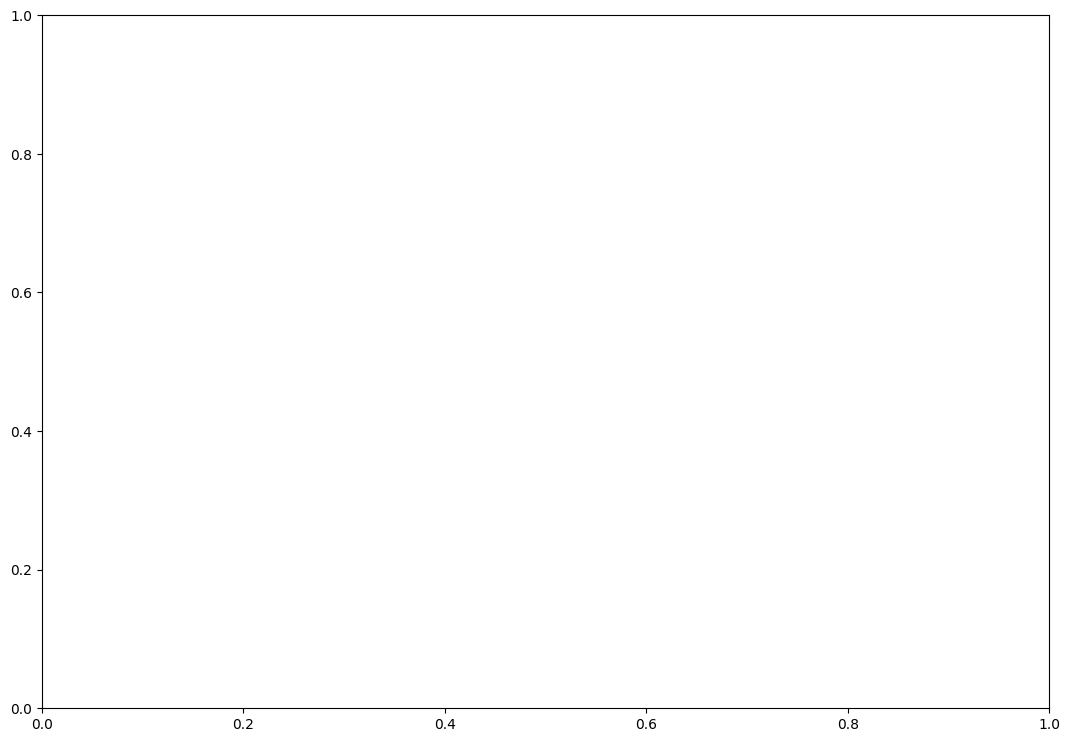

In [91]:
# STEP TWO: read and plot
dir = "/Users/atcushen/Documents/MercuryModelling/runs/nightside_v4_run1/ta-234e/"     # Directory with data 
#dir = "/Volumes/My Book Duo/runs/nightside_v5_run1/ta-2/"
start_time = 30 
t_bound = [65,70]                                               # Start and stop times of this data to be plot
dt = 0.05          

# Plotmode settings
particle_type = "electron"
xlims = [-2.5,-0.25]#[-3.25,0]
ylims = [-1.2,1.2]#[-1.25,1.25]
mi_me = 100 # ion to electron mass ratio

'''
PLOTMODES
"rho": density in PIC domain.
    Parameters: particle_type, xlim, ylim

"Delta_rho": Perturbation rho in PIC domain.
    Parameters: particle_type, xlim, ylim

"avg_rho": density in PIC domain, averaged across all times
    Parameters: particle_type, xlim, ylim

"Bz": Bz in PIC domain.
    Parameters: xlim, ylim

"Bz1": Bz-Bzdip in PIC domain.
    Parameters: xlim, ylim

"avg_Bz1": Bz_Bzdip averaged across all times.

"Delta_Bz": Perturbation Bz in PIC domain.
    Parameters: xlim, ylim

"Delta_Bz_J": Perturbation Bz in PIC domain, as well as delta Jx and delta Jy quivers
    Parameters: xlim, ylim

"ux": Bulk velocity in PIC domain.
    Parameters: particle_type, xlim, ylim

"grad_curv": Color contour and quivers of particle drift velocity
    Paramters: particle_type, xlim, ylim

"Jy": Dawn/dusk current
    Parameters: xlim, ylim

"Jy_avg": time-averaged current
    Parameters: xlim, ylim

"mass_flux": (Planetward) (ion) mass flux in PIC domain.
    Parameters: particle_type, xlim, ylim

"T": Maxwellian temperature in PIC domain.
    Parameters: particle_type, xlim, ylim

"Delta_T": Perturbation temperature in PIC domain.
    Parameters: particle_type, xlim, ylim

"T_perp_para": Two panel plot of parallel and perpendicular temperature
    Paramters: particle_type, xlim, ylim

'J_inrt_gradp': shows the inertial and grad(p) currents
    Paramters: particle_type, xlim, ylim

"df_tracker": show DFs and track their trajectories, saving a dictionary of their data
    Parameters: xlim, ylim, view_type = 2D or 3D

"along_line": Show many variables along line trajectory
    Parameters: start_loc, stop_loc, var_ls = ["Bz","rhoS1","uxS0","uyS0","uxS1","uyS1","pxxS0","pyyS0","pzzS0","pxxS1","pyyS1","pzzS1"]

'cross_tail': Line plot of total (planetward magnetic) flux transfer rate across tail. Averages over multiple seconds.
    Parameters: xlim

'current_sheet_avg': Average position of current sheet

'current_sheet_avg_3D': Average position of current sheet in 3D isometric view

'non_gyrotropy': 2 different measures of plasma non-gyrotropy meant to indicate reconnection sites
    Parameters: particle_type, xlims, ylims

"df_tracker2": Complete redesign of df tracker algorithm, post-AGU2024, designed to pair dBz>0 with dBz<0 in front
***MOVED OVER TO 3D_plotting FOR FIELD LINE CLASSIFICATION*****
    Parameters: xlims, ylims

'''

plot_preset = 'avg_Bz1'
view_type = '2D'
var_ls = ["Bz","rhoS1","uxS0","uyS0","uzS0","uxS1","uyS1","uzS1","pxxS0","pyyS0","pzzS0","pxxS1","pyyS1","pzzS1"]

#RUN
files = get_files(dir,key="3d\_fluid.*csdata\_t\_...\...",read_time = True)
iter = 0
for time in list(files.keys()): 
    print("Plotting t =",time)

    # Get the file and read the data
    file = str(files[time])
    with open(dir+file, 'rb') as f:
        data = pickle.load(f) 

    # PLOT PRESET 'RHO'
    if plot_preset=='rho':
        fig, ax = plt.subplots(figsize=(13,9))

        # Unpack variables
        X = data["X"]
        Y = data["Y"]
        Z = data["Y"]
        if particle_type == "ion":
            rho = data["rhoS1"]

        # Plot
        inner = plt.Circle((0, 0), np.sqrt(0.8**2-np.mean(Z)**2), color='black')
        outer = plt.Circle((0, 0), np.sqrt(1-np.mean(Z)**2), color='grey')

        vmin = -1
        vmax = 1
        nlevels = 21 
        levels = np.logspace(vmin, vmax, nlevels)
        cs_plot = ax.contourf(X, Y, data['rhoS1'], levels=levels, cmap='rainbow', norm=LogNorm(), extend='both')
        ax.contour(X, Y, rho, [0])
        ax.plot([-0.068,-2.999,-2.999,-0.068],[-1.1,-1.1,1.1,1.1],color="black")

        x_major_ticks = np.arange(xlims[0], xlims[1], 0.25)
        x_minor_ticks = np.arange(xlims[0], xlims[1], 0.05)
        y_major_ticks = np.arange(ylims[0], ylims[1], 0.25)
        y_minor_ticks = np.arange(ylims[0], ylims[1], 0.05)

        ax.set_xticks(x_major_ticks)
        ax.set_xticks(x_minor_ticks, minor=True)
        ax.set_yticks(y_major_ticks)
        ax.set_yticks(y_minor_ticks, minor=True)

        ax.grid(which='both')
        ax.grid(which='minor', alpha=0.2)
        ax.grid(which='major', alpha=0.5)
        
        #ticks = get_ticks(vmin, vmax)
        clb1 = fig.colorbar(cs_plot, ax=ax, norm=LogNorm()) 
        clb1.ax.tick_params(labelsize=15)
        clb1.locator = LogLocator()
        clb1.formatter = LogFormatterSciNotation()  
        clb1.ax.set_title('ρ [amu/cc]',fontsize=15)
        ax.set_aspect(1) # you may also use am.imshow(..., aspect="auto") to restore the aspect ratio
        ax.set_xlabel("X [$R_M$]",fontsize=15)
        ax.set_ylabel("Y [$R_M$]",fontsize=15)
        ax.tick_params(axis='both',labelsize=15)
        ax.add_patch(outer)
        ax.add_patch(inner)
        ax.set_xlim(xlims)
        ax.set_ylim(ylims)
        ax.set_title(str(particle_type+" density at t="+time+"s"),fontsize=15)

        # Save
        fig.savefig(str(str(dir[:-1])+"_plots/"+particle_type+"_"+plot_preset+"_"+time+'.png'),bbox_inches='tight', dpi=300)
        plt.close(fig)

    # PLOT PRESET 'Delta_rho'
    if plot_preset=='Delta_rho':
        fig, ax = plt.subplots(figsize=(13,9))

        # Unpack variables
        X = data["X"]
        Y = data["Y"]
        Z = data["Y"]
        if particle_type == "ion":
            rho_avg = average_value(["rhoS1"],float(time),-0.5,0.5)["rhoS1"]
            rho = data["rhoS1"]

        # Plot
        inner = plt.Circle((0, 0), np.sqrt(0.8**2-np.mean(Z)**2), color='black')
        outer = plt.Circle((0, 0), np.sqrt(1-np.mean(Z)**2), color='grey')

        vmin = -2
        vmax = 2
        nlevels = 21 
        levels = np.linspace(vmin, vmax, nlevels)
        cs_plot = ax.contourf(X, Y, rho-rho_avg, levels=levels, cmap='bwr', extend='both')
        ax.contour(X, Y, rho, [0])
        ax.plot([-0.068,-2.999,-2.999,-0.068],[-1.1,-1.1,1.1,1.1],color="black")

        x_major_ticks = np.arange(xlims[0], xlims[1], 0.25)
        x_minor_ticks = np.arange(xlims[0], xlims[1], 0.05)
        y_major_ticks = np.arange(ylims[0], ylims[1], 0.25)
        y_minor_ticks = np.arange(ylims[0], ylims[1], 0.05)

        ax.set_xticks(x_major_ticks)
        ax.set_xticks(x_minor_ticks, minor=True)
        ax.set_yticks(y_major_ticks)
        ax.set_yticks(y_minor_ticks, minor=True)

        ax.grid(which='both')
        ax.grid(which='minor', alpha=0.2)
        ax.grid(which='major', alpha=0.5)
        
        #ticks = get_ticks(vmin, vmax)
        clb1 = fig.colorbar(cs_plot, ax=ax) 
        clb1.ax.tick_params(labelsize=15)
        clb1.ax.set_title('ρ [amu/cc]',fontsize=15)
        ax.set_aspect(1) # you may also use am.imshow(..., aspect="auto") to restore the aspect ratio
        ax.set_xlabel("X [$R_M$]",fontsize=15)
        ax.set_ylabel("Y [$R_M$]",fontsize=15)
        ax.tick_params(axis='both',labelsize=15)
        ax.add_patch(outer)
        ax.add_patch(inner)
        ax.set_xlim(xlims)
        ax.set_ylim(ylims)
        ax.set_title(str("$\Delta$ρ at t="+time+"s"),fontsize=15)

        # Save
        fig.savefig(str(str(dir[:-1])+"_plots/"+particle_type+"_"+plot_preset+"_"+time+'.png'),bbox_inches='tight', dpi=300)
        plt.close(fig)

    if plot_preset=='avg_rho':
        fig, ax = plt.subplots(figsize=(9,6))

        # Unpack variables
        X = data["X"]
        Y = data["Y"]
        Z = data["Y"]
        if particle_type == "ion":
            rho = average_value(["rhoS1"],float(time),-60,0)["rhoS1"]

        # Plot
        inner = plt.Circle((0, 0), np.sqrt(0.8**2-np.mean(Z)**2), color='black')
        outer = plt.Circle((0, 0), np.sqrt(1-np.mean(Z)**2), color='grey')

        vmin = 0
        vmax = 6.6
        nlevels = 21 
        levels = np.linspace(vmin, vmax, nlevels)
        #levels = np.linspace(0.5,12,nlevels)
        cs_plot = ax.contourf(X, Y, rho, levels=levels, cmap='jet',extend='both')#,norm=LogNorm())
        ax.contour(X, Y, rho, [0])
        ax.plot([-0.068,-2.999,-2.999,-0.068],[-1.1,-1.1,1.1,1.1],color="black")

        x_major_ticks = np.arange(xlims[0], xlims[1], 0.5)
        x_minor_ticks = np.arange(xlims[0], xlims[1], 0.05)
        y_major_ticks = np.arange(ylims[0], ylims[1], 0.5)
        y_minor_ticks = np.arange(ylims[0], ylims[1], 0.05)

        ax.set_xticks(x_major_ticks)
        ax.set_xticks(x_minor_ticks, minor=True)
        ax.set_yticks(y_major_ticks)
        ax.set_yticks(y_minor_ticks, minor=True)

        ax.grid(which='both')
        ax.grid(which='minor', alpha=0.2)
        ax.grid(which='major', alpha=0.5)
        
        #ticks = get_ticks(vmin, vmax)
        clb1 = fig.colorbar(cs_plot, ax=ax)#, norm=LogNorm())

        # Set major ticks to powers of 10
        #clb1.ax.yaxis.set_major_locator(LogLocator(base=10.0))
        #clb1.ax.yaxis.set_major_formatter(LogFormatterSciNotation())
        
        # Set minor ticks every 0.1 decades
        #clb1.ax.yaxis.set_minor_locator(LogLocator(base=10.0, subs="auto", numticks=100))
        #clb1.ax.yaxis.set_minor_formatter(NullFormatter())  # No labels for minor ticks
        
        # Customize tick appearance
        clb1.ax.tick_params(labelsize=15)
        clb1.ax.set_title('n [cm$^{-3}$]',fontsize=15)
        ax.set_aspect(1) # you may also use am.imshow(..., aspect="auto") to restore the aspect ratio
        ax.set_xlabel("X [$R_M$]",fontsize=15)
        ax.set_ylabel("Y [$R_M$]",fontsize=15)
        ax.tick_params(axis='both',labelsize=15)
        ax.add_patch(outer)
        ax.add_patch(inner)
        ax.set_xlim(xlims)
        ax.set_ylim(ylims)
        ax.set_title(str(particle_type+" density at t="+time+"s"),fontsize=15)

        # Save
        fig.savefig(str(str(dir[:-1])+"_plots/"+particle_type+"_"+plot_preset+"_"+time+'.png'),bbox_inches='tight', dpi=300)
        plt.close(fig)

    # PLOT PRESET 'Bz'
    if plot_preset=='Bz':
        fig, ax = plt.subplots(figsize=(13,9))

        # Unpack variables
        X = data["X"]
        Y = data["Y"]
        Z = data["Y"]
        Bz = data["Bz"]

        # Plot
        inner = plt.Circle((0, 0), np.sqrt(0.8**2-np.mean(Z)**2), color='black')
        outer = plt.Circle((0, 0), np.sqrt(1-np.mean(Z)**2), color='grey')

        vmin = 0
        vmax = 100
        nlevels = 21 
        levels = np.linspace(vmin, vmax, nlevels)
        cs_plot = ax.contourf(X, Y, Bz, levels=levels, cmap='rainbow', extend='both')
        ax.contour(X, Y, data['rhoS1'], [0])
        ax.plot([-0.068,-2.999,-2.999,-0.068],[-1.1,-1.1,1.1,1.1],color="black")

        x_major_ticks = np.arange(xlims[0], xlims[1], 0.25)
        x_minor_ticks = np.arange(xlims[0], xlims[1], 0.05)
        y_major_ticks = np.arange(ylims[0], ylims[1], 0.25)
        y_minor_ticks = np.arange(ylims[0], ylims[1], 0.05)

        ax.set_xticks(x_major_ticks)
        ax.set_xticks(x_minor_ticks, minor=True)
        ax.set_yticks(y_major_ticks)
        ax.set_yticks(y_minor_ticks, minor=True)

        ax.grid(which='both')
        ax.grid(which='minor', alpha=0.2)
        ax.grid(which='major', alpha=0.5)
        
        #ticks = get_ticks(vmin, vmax)
        clb1 = fig.colorbar(cs_plot, ax=ax) 
        clb1.ax.tick_params(labelsize=15)
        clb1.ax.set_title('$B_z$ [nT]',fontsize=15)
        ax.set_aspect(1) # you may also use am.imshow(..., aspect="auto") to restore the aspect ratio
        ax.set_xlabel("X [$R_M$]",fontsize=15)
        ax.set_ylabel("Y [$R_M$]",fontsize=15)
        ax.tick_params(axis='both',labelsize=15)
        ax.add_patch(outer)
        ax.add_patch(inner)
        ax.set_xlim(xlims)
        ax.set_ylim(ylims)
        ax.set_title(str("$B_z$ at t="+time+"s"),fontsize=15)

        # Save
        fig.savefig(str(str(dir[:-1])+"_plots/"+plot_preset+"_"+time+'.png'),bbox_inches='tight', dpi=300)
        plt.close(fig)

    # PLOT PRESET 'Bz1'
    if plot_preset=='Bz1':
        fig, ax = plt.subplots(figsize=(13,9))

        # Unpack variables
        X = data["X"]
        Y = data["Y"]
        Z = data["Z"]
        Bz = data["Bz"]
        #beta = 2*mu_0*(data["pxxS0"]+data["pyyS0"]+data["pzzS0"]+data["pxxS1"]+data["pyyS1"]+data["pzzS1"])*1e9/3/(data["Bx"]**2+data["By"]**2+data["Bz"]**2)
        Bz1 = Bz-Bz_dip(X,Y,Z)
        Bz1[data['rhoS1']<1e-3]=0

        # Plot
        inner = plt.Circle((0, 0), np.sqrt(0.8**2-np.mean(Z)**2), color='black')
        outer = plt.Circle((0, 0), np.sqrt(1-np.mean(Z)**2), color='grey')

        vmin = -100
        vmax = 100
        nlevels = 21 
        levels = np.linspace(vmin, vmax, nlevels)
        cs_plot = ax.contourf(X, Y, Bz1, levels=levels, cmap='bwr', extend='both')
        ax.contour(X, Y, data['rhoS1'], [0])
        #ax.plot([-0.068,-2.999,-2.999,-0.068],[-1.1,-1.1,1.1,1.1],color="black")
        #ax.contour(X, Y, beta, [1],linewidths=2,colors='black')

        x_major_ticks = np.arange(xlims[0], xlims[1], 0.25)
        x_minor_ticks = np.arange(xlims[0], xlims[1], 0.05)
        y_major_ticks = np.arange(ylims[0], ylims[1], 0.25)
        y_minor_ticks = np.arange(ylims[0], ylims[1], 0.05)

        ax.set_xticks(x_major_ticks)
        ax.set_xticks(x_minor_ticks, minor=True)
        ax.set_yticks(y_major_ticks)
        ax.set_yticks(y_minor_ticks, minor=True)

        ax.grid(which='both')
        ax.grid(which='minor', alpha=0.2)
        ax.grid(which='major', alpha=0.5)
        
        #ticks = get_ticks(vmin, vmax)
        clb1 = fig.colorbar(cs_plot, ax=ax) 
        clb1.ax.tick_params(labelsize=15)
        clb1.ax.set_title('$B_{z1}$ [nT]',fontsize=15)
        ax.set_aspect(1) # you may also use am.imshow(..., aspect="auto") to restore the aspect ratio
        ax.set_xlabel("X [$R_M$]",fontsize=15)
        ax.set_ylabel("Y [$R_M$]",fontsize=15)
        ax.tick_params(axis='both',labelsize=15)
        ax.add_patch(outer)
        ax.add_patch(inner)
        ax.set_xlim(xlims)
        ax.set_ylim(ylims)
        ax.set_title(str("$B_z - B_{z,dip}$ at t="+time+"s"),fontsize=15)

        # Save
        fig.savefig(str(str(dir[:-1])+"_plots/"+plot_preset+"_"+time+'.png'),bbox_inches='tight', dpi=300)
        plt.close(fig)

    # PLOT PRESET 'avg_Bz1'
    if plot_preset=='avg_Bz1':
        fig, ax = plt.subplots(figsize=(13,9))

        # Unpack variables
        X = data["X"]
        Y = data["Y"]
        Z = data["Y"]
        Bz = data["Bz"]
        avg = average_value(["Z","Bz"],float(time),-30,0)
        Bz_avg = avg['Bz']
        Z_avg = avg["Z"]

        # Plot
        inner = plt.Circle((0, 0), np.sqrt(0.8**2-np.mean(Z)**2), color='black')
        outer = plt.Circle((0, 0), np.sqrt(1-np.mean(Z)**2), color='grey')

        # Apply correction
        Bz1 = Bz_avg-Bz_dip(X,Y,Z_avg)
        Bz1[Bz1<-50] = 0

        vmin = -50
        vmax = 50
        nlevels = 41 
        levels = np.linspace(vmin, vmax, nlevels)
        cs_plot = ax.contourf(X, Y, Bz1, levels=levels, cmap='bwr', extend='both')
        ax.contour(X, Y, data['rhoS1'], [0])
       # ax.plot([-0.068,-2.999,-2.999,-0.068],[-1.1,-1.1,1.1,1.1],color="black")

        x_major_ticks = np.arange(xlims[0], xlims[1], 0.5)
        x_minor_ticks = np.arange(xlims[0], xlims[1], 0.1)
        y_major_ticks = np.arange(ylims[0], ylims[1], 0.4)
        y_minor_ticks = np.arange(ylims[0], ylims[1], 0.1)

        ax.set_xticks(x_major_ticks)
        ax.set_xticks(x_minor_ticks, minor=True)
        ax.set_yticks(y_major_ticks)
        ax.set_yticks(y_minor_ticks, minor=True)

        ax.grid(which='both')
        ax.grid(which='minor', alpha=0.2)
        ax.grid(which='major', alpha=0.5)
        
        #ticks = get_ticks(vmin, vmax)
        clb1 = fig.colorbar(cs_plot, ax=ax) 
        clb1.ax.tick_params(labelsize=15)
        clb1.ax.set_title('$B_{z1}$ [nT]',fontsize=15)
        ax.set_aspect(1) # you may also use am.imshow(..., aspect="auto") to restore the aspect ratio
        ax.set_xlabel("X [$R_M$]",fontsize=15)
        ax.set_ylabel("Y [$R_M$]",fontsize=15)
        ax.tick_params(axis='both',labelsize=15)
        ax.add_patch(outer)
        ax.add_patch(inner)
        ax.set_xlim(xlims)
        ax.set_ylim(ylims)
        ax.set_title(str("Average $B_z - B_{z,dip}$ across all times"),fontsize=15)

        # Save
        fig.savefig(str(str(dir[:-1])+"_plots/"+plot_preset+"_"+time+'.png'),bbox_inches='tight', dpi=300)
        plt.close(fig)


    # PLOT PRESET 'Delta_Bz'
    if plot_preset=='Delta_Bz':
        fig, ax = plt.subplots(figsize=(13,9))

        # Unpack variables
        X = data["X"]
        Y = data["Y"]
        Z = data["Z"]
        Bz = data["Bz"]
        beta = 2*mu_0*(data["pxxS0"]+data["pyyS0"]+data["pzzS0"]+data["pxxS1"]+data["pyyS1"]+data["pzzS1"])*1e9/3/(data["Bx"]**2+data["By"]**2+data["Bz"]**2)

        # Get time-averaged Bz
        Bz_avg = average_value(["Bz"],float(time),-15,-5)["Bz"]

        # Plot
        inner = plt.Circle((0, 0), np.sqrt(0.8**2-np.mean(Z)**2), color='black')
        outer = plt.Circle((0, 0), np.sqrt(1-np.mean(Z)**2), color='grey')

        vmin = -50
        vmax = 50
        nlevels = 21 
        levels = np.linspace(vmin, vmax, nlevels)
        cs_plot = ax.contourf(X, Y, Bz-Bz_avg, levels=levels, cmap='bwr', extend='both')
        ax.contour(X, Y, data["rhoS1"], [0])
        #ax.contour(X[:,90:], Y[:,90:], beta[:,90:], [1],linewidths=2,colors='black')
        #ax.plot([-0.068,-2.999,-2.999,-0.068],[-1.1,-1.1,1.1,1.1],color="black")

        x_major_ticks = np.arange(xlims[0], xlims[1], 0.5)
        x_minor_ticks = np.arange(xlims[0], xlims[1], 0.10)
        y_major_ticks = np.arange(ylims[0], ylims[1], 0.5)
        y_minor_ticks = np.arange(ylims[0], ylims[1], 0.10)

        ax.set_xticks(x_major_ticks)
        ax.set_xticks(x_minor_ticks, minor=True)
        ax.set_yticks(y_major_ticks)
        ax.set_yticks(y_minor_ticks, minor=True)

        ax.grid(which='both')
        ax.grid(which='minor', alpha=0.2)
        ax.grid(which='major', alpha=0.5)
        
        #ticks = get_ticks(vmin, vmax)
        clb1 = fig.colorbar(cs_plot, ax=ax) 
        clb1.ax.tick_params(labelsize=15)
        clb1.ax.set_title('$\delta B_z$ [nT]',fontsize=15)
        ax.set_aspect(1) # you may also use am.imshow(..., aspect="auto") to restore the aspect ratio
        ax.set_xlabel("X [$R_M$]",fontsize=15)
        ax.set_ylabel("Y [$R_M$]",fontsize=15)
        ax.tick_params(axis='both',labelsize=15)
        ax.add_patch(outer)
        ax.add_patch(inner)
        ax.set_xlim(xlims)
        ax.set_ylim(ylims)
        ax.set_title(str("$\delta B_z$ at t="+time+"s"),fontsize=15)

        # Save
        fig.savefig(str(str(dir[:-1])+"_plots/"+plot_preset+"_"+time+'.png'),bbox_inches='tight', dpi=300)
        plt.close(fig)

    # PLOT PRESET 'Delta_Bz_J'
    if plot_preset=='Delta_Bz_J':
        fig, ax = plt.subplots(figsize=(13,9))

        # Unpack variables
        X = data["X"]
        Y = data["Y"]
        Z = data["Z"]
        Bz = data["Bz"]
        Jx = data["Jx"]
        Jy = data["Jy"]

        # Get time-averaged Bz, Jx, Jy
        avgs = average_value(["Bz","Jx","Jy"],float(time),-15,-5)
        Bz_avg,Jx_avg,Jy_avg = (avgs["Bz"],avgs["Jx"],avgs["Jy"])

        # Plot
        inner = plt.Circle((0, 0), np.sqrt(0.8**2-np.mean(Z)**2), color='black')
        outer = plt.Circle((0, 0), np.sqrt(1-np.mean(Z)**2), color='grey')

        vmin = -50
        vmax = 50
        nlevels = 21 
        skip = 2
        levels = np.linspace(vmin, vmax, nlevels)
        cs_plot = ax.contourf(X, Y, Bz-Bz_avg, levels=levels, cmap='bwr', extend='both')
        quiver_plot = ax.quiver(X[::skip,::skip],Y[::skip,::skip],(Jx-Jx_avg)[::skip,::skip],(Jy-Jy_avg)[::skip,::skip])
        ax.contour(X, Y, data["rhoS1"], [0])
        #ax.contour(X[:,90:], Y[:,90:], beta[:,90:], [1],linewidths=2,colors='black')
        #ax.plot([-0.068,-2.999,-2.999,-0.068],[-1.1,-1.1,1.1,1.1],color="black")

        x_major_ticks = np.arange(xlims[0], xlims[1], 0.5)
        x_minor_ticks = np.arange(xlims[0], xlims[1], 0.10)
        y_major_ticks = np.arange(ylims[0], ylims[1], 0.5)
        y_minor_ticks = np.arange(ylims[0], ylims[1], 0.10)

        ax.set_xticks(x_major_ticks)
        ax.set_xticks(x_minor_ticks, minor=True)
        ax.set_yticks(y_major_ticks)
        ax.set_yticks(y_minor_ticks, minor=True)

        ax.grid(which='both')
        ax.grid(which='minor', alpha=0.2)
        ax.grid(which='major', alpha=0.5)
        
        #ticks = get_ticks(vmin, vmax)
        clb1 = fig.colorbar(cs_plot, ax=ax) 
        clb1.ax.tick_params(labelsize=15)
        clb1.ax.set_title('$\delta B_z$ [nT]',fontsize=15)
        ax.set_aspect(1) # you may also use am.imshow(..., aspect="auto") to restore the aspect ratio
        ax.set_xlabel("X [$R_M$]",fontsize=15)
        ax.set_ylabel("Y [$R_M$]",fontsize=15)
        ax.tick_params(axis='both',labelsize=15)
        ax.add_patch(outer)
        ax.add_patch(inner)
        ax.set_xlim(xlims)
        ax.set_ylim(ylims)
        ax.set_title(str("$\delta B_z$ at t="+time+"s"),fontsize=15)

        # Save
        fig.savefig(str(str(dir[:-1])+"_plots/"+plot_preset+"_"+time+'.png'),bbox_inches='tight', dpi=300)
        plt.close(fig)

    if plot_preset=='ux':
        fig, ax = plt.subplots(figsize=(13,9))

        # Unpack variables
        X = data["X"]
        Y = data["Y"]
        Z = data["Y"]
        if particle_type == "ion":
            ux = data["uxS1"]
            vmin = -1500
            vmax = 1500
        elif particle_type == "electron":
            ux = data["uxS0"]
            vmin = -3000
            vmax = 3000

        # Plot
        inner = plt.Circle((0, 0), np.sqrt(0.8**2-np.mean(Z)**2), color='black')
        outer = plt.Circle((0, 0), np.sqrt(1-np.mean(Z)**2), color='grey')

        #vmin = -2000
        #vmax = 2000
        nlevels = 21 
        levels = np.linspace(vmin, vmax, nlevels)
        cs_plot = ax.contourf(X, Y, ux, levels=levels, cmap='bwr', extend='both')
        ax.contour(X, Y, data['rhoS1'], [0])
        #ax.plot([-0.068,-2.999,-2.999,-0.068],[-1.1,-1.1,1.1,1.1],color="black")

        x_major_ticks = np.arange(xlims[0], xlims[1], 0.25)
        x_minor_ticks = np.arange(xlims[0], xlims[1], 0.05)
        y_major_ticks = np.arange(ylims[0], ylims[1], 0.25)
        y_minor_ticks = np.arange(ylims[0], ylims[1], 0.05)

        ax.set_xticks(x_major_ticks)
        ax.set_xticks(x_minor_ticks, minor=True)
        ax.set_yticks(y_major_ticks)
        ax.set_yticks(y_minor_ticks, minor=True)

        ax.grid(which='both')
        ax.grid(which='minor', alpha=0.2)
        ax.grid(which='major', alpha=0.5)
        
        #ticks = get_ticks(vmin, vmax)
        clb1 = fig.colorbar(cs_plot, ax=ax) 
        clb1.ax.tick_params(labelsize=15)
        #clb1.locator = LogLocator()
        #clb1.formatter = LogFormatterSciNotation()  
        clb1.ax.set_title('v [km/s]',fontsize=15)
        ax.set_aspect(1) # you may also use am.imshow(..., aspect="auto") to restore the aspect ratio
        ax.set_xlabel("X [$R_M$]",fontsize=15)
        ax.set_ylabel("Y [$R_M$]",fontsize=15)
        ax.tick_params(axis='both',labelsize=15)
        ax.add_patch(outer)
        ax.add_patch(inner)
        ax.set_xlim(xlims)
        ax.set_ylim(ylims)
        ax.set_title(str(particle_type+" x-velocity at t="+time+"s"),fontsize=15)

        # Save
        fig.savefig(str(str(dir[:-1])+"_plots/"+particle_type+"_"+plot_preset+"_"+time+'.png'),bbox_inches='tight', dpi=300)
        plt.close(fig)

    if plot_preset=='grad_curv':
        fig, ax = plt.subplots(figsize=(13,9))

        # Find current sheet
        if particle_type=="ion":
            pxx = data["pxxS1"]
            pxy = data["pxyS1"]
            pxz = data["pxzS1"]
            pyy = data["pyyS1"]
            pyz = data["pyzS1"]
            pzz = data["pzzS1"]
        elif particle_type=="electron":
            pxx = data["pxxS0"]
            pxy = data["pxyS0"]
            pxz = data["pxzS0"]
            pyy = data["pyyS0"]
            pyz = data["pyzS0"]
            pzz = data["pzzS0"]
            y_bulk_flow = data["uyS0"] # [km/s]
        else:
            print("ERROR: invalid particle type!")

        # Unpack variables
        X = data["X"]
        Y = data["Y"]
        Z = data["Y"]
        Bx = data["Bx"]
        By = data["By"]
        Bz = data["Bz"]
        dB_dx = data["dB_dx"]
        dB_dy = data["dB_dy"]
        dB_dz = data["dB_dz"]
        Ex = data["Ex"]
        Ey = data["Ey"]
        Ez = data["Ez"]
        n = data["rhoS1"]*1e6 # [amu/m^3]
        deltaBz = Bz - average_value(["Bz"],float(time),-10,-5,type='csdata')["Bz"]
        
         # Compute magnetic unit vector
        B_mag = np.sqrt(Bx**2+By**2+Bz**2) # nT
        bx,by,bz = 1/B_mag * [Bx,By,Bz]
    
        # Compute magnetic field unit vectors: u,v,b. u is parallel to ExB direction. v = uxb. We already have b.
        # In the end, our new system will be perp1, perp2, para (u,v,b). See back page of space physics 2024 notebook for derivation, or photos from sep. 4, 2024
        # Compute u first, making sure to normalize
        ux,uy,uz = [Ey*Bz-Ez*By, Ez*Bx-Ex*Bz, Ex*By-Ey*Bx]
        ux,uy,uz = 1/np.sqrt(ux**2+uy**2+uz**2)*[ux,uy,uz]
    
        # Then compute v (already normalized):
        vx,vy,vz = [uy*bz-uz*by, uz*bx-ux*bz, ux*by-uy*bx]
    
        # We now compute the three diagonal pressure components, using e.g. P_para = b . p . b
        P11 = ux*(pxx*ux+pxy*uy+pxz*uz) + uy*(pxy*ux+pyy*uy+pyz*uz) + uz*(pxz*ux+pyz*uy+pzz*uz)
        P22 = vx*(pxx*vx+pxy*vy+pxz*vz) + vy*(pxy*vx+pyy*vy+pyz*vz) + vz*(pxz*vx+pyz*vy+pzz*vz)
        P33 = bx*(pxx*bx+pxy*by+pxz*bz) + by*(pxy*bx+pyy*by+pyz*bz) + bz*(pxz*bx+pyz*by+pzz*bz)
    
        # For now, we are interested in the difference parallel (Pzz) and perpendicular (Pxx and Pyy)
        # See Gurnett+Bhattacharjee "Introduction to Plasma Physics: Kinetic Theory and the Moment Equations" p151
        T_perp = (P11+P11)/2/n/k_b * 1e-9 # convert from nPa and 1/cm^3
        T_para = (P33)/2/n/k_b * 1e-9 # [K]
    
        # Now, find the parallel / perpendicular thermal velocities
        if particle_type=="ion":
            m = m_p
            q = e
        elif particle_type=="electron":
            m = m_p/mi_me # Using the simulated electron mass
            q = -e
        v_perp_th = np.sqrt(8*k_b*T_perp/(np.pi*m)) #m/s
        v_para_th = np.sqrt(8*k_b*T_para/(np.pi*m)) #m/s
    
        # Finally, compute gc drift in km/s
        v_gc_x = m*(0.5*v_perp_th**2+v_para_th**2)/q*(By*dB_dz-Bz*dB_dy)/B_mag**3/1e-9 * 1e-3
        v_gc_y = m*(0.5*v_perp_th**2+v_para_th**2)/q*(Bz*dB_dx-Bx*dB_dz)/B_mag**3/1e-9 * 1e-3
        #v_gc_z = m_p*(0.5*v_perp_th**2+v_para_th**2)/q*(Bx*dB_dy-By*dB_dx)/B_mag**3/1e-9 * 1e-3
    
        # Plot
        quiver_skip = 5
        if particle_type=="ion":
            vmin = 1
            vmax = 3.5
        elif particle_type=="electron":
            vmin = 6
            vmax = 8.5
        nlevels = 31 
        levels = np.linspace(-1e4, 1e4, nlevels)
    
        # Plot y component of grad_curv
        contour_plot = ax.contourf(X,Y,y_bulk_flow - v_gc_y, cmap='bwr',levels=levels,extend='both')
        #quiver_plot = ax.quiver(data["X"][::quiver_skip,::quiver_skip],data["Y"][::quiver_skip,::quiver_skip], 
        #                        v_gc_x[::quiver_skip,::quiver_skip], v_gc_y[::quiver_skip,::quiver_skip],color="white")
        ax.contour(X,Y,deltaBz, [10], colors='black')

        x_major_ticks = np.arange(xlims[0], xlims[1], 0.5)
        x_minor_ticks = np.arange(xlims[0], xlims[1], 0.1)
        y_major_ticks = np.arange(ylims[0], ylims[1], 0.4)
        y_minor_ticks = np.arange(ylims[0], ylims[1], 0.1)
    
        ax.set_xticks(x_major_ticks)
        ax.set_xticks(x_minor_ticks, minor=True)
        ax.set_yticks(y_major_ticks)
        ax.set_yticks(y_minor_ticks, minor=True)
    
        ax.grid(which='both')
        ax.grid(which='minor', alpha=0.2)
        ax.grid(which='major', alpha=0.5)
    
        clb1 = fig.colorbar(contour_plot, ax=ax)  
        #clb1.locator = LogLocator()
        #clb1.formatter = LogFormatterSciNotation()       
        clb1.ax.tick_params(labelsize=12)
        clb1.ax.set_title('$v-v_{GC}$ [km/s]',fontsize=12)
        
        ax.set_aspect(1) # you may also use am.imshow(..., aspect="auto") to restore the aspect ratio
        ax.set_xlabel("X [$R_M$]")
        ax.set_ylabel("Y [$R_M$]")
        ax.add_patch(plt.Circle((0, 0), 1, color='grey'))
        ax.add_patch(plt.Circle((0, 0), 0.8, color='black'))
        ax.set_xlim(xlims)
        ax.set_ylim(ylims)
        ax.set_title(str("Gradient-curvature drift velocity at t ="+"%.2f"%round(float(time),2)+"s"+"\n Particle type: "+particle_type))

        # Save
        fig.savefig(str(str(dir[:-1])+"_plots/"+particle_type+"_"+plot_preset+"_"+time+'.png'),bbox_inches='tight', dpi=300)
        plt.close(fig)

    if plot_preset=='Jy':
        fig, ax = plt.subplots(figsize=(13,9))

        # Unpack variables
        X = data["X"]
        Y = data["Y"]
        Z = data["Y"]
        Jy = data["Jy"]*1e9 # Convert to nA/m^2
        vmin = -500
        vmax = 500

        # Plot
        inner = plt.Circle((0, 0), np.sqrt(0.8**2-np.mean(Z)**2), color='black')
        outer = plt.Circle((0, 0), np.sqrt(1-np.mean(Z)**2), color='grey')

        nlevels = 21 
        levels = np.linspace(vmin, vmax, nlevels)
        cs_plot = ax.contourf(X, Y, Jy, levels=levels, cmap='bwr', extend='both')
        ax.contour(X, Y, data['rhoS1'], [0])
        #ax.plot([-0.068,-2.999,-2.999,-0.068],[-1.1,-1.1,1.1,1.1],color="black")

        x_major_ticks = np.arange(xlims[0], xlims[1], 0.5)
        x_minor_ticks = np.arange(xlims[0], xlims[1], 0.1)
        y_major_ticks = np.arange(ylims[0], ylims[1], 0.4)
        y_minor_ticks = np.arange(ylims[0], ylims[1], 0.1)

        ax.set_xticks(x_major_ticks)
        ax.set_xticks(x_minor_ticks, minor=True)
        ax.set_yticks(y_major_ticks)
        ax.set_yticks(y_minor_ticks, minor=True)

        ax.grid(which='both')
        ax.grid(which='minor', alpha=0.2)
        ax.grid(which='major', alpha=0.5)
        
        #ticks = get_ticks(vmin, vmax)
        clb1 = fig.colorbar(cs_plot, ax=ax) 
        clb1.ax.tick_params(labelsize=15)
        #clb1.locator = LogLocator()
        #clb1.formatter = LogFormatterSciNotation()  
        clb1.ax.set_title('$J_y$ [nA/m$^2$]',fontsize=15)
        ax.set_aspect(1) # you may also use am.imshow(..., aspect="auto") to restore the aspect ratio
        ax.set_xlabel("X [$R_M$]",fontsize=15)
        ax.set_ylabel("Y [$R_M$]",fontsize=15)
        ax.tick_params(axis='both',labelsize=15)
        ax.add_patch(outer)
        ax.add_patch(inner)
        ax.set_xlim(xlims)
        ax.set_ylim(ylims)
        ax.set_title(str("$J_y$ at t="+time+"s"),fontsize=15)

        # Save
        fig.savefig(str(str(dir[:-1])+"_plots/"+plot_preset+"_"+time+'.png'),bbox_inches='tight', dpi=300)
        plt.close(fig)

    if plot_preset=='Jy_avg':
        fig, ax = plt.subplots(figsize=(13,9))

        # Unpack variables
        X = data["X"]
        Y = data["Y"]
        Z = data["Y"]
        Jy = average_value(["Jy"],float(time),-30,0,type='csdata')["Jy"]*1e9 # Convert to nA/m^2
        vmin=-500
        vmax=500
        linthresh = 10  # Define the range around zero where the plot is linear
        linscale = 1   # Scale factor for linear region
        norm = SymLogNorm(linthresh=linthresh, linscale=linscale, vmin=vmin, vmax=vmax, base=10)

        # Plot
        inner = plt.Circle((0, 0), np.sqrt(0.8**2-np.mean(Z)**2), color='black')
        outer = plt.Circle((0, 0), np.sqrt(1-np.mean(Z)**2), color='grey')

        nlevels = 128 
        levels = np.linspace(vmin, vmax, nlevels)
        cs_plot = ax.contourf(X, Y, Jy, cmap='PuOr',norm=norm,levels=levels)
        ax.contour(X, Y, data['rhoS1'], [0])
        #ax.plot([-0.068,-2.999,-2.999,-0.068],[-1.1,-1.1,1.1,1.1],color="black")

        x_major_ticks = np.arange(xlims[0], xlims[1], 0.5)
        x_minor_ticks = np.arange(xlims[0], xlims[1], 0.1)
        y_major_ticks = np.arange(ylims[0], ylims[1], 0.4)
        y_minor_ticks = np.arange(ylims[0], ylims[1], 0.1)

        ax.set_xticks(x_major_ticks)
        ax.set_xticks(x_minor_ticks, minor=True)
        ax.set_yticks(y_major_ticks)
        ax.set_yticks(y_minor_ticks, minor=True)

        ax.grid(which='both')
        ax.grid(which='minor', alpha=0.2)
        ax.grid(which='major', alpha=0.5)
        
        #ticks = get_ticks(vmin, vmax)
        m1 = cm.ScalarMappable(cmap=cm.PuOr, norm=norm)
        m1.set_array(Jy)
        clb1 = fig.colorbar(m1, ax=ax) 
        clb1.ax.tick_params(labelsize=15)
        #clb1.locator = LogLocator()
        #clb1.formatter = LogFormatterSciNotation()  
        clb1.ax.set_title('$J_y$ [nA/m$^2$]',fontsize=15)
        ax.set_aspect(1) # you may also use am.imshow(..., aspect="auto") to restore the aspect ratio
        ax.set_xlabel("X [$R_M$]",fontsize=15)
        ax.set_ylabel("Y [$R_M$]",fontsize=15)
        ax.tick_params(axis='both',labelsize=15)
        ax.add_patch(outer)
        ax.add_patch(inner)
        ax.set_xlim(xlims)
        ax.set_ylim(ylims)
        ax.set_title(str("Avg. $J_y$ at t="+time+"s"),fontsize=15)

        # Save
        fig.savefig(str(str(dir[:-1])+"_plots/"+plot_preset+"_"+time+'.png'),bbox_inches='tight', dpi=300)
        plt.close(fig)


    if plot_preset=='mass_flux':
        fig, ax = plt.subplots(figsize=(13,9))

        # Unpack variables
        X = data["X"]
        Y = data["Y"]
        Z = data["Y"]
        if particle_type == "ion":
            ux = data["uxS1"]*data["rhoS1"] * 1e5
            vmin = -1e8
            vmax = 1e8
        elif particle_type == "electron":
            ux = data["uxS0"]*data["rhoS1"] * 1e5
            #vmin = -3000
            #vmax = 3000

        # Plot
        inner = plt.Circle((0, 0), np.sqrt(0.8**2-np.mean(Z)**2), color='black')
        outer = plt.Circle((0, 0), np.sqrt(1-np.mean(Z)**2), color='grey')

        #vmin = -2000
        #vmax = 2000
        nlevels = 21 
        levels = np.linspace(vmin, vmax, nlevels)
        cs_plot = ax.contourf(X, Y, ux, levels=levels, cmap='bwr', extend='both')
        ax.contour(X, Y, data['Bz'], [0])
        ax.contour(X, Y, data['rhoS1'], [0])
        #ax.plot([-0.068,-2.999,-2.999,-0.068],[-1.1,-1.1,1.1,1.1],color="black")

        x_major_ticks = np.arange(xlims[0], xlims[1], 0.50)
        x_minor_ticks = np.arange(xlims[0], xlims[1], 0.25)
        y_major_ticks = np.arange(ylims[0], ylims[1], 0.4)
        y_minor_ticks = np.arange(ylims[0], ylims[1], 0.2)

        ax.set_xticks(x_major_ticks)
        ax.set_xticks(x_minor_ticks, minor=True)
        ax.set_yticks(y_major_ticks)
        ax.set_yticks(y_minor_ticks, minor=True)

        ax.grid(which='both')
        ax.grid(which='minor', alpha=0.2)
        ax.grid(which='major', alpha=0.5)
        
        #ticks = get_ticks(vmin, vmax)
        clb1 = fig.colorbar(cs_plot, ax=ax) 
        clb1.ax.tick_params(labelsize=15)
        #clb1.locator = LogLocator()
        #clb1.formatter = LogFormatterSciNotation()  
        clb1.ax.set_title('$\dot{m}$ [amu/cm$^2$/s]',fontsize=15)
        ax.set_aspect(1) # you may also use am.imshow(..., aspect="auto") to restore the aspect ratio
        ax.set_xlabel("X [$R_M$]",fontsize=15)
        ax.set_ylabel("Y [$R_M$]",fontsize=15)
        ax.tick_params(axis='both',labelsize=15)
        ax.add_patch(outer)
        ax.add_patch(inner)
        ax.set_xlim(xlims)
        ax.set_ylim(ylims)
        ax.set_title(str(particle_type+" mass flux at t="+time+"s"),fontsize=15)

        # Save
        fig.savefig(str(str(dir[:-1])+"_plots/"+particle_type+"_"+plot_preset+"_"+time+'.png'),bbox_inches='tight', dpi=300)
        plt.close(fig)
        
    # PLOT PRESET 'T'
    if plot_preset=='T':
        fig, ax = plt.subplots(figsize=(13,9))

        # Unpack variables
        X = data["X"]
        Y = data["Y"]
        Z = data["Y"]
        if particle_type == "ion":
            avg = average_value(["rhoS1","pxxS1","pyyS1","pzzS1"],float(time),-100,0)
            n = avg["rhoS1"] * 1e6 # convert to SI
            p = (avg["pxxS1"]+avg["pyyS1"]+avg["pzzS1"])/3*1e-9 # convert to SI
        elif particle_type == "electron":
            avg = average_value(["rhoS0","pxxS0","pyyS0","pzzS0"],float(time),-100,0)
            n = avg["rhoS0"] * mi_me * 1e6 # convert to SI
            p = (avg["pxxS0"]+avg["pyyS0"]+avg["pzzS0"])/3*1e-9 # convert to SI

        T = p/n/k_b / 11605 #Convert to eV

        # Plot
        inner = plt.Circle((0, 0), np.sqrt(0.8**2-np.mean(Z)**2), color='black')
        outer = plt.Circle((0, 0), np.sqrt(1-np.mean(Z)**2), color='grey')

        vmin = 2
        vmax = 4
        nlevels = 21 
        levels = np.logspace(vmin, vmax, nlevels)
        cs_plot = ax.contourf(X, Y, T, levels=levels, cmap='rainbow', norm = LogNorm(), extend = 'both')
        ax.contour(X, Y, data['rhoS1'], [0])
        ax.plot([-0.068,-2.999,-2.999,-0.068],[-1.1,-1.1,1.1,1.1],color="black")

        x_major_ticks = np.arange(xlims[0], xlims[1], 0.25)
        x_minor_ticks = np.arange(xlims[0], xlims[1], 0.05)
        y_major_ticks = np.arange(ylims[0], ylims[1], 0.25)
        y_minor_ticks = np.arange(ylims[0], ylims[1], 0.05)

        ax.set_xticks(x_major_ticks)
        ax.set_xticks(x_minor_ticks, minor=True)
        ax.set_yticks(y_major_ticks)
        ax.set_yticks(y_minor_ticks, minor=True)

        ax.grid(which='both')
        ax.grid(which='minor', alpha=0.2)
        ax.grid(which='major', alpha=0.5)
        
        #ticks = get_ticks(vmin, vmax)
        clb1 = fig.colorbar(cs_plot, ax=ax, norm=LogNorm()) 
        clb1.ax.tick_params(labelsize=15)
        clb1.locator = LogLocator()
        clb1.formatter = LogFormatterSciNotation()  
        clb1.ax.set_title('T [eV]',fontsize=15)
        ax.set_aspect(1) # you may also use am.imshow(..., aspect="auto") to restore the aspect ratio
        ax.set_xlabel("X [$R_M$]",fontsize=15)
        ax.set_ylabel("Y [$R_M$]",fontsize=15)
        ax.tick_params(axis='both',labelsize=15)
        ax.add_patch(outer)
        ax.add_patch(inner)
        ax.set_xlim(xlims)
        ax.set_ylim(ylims)
        ax.set_title(str(particle_type+" temperature at t="+time+"s"),fontsize=15)

        # Save
        fig.savefig(str(str(dir[:-1])+"_plots/"+particle_type+"_"+plot_preset+"_"+time+'.png'),bbox_inches='tight', dpi=300)
        plt.close(fig)

    # PLOT PRESET 'Delta_T'
    if plot_preset=='Delta_T':
        fig, ax = plt.subplots(figsize=(13,9))

        # Unpack variables
        X = data["X"]
        Y = data["Y"]
        Z = data["Y"]
        if particle_type == "ion":
            n = data["rhoS1"] * 1e6 # convert to SI
            p = (data["pxxS1"]+data["pyyS1"]+data["pzzS1"])/3*1e-9 # convert to SI
            avg = average_value(["rhoS1","pxxS1","pyyS1","pzzS1"],float(time),-0.5,0.5)
            n_avg = avg["rhoS1"] * 1e6
            p_avg = (avg["pxxS1"]+avg["pyyS1"]+avg["pzzS1"])/3*1e-9
            
        elif particle_type == "electron":
            n = data["rhoS0"] * mi_me * 1e6 # convert to SI
            p = (data["pxxS0"]+data["pyyS0"]+data["pzzS0"])/3*1e-9 # convert to SI
            avg = average_value(["rhoS0","pxxS0","pyyS0","pzzS0"],float(time),-10,5)
            n_avg = avg["rhoS0"] * mi_me * 1e6
            p_avg = (avg["pxxS0"]+avg["pyyS0"]+avg["pzzS0"])/3*1e-9

        T = p/n/k_b / 11605 / 1e3 #Convert to keV
        T_avg = p_avg/n_avg/k_b / 11605 / 1e3

        # Plot
        inner = plt.Circle((0, 0), np.sqrt(0.8**2-np.mean(Z)**2), color='black')
        outer = plt.Circle((0, 0), np.sqrt(1-np.mean(Z)**2), color='grey')

        vmin = -2
        vmax = 2
        nlevels = 21 
        levels = np.linspace(vmin, vmax, nlevels)
        cs_plot = ax.contourf(X, Y, T-T_avg, levels=levels, cmap='bwr', extend = 'both')
        ax.contour(X, Y, data['rhoS1'], [0])
        ax.plot([-0.068,-2.999,-2.999,-0.068],[-1.1,-1.1,1.1,1.1],color="black")

        x_major_ticks = np.arange(xlims[0], xlims[1], 0.25)
        x_minor_ticks = np.arange(xlims[0], xlims[1], 0.05)
        y_major_ticks = np.arange(ylims[0], ylims[1], 0.25)
        y_minor_ticks = np.arange(ylims[0], ylims[1], 0.05)

        ax.set_xticks(x_major_ticks)
        ax.set_xticks(x_minor_ticks, minor=True)
        ax.set_yticks(y_major_ticks)
        ax.set_yticks(y_minor_ticks, minor=True)

        ax.grid(which='both')
        ax.grid(which='minor', alpha=0.2)
        ax.grid(which='major', alpha=0.5)
        
        #ticks = get_ticks(vmin, vmax)
        clb1 = fig.colorbar(cs_plot, ax=ax)
        clb1.ax.tick_params(labelsize=15)
        #clb1.locator = LogLocator()
        #clb1.formatter = LogFormatterSciNotation()  
        clb1.ax.set_title('T [keV]',fontsize=15)
        ax.set_aspect(1) # you may also use am.imshow(..., aspect="auto") to restore the aspect ratio
        ax.set_xlabel("X [$R_M$]",fontsize=15)
        ax.set_ylabel("Y [$R_M$]",fontsize=15)
        ax.tick_params(axis='both',labelsize=15)
        ax.add_patch(outer)
        ax.add_patch(inner)
        ax.set_xlim(xlims)
        ax.set_ylim(ylims)
        ax.set_title(str("$\Delta$ "+particle_type+" temperature at t="+time+"s"),fontsize=15)

        # Save
        fig.savefig(str(str(dir[:-1])+"_plots/"+particle_type+"_"+plot_preset+"_"+time+'.png'),bbox_inches='tight', dpi=300)
        plt.close(fig)

    # PLOT PRESET 'T_perp_para'
    if plot_preset=='T_perp_para':

        fig, ax = plt.subplots(ncols=2,figsize=(17,5))
        
        if particle_type=="ion":
            pxx = data["pxxS1"]
            pxy = data["pxyS1"]
            pxz = data["pxzS1"]
            pyy = data["pyyS1"]
            pyz = data["pyzS1"]
            pzz = data["pzzS1"]
            rho = data["rhoS1"] # its actually number density
        elif particle_type=="electron":
            pxx = data["pxxS0"]
            pxy = data["pxyS0"]
            pxz = data["pxzS0"]
            pyy = data["pyyS0"]
            pyz = data["pyzS0"]
            pzz = data["pzzS0"]
            rho = data["rhoS0"]*mi_me # 0.01amu/cc electrons is actually 1 electron/cc
        else:
            print("ERROR: invalid particle type!")
    
        # Extract field terms
        Bx = data["Bx"]
        By = data["By"]
        Bz = data["Bz"]
        Ex = data["Ex"]
        Ey = data["Ey"]
        Ez = data["Ez"]
    
        # Compute magnetic unit vector
        B_mag = np.sqrt(Bx**2+By**2+Bz**2)
        bx,by,bz = 1/B_mag * [Bx,By,Bz]
    
        # Compute magnetic field unit vectors: u,v,b. u is parallel to ExB direction. v = uxb. We already have b.
        # In the end, our new system will be perp1, perp2, para (u,v,b). See back page of space physics 2024 notebook for derivation, or photos from sep. 4, 2024
        # Compute u first, making sure to normalize
        ux,uy,uz = [Ey*Bz-Ez*By, Ez*Bx-Ex*Bz, Ex*By-Ey*Bx]
        ux,uy,uz = 1/np.sqrt(ux**2+uy**2+uz**2)*[ux,uy,uz]
    
        # Then compute v (already normalized):
        vx,vy,vz = [uy*bz-uz*by, uz*bx-ux*bz, ux*by-uy*bx]
    
        # We now compute the three diagonal pressure components, using e.g. P_para = b . p . b
        P11 = ux*(pxx*ux+pxy*uy+pxz*uz) + uy*(pxy*ux+pyy*uy+pyz*uz) + uz*(pxz*ux+pyz*uy+pzz*uz)
        P22 = vx*(pxx*vx+pxy*vy+pxz*vz) + vy*(pxy*vx+pyy*vy+pyz*vz) + vz*(pxz*vx+pyz*vy+pzz*vz)
        P33 = bx*(pxx*bx+pxy*by+pxz*bz) + by*(pxy*bx+pyy*by+pyz*bz) + bz*(pxz*bx+pyz*by+pzz*bz)
    
        # For now, we are interested in the difference parallel (Pzz) and perpendicular (Pxx and Pyy)
        # See Gurnett+Bhattacharjee "Introduction to Plasma Physics: Kinetic Theory and the Moment Equations" p151
        T_perp = (P11+P11)/2/rho/k_b * 1e-9/1e6/11600# convert from nPa and 1/cm^3
        T_para = (P33)/rho/k_b * 1e-9/1e6/11600 #[eV]
    
        # Plot
        
        #levels = np.logspace(vmin, vmax, nlevels)
        vmin = 2
        vmax = 4.2
        nlevels = 21 
        levels = np.logspace(vmin, vmax, nlevels)
    
        # Plot perp temperature
        cs1 = ax[0].contourf(data["X"],data["Y"],T_perp, cmap='rainbow', levels=levels,extend="both",norm = LogNorm())#,norm = LogNorm(),extend="both")
        ax[0].contour(data["X"],data["Y"],pxx, [0])
        #ax[0].plot([-0.068,-2.999,-2.999,-0.068],[-1.1,-1.1,1.1,1.1],color="black")
        
        x_major_ticks = np.arange(xlims[0], xlims[1], 0.5)
        x_minor_ticks = np.arange(xlims[0], xlims[1], 0.05)
        y_major_ticks = np.arange(ylims[0], ylims[1], 0.25)
        y_minor_ticks = np.arange(ylims[0], ylims[1], 0.05)
    
        ax[0].set_xticks(x_major_ticks)
        ax[0].set_xticks(x_minor_ticks, minor=True)
        ax[0].set_yticks(y_major_ticks)
        ax[0].set_yticks(y_minor_ticks, minor=True)
    
        ax[0].grid(which='both')
        ax[0].grid(which='minor', alpha=0.2)
        ax[0].grid(which='major', alpha=0.5)
    
        clb1 = fig.colorbar(cs1, ax=ax[0],norm=LogNorm())  
        clb1.locator = LogLocator()
        clb1.formatter = LogFormatterSciNotation()       
        clb1.ax.tick_params(labelsize=15)
        clb1.ax.set_title('$T_{perp}$ [eV]',fontsize=15)
        
        ax[0].set_aspect(1) # you may also use am.imshow(..., aspect="auto") to restore the aspect ratio
        ax[0].set_xlabel("X [$R_M$]",fontsize=15)
        ax[0].set_ylabel("Y [$R_M$]",fontsize=15)
        ax[0].add_patch(plt.Circle((0, 0), np.sqrt(1-np.mean(data["Z"]**2)), color='grey'))
        ax[0].add_patch(plt.Circle((0, 0), np.sqrt(0.8**2-np.mean(data["Z"]**2)), color='black'))
        ax[0].set_xlim(xlims)
        ax[0].set_ylim(ylims)
        ax[0].tick_params(axis='both',labelsize=15)
        ax[0].set_title(str("Perpendicular temperature at t ="+"%.2f"%round(float(time),2)+"s"+"\n Particle type: "+particle_type),fontsize=15)
    
        # Plot para temperature
        cs2 = ax[1].contourf(data["X"],data["Y"],T_para, cmap='rainbow',levels=levels,extend="both",norm=LogNorm())#,norm = LogNorm())
        ax[1].contour(data["X"],data["Y"],pxx, [0])
        #ax[1].plot([-0.068,-2.999,-2.999,-0.068],[-1.1,-1.1,1.1,1.1],color="black")
    
        ax[1].set_xticks(x_major_ticks)
        ax[1].set_xticks(x_minor_ticks, minor=True)
        ax[1].set_yticks(y_major_ticks)
        ax[1].set_yticks(y_minor_ticks, minor=True)
    
        ax[1].grid(which='both')
        ax[1].grid(which='minor', alpha=0.2)
        ax[1].grid(which='major', alpha=0.5)
        
        clb2 = fig.colorbar(cs2, ax=ax[1],norm=LogNorm())  
        clb2.locator = LogLocator()
        clb2.formatter = LogFormatterSciNotation()       
        clb2.ax.tick_params(labelsize=15)
        clb2.ax.set_title('$T_{para}$ [eV]',fontsize=15)
        
        ax[1].set_aspect(1) # you may also use am.imshow(..., aspect="auto") to restore the aspect ratio
        ax[1].set_xlabel("X [$R_M$]",fontsize=15)
        ax[1].set_ylabel("Y [$R_M$]",fontsize=15)
        ax[1].add_patch(plt.Circle((0, 0), np.sqrt(1-np.mean(data["Z"]**2)), color='grey'))
        ax[1].add_patch(plt.Circle((0, 0), np.sqrt(0.8**2-np.mean(data["Z"]**2)), color='black'))
        ax[1].set_xlim(xlims)
        ax[1].set_ylim(ylims)
        ax[1].tick_params(axis='both',labelsize=15)
        ax[1].set_title(str("Parallel temperature at t ="+"%.2f"%round(float(time),2)+"\n Particle type: "+particle_type),fontsize=15)
    
        # Save
        fig.savefig(str(str(dir[:-1])+"_plots/"+particle_type+"_"+plot_preset+"_"+"%.2f"%round(float(time),2)+'.png'),bbox_inches='tight',dpi = 300)
        plt.close(fig)

    # PLOT PRESET 'J_inrt_gradp'
    if plot_preset=='J_inrt_gradp':
    
        fig, ax = plt.subplots(ncols=3,nrows=2,figsize=(20,7))
    
        # Slice out current sheet, get velocity data, and derivaties of total pressure
        n = data["rhoS1"]*1e6
        dp_dx,dp_dy,dp_dz = (data["dp_dx"],data["dp_dy"],data["dp_dz"]) # nPa/m
    
        Bx,By,Bz = (data["Bx"],data["By"],data["Bz"]) #nT
        Jx,Jy,Jz = (data["Jx"],data["Jy"],data["Jz"]) #micro A/m^2
        B_mag = np.sqrt(Bx**2+By**2+Bz**2)
    
        # COmpute the grad_P current
        prefactor = 1/(B_mag*1e-9)**2 #SI
        prefactor[np.isnan(prefactor)] = 0
    
        J_gradP_x = prefactor * (1e-18) * (By*dp_dz - Bz*dp_dy)
        J_gradP_y = prefactor * (1e-18) * (Bz*dp_dx - Bx*dp_dz)
        J_gradP_z = prefactor * (1e-18) * (Bx*dp_dy - By*dp_dx)
    
        # compute velocity time derivaties
        if particle_type=="ion":
            dv_dts = compute_dt(["uxS1","uyS1","uzS1"],time)
            dux_dt = dv_dts['uxS1']
            duy_dt = dv_dts['uyS1']
            duz_dt = dv_dts['uzS1']
            m_s = m_p
        elif particle_type=="electron":
            dv_dts = compute_dt(["uxS0","uyS0","uzS0"],time)
            dux_dt = dv_dts['uxS0']
            duy_dt = dv_dts['uyS0']
            duz_dt = dv_dts['uzS0']
            m_s = m_p/mi_me
        
        J_inrt_x = (n*m_s) * prefactor * (By*duz_dt - Bz*duy_dt)*1e3*1e-9
        J_inrt_y = (n*m_s) * prefactor * (Bz*dux_dt - Bx*duz_dt)*1e3*1e-9
        J_inrt_z = (n*m_s) * prefactor * (Bx*duy_dt - By*dux_dt)*1e3*1e-9
    
        x_major_ticks = np.arange(xlims[0], xlims[1], 0.5)
        x_minor_ticks = np.arange(xlims[0], xlims[1], 0.1)
        y_major_ticks = np.arange(ylims[0], ylims[1], 0.5)
        y_minor_ticks = np.arange(ylims[0], ylims[1], 0.1)
    
        # J_inrt plot
        J_ls = [Jx,Jy,Jz]
        plot_ls = [J_inrt_x,J_inrt_y,J_inrt_z]
        vmin = -1.2
        vmax = 1.2
        nlevels = 31 
        levels = np.linspace(vmin, vmax, nlevels)
        
        for i in range(len(plot_ls)):
            inner = plt.Circle((0, 0), 0.8, color='black')
            outer = plt.Circle((0, 0), 1, color='grey')
    
            plot = ax[0,i].contourf(data['X'], data['Y'], (plot_ls[i])*1e6, levels=levels, cmap='bwr',extend='both') #(plot_ls[i]-J_ls[i])*1e6
            ax[0,i].contour(data['X'], data['Y'], n, [0])
            ax[0,i].plot([-0.068,-2.999,-2.999,-0.068],[-1.1,-1.1,1.1,1.1],color="black")
    
            #clb = fig.colorbar(plot, ax=ax[i])  
            #clb.ax.set_title(str("$J_{inrt,"+str(["x","y","z"][i])+"}$ [μA/m$^2$]"),fontsize=12)
        
            ax[0,i].set_aspect(1) # you may also use am.imshow(..., aspect="auto") to restore the aspect ratio
            ax[0,i].set_xlabel("X [$R_M$]",fontsize=15)
            ax[0,i].set_ylabel("Y [$R_M$]",fontsize=15)
            ax[0,i].add_patch(outer)
            ax[0,i].add_patch(inner)
            ax[0,i].set_xlim(xlims)
            ax[0,i].set_ylim(ylims)
            ax[0,i].set_xticks(x_major_ticks)
            ax[0,i].set_xticks(x_minor_ticks, minor=True)
            ax[0,i].set_yticks(y_major_ticks)
            ax[0,i].set_yticks(y_minor_ticks, minor=True)
            ax[0,i].grid(which='both')
            ax[0,i].grid(which='minor', alpha=0.2)
            ax[0,i].grid(which='major', alpha=0.5)
            ax[0,i].tick_params(axis='both',labelsize=15)
            ax[0,i].set_title(str("$J_{inrt,"+str(["x","y","z"][i])+"}$ at t="+"%.2f"%round(float(time),2)+"s"),fontsize=15)
            #ax[0,i].set_title(str("$J_{inrt,"+str(["x","y","z"][i])+"}-J_{"+str(["x","y","z"][i])+"}$ at t="+str(round(float(time),2))+"s"),fontsize=15)
    
        fig.subplots_adjust(right=0.8)
        cbar1 = fig.colorbar(plot, ax=ax[0,:], shrink=0.8)
        cbar1.ax.set_title(str("$J$ [μA/m$^2$]"),fontsize=15)
        cbar1.ax.tick_params(labelsize=15)
        
        #J_gradP plot
        plot_ls = [J_gradP_x,J_gradP_y,J_gradP_z]
        vmin = -1.2
        vmax = 1.2
        nlevels = 31 
        levels = np.linspace(vmin, vmax, nlevels)
        
        for i in range(len(plot_ls)):
            inner = plt.Circle((0, 0), 0.8, color='black')
            outer = plt.Circle((0, 0), 1, color='grey')
    
            plot = ax[1,i].contourf(data['X'], data['Y'], (plot_ls[i])*1e6, levels=levels, cmap='bwr',extend='both')
            ax[1,i].contour(data['X'], data['Y'], n, [0])
            ax[1,i].plot([-0.068,-2.999,-2.999,-0.068],[-1.1,-1.1,1.1,1.1],color="black")
            
            #clb = fig.colorbar(plot, ax=ax[i])  
            #clb.ax.set_title(str("$J_{inrt,"+str(["x","y","z"][i])+"}$ [μA/m$^2$]"),fontsize=12)
        
            ax[1,i].set_aspect(1) # you may also use am.imshow(..., aspect="auto") to restore the aspect ratio
            ax[1,i].set_xlabel("X [$R_M$]",fontsize=15)
            ax[1,i].set_ylabel("Y [$R_M$]",fontsize=15)
            ax[1,i].add_patch(outer)
            ax[1,i].add_patch(inner)
            ax[1,i].set_xlim(xlims)
            ax[1,i].set_ylim(ylims)
            ax[1,i].set_xticks(x_major_ticks)
            ax[1,i].set_xticks(x_minor_ticks, minor=True)
            ax[1,i].set_yticks(y_major_ticks)
            ax[1,i].set_yticks(y_minor_ticks, minor=True)
            ax[1,i].grid(which='both')
            ax[1,i].grid(which='minor', alpha=0.2)
            ax[1,i].grid(which='major', alpha=0.5)
            ax[1,i].tick_params(axis='both',labelsize=15)
            ax[1,i].set_title(str("$J_{grad(P),"+str(["x","y","z"][i])+"}$ at t="+"%.2f"%round(float(time),2)+"s"),fontsize=15)
            #ax[1,i].set_title(str("$J_{grad(P),"+str(["x","y","z"][i])+"}-J_{"+str(["x","y","z"][i])+"}$ at t="+str(round(float(time),2))+"s"),fontsize=15)
    
        cbar2 = fig.colorbar(plot, ax=ax[1, :], shrink=0.8)
        cbar2.ax.set_title(str("$J$ [μA/m$^2$]"),fontsize=15)
        cbar2.ax.tick_params(labelsize=15)
    
        # Save
        fig.savefig(str(str(dir[:-1])+"_plots/"+particle_type+"_"+plot_preset+"_"+"%.2f"%round(float(time),2)+'.png'),bbox_inches='tight',dpi=300)
        plt.close(fig)


    # PLOT PRESET 'df_tracker'
    if plot_preset=='df_tracker':

        # On the first iteration, define an empty dictionary to save our DF data to
        if iter == 0:
            df_data = {} # This stores all the DFs we have seen
            df_dict = None # This stores all the cells of DFs from the previous step

        # Unpack data
        x_trim = np.where(data["X"][0,:]<xlims[0])[0][-1]
        X = data["X"][:,x_trim:]
        Y = data["Y"][:,x_trim:]
        Z = data["Z"][:,x_trim:]
        Bx = data["Bx"][:,x_trim:] 
        By = data["By"][:,x_trim:] 
        Bz = data["Bz"][:,x_trim:] 
        n = data["rhoS1"][:,x_trim:] * 1e6 # convert to SI
        pe = ((data["pxxS0"]+data["pyyS0"]+data["pzzS0"])/3*1e-9)[:,x_trim:] # convert to SI
        Te = pe/n/k_b / 11605 / 1e3 #Convert to keV
        uix = data["uxS1"][:,x_trim:] 
        uiy = data["uyS1"][:,x_trim:] 
        uiz = data["uyS1"][:,x_trim:] 
        uex = data["uxS0"][:,x_trim:] 
        uey = data["uyS0"][:,x_trim:] 
        uez = data["uyS0"][:,x_trim:] 
        beta = (2*mu_0*(data["pxxS0"]+data["pyyS0"]+data["pzzS0"]+data["pxxS1"]+data["pyyS1"]+data["pzzS1"])*1e9/3/(data["Bx"]**2+data["By"]**2+data["Bz"]**2))[:,x_trim:]
        E_convx = -(uey*Bz-uez*By)*1000*1e-9 # Convert to V/m ie SI
        E_convy = -(uez*Bx-uex*Bz)*1000*1e-9
        E_convz = -(uex*By-uey*Bx)*1000*1e-9

        # Compute average values of Bz in the 5seconds preceeding the current time
        Bz_avg = average_value(["Bz"],float(time),-5,-2)["Bz"][:,x_trim:]
        #avg = average_value(["rhoS0","pxxS0","pyyS0","pzzS0"],float(time),-20,-10)
        #n_avg = avg["rhoS0"] * mi_me * 1e6
        #p_avg = (avg["pxxS0"]+avg["pyyS0"]+avg["pzzS0"])/3*1e-9
        #Te_avg = p_avg/n_avg/k_b / 11605 / 1e3

        # Compute time derivs of velocities
        #dv_dts = compute_dt(["uxS1","uyS1","uzS1","uxS0","uyS0","uzS0"],time)

        # Compute DF metric
        #metric = (Te-Te_avg)
        #metric[metric<0] = 0 
        #metric = metric*(Bz-Bz_avg)
        metric = (Bz-Bz_avg)
        #metric[beta<1] = 0

        # Trim down DF search area
        df_xlims = [-4,-0.5]
        df_ylims = [-1.2,1.2]
        min_value = 8 #nT 
        min_size = 10
        dx = 1/64
    
        # Plot
        if view_type == '2D':
            fig, ax = plt.subplots(ncols=1,figsize=(10,6))
            cs1 = ax.contourf(X,Y,metric, cmap='bwr',levels=np.linspace(-40,40,21),extend='both')
            ax.contour(X, Y, beta, [1], colors = 'black', linewidths = 2)
            #ax.contour(X, Y, n, [0])
            #ax.plot([-0.068,-2.999,-2.999,-0.068],[-1.1,-1.1,1.1,1.1],color="black")
            ax.contour(X,Y,metric,[min_value])

        elif view_type == '3D':
            fig = plt.figure(figsize=(10,6))
            ax = fig.add_subplot(111, projection="3d")

            # Mask out values outside FLEKS
            radius = 1.10
            mask = (X**2 + Y**2) < radius**2
            
            # Apply the mask: set Z values to np.nan where mask is True
            Z[mask] = np.nan

            # Define the colorpalette according to metric
            norm = plt.Normalize(-50,50)
            colors = cm.bwr(norm(metric))

            # Set the lighting
            light = LightSource(azdeg=90, altdeg=45)  # Azimuth and altitude of the light source
            illuminated_colors = light.shade_rgb(colors, Z)  # Apply light source shading
        
            # Create the surface plot
            surf = ax.plot_surface(X, Y, Z, facecolors=illuminated_colors, rstride=1, cstride=1, antialiased=True)

            # Add a color bar which maps values from Q to colors for reference
            m = cm.ScalarMappable(cmap=cm.bwr, norm=norm)
            m.set_array(Q)
            fig.colorbar(m, ax=ax, shrink=0.5, aspect=5)

            # move camera view
            ax.view_init(elev=30, azim=65)

            # Step 6: Manually set the z-axis limits
            z_lower_limit = -0.3  # Set your lower limit here
            z_upper_limit = 0.7  # Set your upper limit here
            ax.set_zlim(z_lower_limit, z_upper_limit)
            
            # Step 7: Ensure the same aspect ratio across all axes
            # Calculate the range for the x and y axes to set the same aspect ratio
            x_range = X.max() - X.min()
            y_range = Y.max() - Y.min()
            z_range = z_upper_limit - z_lower_limit
            ax.set_box_aspect([x_range, y_range, z_range])  # Aspect ratio is set based on the data limits
            #set_axes_equal(ax)


        # Trim all the variables to the search area
        '''
        x0 = np.min(X)
        y0 = np.min(Y)
        dx = 1/64
        xi_min = int((df_xlims[0]-x0)/dx)
        xi_max = int((df_xlims[1]-x0)/dx)
        yi_min = int((df_ylims[0]-y0)/dx)
        yi_max = int((df_ylims[1]-y0)/dx)
        X = X[yi_min:yi_max,xi_min:xi_max]
        Y = Y[yi_min:yi_max,xi_min:xi_max]
        Bx = Bx[yi_min:yi_max,xi_min:xi_max]
        By = By[yi_min:yi_max,xi_min:xi_max]
        Bz = Bz[yi_min:yi_max,xi_min:xi_max]
        pe = pe[yi_min:yi_max,xi_min:xi_max]
        Te = Te[yi_min:yi_max,xi_min:xi_max]
        n = n[yi_min:yi_max,xi_min:xi_max]
        uix = uix[yi_min:yi_max,xi_min:xi_max]
        uiy = uiy[yi_min:yi_max,xi_min:xi_max]
        uiz = uiz[yi_min:yi_max,xi_min:xi_max]
        uex = uex[yi_min:yi_max,xi_min:xi_max]
        uey = uey[yi_min:yi_max,xi_min:xi_max]
        uez = uez[yi_min:yi_max,xi_min:xi_max]
        E_convx = E_convx[yi_min:yi_max,xi_min:xi_max]
        E_convy = E_convy[yi_min:yi_max,xi_min:xi_max]
        E_convz = E_convz[yi_min:yi_max,xi_min:xi_max]
        '''
        dp_dx = data['dp_dx']#[yi_min:yi_max,xi_min:xi_max] #nPa/m
        dp_dy = data['dp_dy']#[yi_min:yi_max,xi_min:xi_max]
        dp_dz = data['dp_dz']#[yi_min:yi_max,xi_min:xi_max]
        #duix_dt = dv_dts['uxS1'][yi_min:yi_max,xi_min:xi_max] #km/s /s
        #duiy_dt = dv_dts['uyS1'][yi_min:yi_max,xi_min:xi_max]
        #duiz_dt = dv_dts['uzS1'][yi_min:yi_max,xi_min:xi_max]
        #duex_dt = dv_dts['uxS0'][yi_min:yi_max,xi_min:xi_max]
        #duey_dt = dv_dts['uyS0'][yi_min:yi_max,xi_min:xi_max]
        #duez_dt = dv_dts['uzS0'][yi_min:yi_max,xi_min:xi_max]
        '''
        beta = beta[yi_min:yi_max,xi_min:xi_max]
        metric = metric[yi_min:yi_max,xi_min:xi_max]
        '''
        
        # Code from UM GPT to label regions
        # Create boolean mask where Z exceeds z_0
        mask = metric > min_value
        
        # Label connected regions
        structure = np.zeros((3, 3), dtype=bool)  # Structuring element
        structure[1,:] = True
        structure[:,1] = True # Use a + shaped mask
        labeled, num_features = label(mask, structure=structure)
        
        # Find all the DF regions in this time slice
        new_df_dict = {}
        count=1
        for feature_num in range(1, num_features + 1):
            region = (labeled == feature_num)
            DF_beta = np.mean(beta[region])
            # Remove regions that are too small or have an average beta<1
            if (len(X[region])>min_size) and (DF_beta>1):
                new_df_dict[count] = (X[region], Y[region])
                count+=1
    
        print("Found",len(new_df_dict.keys()),"DFs at this time")
    
        # Compare to previous df_dict, if any, and relabel DFs for continuity
    
        if df_dict is not None and len(new_df_dict.keys())>0: # Only proceed with attempting to match DFs if we have data from last timestep and there is at least 1 DF in this timestep
            # The name of the game is just to relabel all the keys appropriately.
            # Set up a new dictionary where we will make all these changes.
            next_df_dict = {}
    
            # Iterate through new_key_dict, which has all the dfs identified in this step (with keys which will generally be totally wrong)
            new_keys = list(new_df_dict.keys()).copy()
            overlap_masks = [] # Here, we will store key pairs: [new_key, old_key, agreement_lvl]
            for new_key in new_keys:
                for old_key in df_dict.keys():
                    # Compare all the currently identified DFs to those from the previous step, and save an entry to overlap_masks if any overlap
                    xmask = np.isin(new_df_dict[new_key][0],df_dict[old_key][0])
                    ymask = np.isin(new_df_dict[new_key][1],df_dict[old_key][1])
                    mask=xmask&ymask
                    if mask.any():
                        print("New DF#"+str(new_key)+" overlaps with old DF#"+str(old_key))
                        overlap_masks.append([new_key,old_key,sum(mask)]) # sum(mask) gives the number of "True" in the list
            # Sometimes a weird error happens where we have new DFs but none overlap and we have an empty matrix.. this is a hotfix for that case:
            #if len(overlap_masks)==0:
            #    df_dict = new_df_dict   
            #else:
            # Matrix stores the relationship between the DFs labelled at this time and the previous time.
            unfiltered_matrix = np.array(overlap_masks, ndmin=2)
            # If a new DF has appeared, we have not accounted for it yet (since it will have no overlap with the previous step).
            for key in new_keys:
                if len(overlap_masks)==0:
                    unfiltered_matrix = np.array([key,-1,0], ndmin=2) # In some cases, we have only new DFs and no overlap, so unfiltered matrix cannot be indexed in the next elif and the code crashes. This hotfix solves that.
                elif key not in unfiltered_matrix[:,0]:
                    unfiltered_matrix = np.vstack([unfiltered_matrix, [key,-1,0]]) # Add newly formed DFs to the register, and associate it with the previous DF -1 (i.e. assocaited with none)
            unfiltered_matrix = unfiltered_matrix[unfiltered_matrix[:,2].argsort()[::-1]] # Sort to start with largest overlap ones
            
            # We now need to remove repeated rows with repeated values of new_key (column zero) to stop an infinite cascade of new DFs
            # Now that we've sorted the data, the dfs with the most overlap will be selected for
            # Code to do this from umgpt
            def remove_duplicate_rows(arr):
                seen = set()
                filtered_rows = []
                for row in arr:
                    if row[0] not in seen:
                        filtered_rows.append(row)
                        seen.add(row[0])
                return np.array(filtered_rows)
    
            # Only need to filter out rows if there are more rows in matrix than the number of dfs at this time
            if len(unfiltered_matrix[:,0])>len(new_df_dict.keys()):
                matrix = remove_duplicate_rows(unfiltered_matrix)
            else:
                matrix = unfiltered_matrix
            
            print("NEW DF KEY   OLD DF KEY   MATCH")
            print(matrix)
    
            temp_key=-1
    
            for i in range(len(matrix[:,0])):
                if matrix[i,1]==-1: # this means its a newly formed DF in this step.
                    print("DF#"+str(matrix[i,0]),"is a new one and is temporarily assigned #"+str(temp_key))
                    # Check to see if this formed too close to the planet REPLACE USING BETA
                    '''
                    beta_DR = 0
                    for j in range(len(new_df_dict[matrix[i,0]][0])):
                        coord = [new_df_dict[matrix[i,0]][0][j],new_df_dict[matrix[i,0]][1][j]] 
                        jx = np.where(X[0,:]==coord[0])[0]
                        jy = np.where(Y[:,1]==coord[1])[0]
                        beta_DR += beta[jy,jx]
                    beta_DR = beta_DR / (j+1)
                    '''
                    r = np.mean(np.sqrt(new_df_dict[matrix[i,0]][0]**2+new_df_dict[matrix[i,0]][1]**2))
                    if r>1.25:
                        next_df_dict[temp_key] = new_df_dict[matrix[i,0]] # Give it a temporary name, we will come back to it at the end
                        temp_key-=1
                    else:
                        print("This DF formed too close to the planet, throwing it out...")
                        #print("position:",r,"    beta:",beta_DR)
                elif (matrix[i,1] not in next_df_dict.keys()): # Check to see if this DF has already been named for the updated dict. If its not there, add it
                    print("DF#"+str(matrix[i,1])+" has been tracked from the previous step")
                    next_df_dict[matrix[i,1]] = new_df_dict[matrix[i,0]] # The name of the DF is taken from df_dict, and is populated with data from the new dict. The matrix is used as a reference to connect the two.
                else: # This means this DF has already been identified with a previous DF that has more overlap with it i.e. it is a child
                    print("DF#"+str(matrix[i,1])+" has split and formed a new DF, which is temporarily assigned #"+str(temp_key))
                    next_df_dict[temp_key] = new_df_dict[matrix[i,0]] # Give it a temporary name, we will come back to it at the end
                    temp_key-=1
            # All DFs identified in this step have been assigned names in next_df_dict. Now, we need to rename the negative ones to the next largest names
            if len(df_data.keys())==0:
                new_df_key = 1    
            else:
                new_df_key = np.max(list(df_data.keys()))+1 # Start naming at one larger than the maximum df number already used
            for key in list(next_df_dict.keys()).copy():
                if key<0:
                    print("Reassigning the temporary DF#"+str(key),"to DF#"+str(new_df_key))
                    next_df_dict[new_df_key] = next_df_dict.pop(key)
                    new_df_key+=1
            print("Feature tracking complete!")
            df_dict = next_df_dict   
        else:
            df_dict = new_df_dict    
    
        # Show the regions
        color_ls = ["tab:blue","tab:green","tab:blue","tab:orange","tab:purple","tab:brown","tab:pink","tab:gray","tab:olive","tab:cyan"]
        for key in df_dict.keys():
            X_region, Y_region = df_dict[key]
            if view_type == '2D':
                ax.plot(X_region, Y_region, 'o', alpha=0.1, color = color_ls[key%10], label=str('DF '+str(key)))
            
        # For each DF, either create a new item to store info about it or add to an existing item
        for key in df_dict.keys():
            if key not in df_data.keys(): # Create new dataframe if this df has not been registered already
                df_data[key] = pd.DataFrame(columns=['time','X','Y','Z','Bx','By','Bz','Te','n','uix',"uiy","uiz",'uex',"uey","uez",
                                                     "E_convx","E_convy","E_convz","dp_dx","dp_dy","dp_dz",
                                                     "J_inrt,x","J_inrt,y","J_inrt,z","J_gradp,x","J_gradp,y","J_gradp,z",
                                                     "Bz_max",'area'])
            new_row = np.zeros(29)
            # Now we iterate over each coordinate associated with this DF
            Bz_max_ls = []
            for i in range(len(df_dict[key][0])):
                coord = [df_dict[key][0][i],df_dict[key][1][i]] # Remember, each item in df_dict is a tuple of the X coords and Y coords
                # Find which indices of "data" these coordinates correspond to
                ix = np.where(X[0,:]==coord[0])[0]
                iy = np.where(Y[:,1]==coord[1])[0]
                new_row[1] = new_row[1] + X[iy,ix]
                new_row[2] = new_row[2] + Y[iy,ix]
                new_row[3] = new_row[3] + Z[iy,ix]
                new_row[4] = new_row[4] + Bx[iy,ix]
                new_row[5] = new_row[5] + By[iy,ix]
                new_row[6] = new_row[6] + Bz[iy,ix]
                new_row[7] = new_row[7] + Te[iy,ix]
                new_row[8] = new_row[8] + n[iy,ix]
                new_row[9] = new_row[9] + uix[iy,ix]
                new_row[10] = new_row[10] + uiy[iy,ix]
                new_row[11] = new_row[11] + uiz[iy,ix]
                new_row[12] = new_row[12] + uex[iy,ix]
                new_row[13] = new_row[13] + uey[iy,ix]
                new_row[14] = new_row[14] + uez[iy,ix]
                new_row[15] = new_row[15] + E_convx[iy,ix]
                new_row[16] = new_row[16] + E_convy[iy,ix]
                new_row[17] = new_row[17] + E_convz[iy,ix]
                new_row[18] = new_row[18] + dp_dx[iy,ix]
                new_row[19] = new_row[19] + dp_dy[iy,ix]
                new_row[20] = new_row[20] + dp_dz[iy,ix]
                if len(df_data[key])>0: # Compute inertial current using the acceleration between last time step and this one
                    # Problem: The velocity from the last time step is the average... will that be an issue?
                    new_row[21] = new_row[21] + (n[iy,ix])*m_p/((Bx[iy,ix]**2+By[iy,ix]**2+Bz[iy,ix]**2)*1e-9) * (By[iy,ix]*(uiz[iy,ix]-df_data[key]['uiz'].iloc[-1])/dt - Bz[iy,ix]*(uiy[iy,ix]-df_data[key]['uiy'].iloc[-1])/dt)*1e3 #A/m^2
                    new_row[22] = new_row[22] + (n[iy,ix])*m_p/((Bx[iy,ix]**2+By[iy,ix]**2+Bz[iy,ix]**2)*1e-9) * (Bz[iy,ix]*(uix[iy,ix]-df_data[key]['uix'].iloc[-1])/dt - Bx[iy,ix]*(uiz[iy,ix]-df_data[key]['uiz'].iloc[-1])/dt)*1e3 #A/m^2
                    new_row[23] = new_row[23] + (n[iy,ix])*m_p/((Bx[iy,ix]**2+By[iy,ix]**2+Bz[iy,ix]**2)*1e-9) * (Bx[iy,ix]*(uiy[iy,ix]-df_data[key]['uiy'].iloc[-1])/dt - By[iy,ix]*(uix[iy,ix]-df_data[key]['uix'].iloc[-1])/dt)*1e3 #A/m^2
                else:
                    new_row[21] = 0
                    new_row[22] = 0
                    new_row[23] = 0
                new_row[24] = new_row[24] + 1/((Bx[iy,ix]**2+By[iy,ix]**2+Bz[iy,ix]**2)) * (By[iy,ix]*dp_dz[iy,ix]+Bz[iy,ix]*dp_dy[iy,ix]) #A/m^2
                new_row[25] = new_row[25] + 1/((Bx[iy,ix]**2+By[iy,ix]**2+Bz[iy,ix]**2)) * (Bz[iy,ix]*dp_dx[iy,ix]+Bx[iy,ix]*dp_dz[iy,ix]) #A/m^2
                new_row[26] = new_row[26] + 1/((Bx[iy,ix]**2+By[iy,ix]**2+Bz[iy,ix]**2)) * (Bx[iy,ix]*dp_dy[iy,ix]+By[iy,ix]*dp_dx[iy,ix]) #A/m^2

                Bz_max_ls.append(Bz[iy,ix]) # Save all the Bz values to find the max in the DF
                
            # Divide by the total number of cells for this DF to get the average quantity
            new_row = new_row/(i+1) 
            new_row[0] = time # Set the first column to the time
            new_row[27] = np.max(Bz_max_ls) # Set the 9th column to the max Bz
            new_row[28] = (1/64)**2*(i+1) # Set the last row to the area
            
            temp = df_data[key]
            temp.loc[len(temp)] = new_row
            df_data[key] = temp # Add this new row to the correct dataframe
    
            # Show a trace of each current DF's path
            if view_type == '2D':
                ax.plot(temp["X"],temp["Y"], color = color_ls[key%10])
            if view_type == '3D':
                ax.plot(temp["X"],temp["Y"],temp["Z"], color = color_ls[key%10])

        if view_type == '2D':
            x_major_ticks = np.arange(xlims[0], xlims[1], 0.5)
            x_minor_ticks = np.arange(xlims[0], xlims[1], 0.05)
            y_major_ticks = np.arange(ylims[0], ylims[1], 0.25)
            y_minor_ticks = np.arange(ylims[0], ylims[1], 0.05)
        
            ax.set_xticks(x_major_ticks)
            ax.set_xticks(x_minor_ticks, minor=True)
            ax.set_yticks(y_major_ticks)
            ax.set_yticks(y_minor_ticks, minor=True)
        
            ax.grid(which='both')
            ax.grid(which='minor', alpha=0.2)
            ax.grid(which='major', alpha=0.5)
        
            clb1 = fig.colorbar(cs1, ax=ax)#,norm=LogNorm())  
            #clb1.locator = LogLocator()
            #clb1.formatter = LogFormatterSciNotation()       
            clb1.ax.tick_params(labelsize=15)
            clb1.ax.set_title('$\delta B_z$ [nT]',fontsize=15)
            
            ax.set_aspect(1) # you may also use am.imshow(..., aspect="auto") to restore the aspect ratio
            ax.set_xlabel("X [$R_M$]",fontsize=15)
            ax.set_ylabel("Y [$R_M$]",fontsize=15)
            ax.add_patch(plt.Circle((0, 0), np.sqrt(1-0.2**2), color='grey'))
            ax.add_patch(plt.Circle((0, 0), np.sqrt(0.8**2-0.2**2), color='black'))
            ax.tick_params(axis='both',labelsize=15)
            ax.set_xlim(xlims)
            ax.set_ylim(ylims)
            ax.set_title(str("DFs at t ="+"%.2f"%round(float(time),2)+"s"),fontsize=15)
    
        # Save
        fig.savefig(str(str(dir[:-1])+"_plots/"+view_type+"_"+plot_preset+"_"+"%.2f"%round(float(time),2)+'.png'),bbox_inches='tight',dpi = 300)
        plt.close(fig)

    # PLOT PRESET 'along_line'
    if plot_preset=='along_line':

        # Line settings
        num_points = 200 # Number of points for each line
        line_start = [-2.95,0] # Coordinates of start
        line_end = [-1.10,0] # Coordinates of end
        line_width = 0.5 # y extent of line
        num_lines = 5 # How many lines to trace across y (min 2)

        # Compute averages
        avg = average_value(var_ls,float(time),-5,-2)

        # Subtract averages
        avg_data = {"X":data["X"],"Y":data["Y"],"Bz":data["Bz"]-avg["Bz"],"rhoS1":data["rhoS1"]-avg["rhoS1"]}

        # Compute derived quantities
        Te = ((data["pxxS0"]+data["pyyS0"]+data["pzzS0"])/3*1e-9) / (data["rhoS1"]*1e6) / k_b / 11605 # eV
        Te_avg = ((avg["pxxS0"]+avg["pyyS0"]+avg["pzzS0"])/3*1e-9) / (avg["rhoS1"]*1e6) / k_b / 11605 # eV
        Ti = ((data["pxxS1"]+data["pyyS1"]+data["pzzS1"])/3*1e-9) / (data["rhoS1"]*1e6) / k_b / 11605 # eV
        Ti_avg = ((avg["pxxS1"]+avg["pyyS1"]+avg["pzzS1"])/3*1e-9) / (avg["rhoS1"]*1e6) / k_b / 11605 # eV
        ue = np.sqrt((data["uxS0"])**2+(data["uyS0"])**2+(data["uzS0"])**2)
        ue_avg = np.sqrt((avg["uxS0"])**2+(avg["uyS0"])**2+(avg["uzS0"])**2)
        ui = np.sqrt((data["uxS1"])**2+(data["uyS1"])**2+(data["uzS1"])**2)
        ui_avg = np.sqrt((avg["uxS1"])**2+(avg["uyS1"])**2+(avg["uzS1"])**2)
        avg_data["Te"] = Te-Te_avg
        avg_data["Ti"] = Ti-Ti_avg
        avg_data["ui"] = ui-ui_avg
        avg_data["ue"] = ue-ue_avg

         # Extract each line, from y0-width/2 to y0+width/2
        line_ls = []
        for i in range(num_lines):
            line_ls.append(extract_line(avg_data,list(map(add, line_start, [0,-line_width/2 + line_width/(num_lines-1)*i])),list(map(add, line_end, [0,-line_width/2 + line_width/(num_lines-1)*i]))))
    
        # Compute average value and std for the set of parallel lines
        line_avg = {}
        line_std = {}
        for var in list(avg_data.keys()):
            line_array = np.zeros((num_points,num_lines))
            for i in range(num_lines):
                line_array[:,i] = line_ls[i][var]
            line_avg[var] = np.mean(line_array, axis=1)
            line_std[var] = np.std(line_array, axis=1)
        line_avg["s"] = np.sqrt((line_avg["X"]-line_avg["X"][0])**2+(line_avg["Y"]-line_avg["Y"][0])**2)*R_M/1e3

        fig = plt.figure(figsize=(12,18))
        gs = fig.add_gridspec(6, 1, hspace=0)
        ax = gs.subplots(sharex='col')
        #fig,ax = plt.subplots(nrows = 6, figsize=(12,18),sharex='col')
    
        # Subplot 0: Bz
        ax[0].plot(line_avg["X"],line_avg["Bz"],color="black")
        ax[0].fill_between(line_avg["s"],line_avg["Bz"]-line_std["Bz"],line_avg["Bz"]+line_std["Bz"],color="black",alpha=0.2)
        ax[0].set_ylabel("$\delta B_z$ [nT]",fontsize=15)
        ax[0].set_ylim(-50,50)
    
        # Subplot 1: n
        ax[1].plot(line_avg["X"],line_avg["rhoS1"],color="black")
        ax[1].fill_between(line_avg["s"],line_avg["rhoS1"]-line_std["rhoS1"],line_avg["rhoS1"]+line_std["rhoS1"],color="black",alpha=0.2)
        ax[1].set_ylabel("$\delta n$ [cm$^{-3}$]",fontsize=15)
        ax[1].set_ylim(-3.5,3.5)
    
        # Subplot 2: u_ion
        ax[2].plot(line_avg["X"],line_avg["ui"],color="black")
        ax[2].fill_between(line_avg["s"],line_avg["ui"]-line_std["ui"],line_avg["ui"]+line_std["ui"],color="black",alpha=0.2)
        ax[2].set_ylabel("$\delta u_{i}$ [km/s]",fontsize=15)
        ax[2].set_ylim(-600,600)
    
        # Subplot 3: u_ele
        ax[3].plot(line_avg["X"],line_avg["ue"],color="black")
        ax[3].fill_between(line_avg["s"],line_avg["ue"]-line_std["ue"],line_avg["ue"]+line_std["ue"],color="black",alpha=0.2)
        ax[3].set_ylabel("$\delta u_{e}$ [km/s]",fontsize=15)
        ax[3].set_ylim(-2000,2000)
    
        # Subplot 4: T_i
        ax[4].plot(line_avg["X"],line_avg["Ti"],color="black")
        ax[4].fill_between(line_avg["s"],line_avg["Ti"]-line_std["Ti"],line_avg["Ti"]+line_std["Ti"],color="black",alpha=0.2)
        ax[4].set_ylabel("$\delta T_{i}$ [eV]",fontsize=15)
        ax[4].set_ylim(-1500,1500)
    
        # Subplot 4: T_e
        ax[5].plot(line_avg["X"],line_avg["Te"],color="black")
        ax[5].fill_between(line_avg["s"],line_avg["Te"]-line_std["Te"],line_avg["Te"]+line_std["Te"],color="black",alpha=0.2)
        ax[5].set_ylabel("$\delta T_{e}$ [eV]",fontsize=15)
        ax[5].set_ylim(-500,500)
        ax[5].set_xlabel("X [$R_M$]",fontsize=15)
    
        for j in [0,1,2,3,4,5]:
            ax[j].set_xlim(line_start[0],line_end[0])
            #ax[j].set_xlabel("Distance [km/s]",fontsize=15)
            ax[j].tick_params(axis='both',labelsize=15)
            ax[j].grid()

        fig.savefig(str(str(dir[:-1])+"_plots/"+plot_preset+"_"+"%.2f"%round(float(time),2)+'.png'),bbox_inches='tight',dpi = 300)
        plt.close()

    # PLOT PRESET 'cross_tail'
    if plot_preset=='cross_tail':

        xi_min = np.where(data["X"][0,:]<xlims[0])[0][-1]
        xi_max = np.where(data["X"][0,:]>xlims[1])[0][0]

        if iter == 0:
            cross_tail_data = {'time':[],'X':[],'Phi_dot_sum':[],'Phi_dot_mean':[],'Phi_dot_max':[],
                               'Phi_e_dot_sum':[],'Phi_e_dot_mean':[],'Phi_e_dot_max':[],
                               'mass_transport_mean':[],'mass_transport_max':[]} # This stores all the info about tail flux transfer activity

        # Compute averages
        #avg = average_value(["uxS0","uzS0","uxS1","uzS1","Bx","Bz","Ey"],float(time),0,0,type='csdata')

        # Compute e-field
        Ey = data["Ey"]*1e-6 # V/m
        Eyi = -(data["uzS1"]*data["Bx"]-data["uxS1"]*data["Bz"])*1e3*1e-9 # V/m
        Eye = -(data["uzS0"]*data["Bx"]-data["uxS0"]*data["Bz"])*1e3*1e-9

        # Line settings
        num_points = 40 # Number of points for each line 
        num_cuts = 40 # How many cross tail averages to make
        #x_start = -3.95 # Where to start taking cross tail cuts from
        #x_end = -1.1 # Where to stop
        
        flux_rate = [] # (Magnetic) flux transfer rate from FLEKS E field
        ion_flux_rate = [] # (Magnetic) flux transfer rate from ion convection E field
        electron_flux_rate = [] # (Magnetic) flux transfer rate from electron convection E field
        ux = [] # Average electron velocity
        mass_transport = []
        '''
        x_points = np.linspace(x_start,x_end,num_cuts)
        # Loop over each line (ie each cross tail slice)
        for xi in x_points:
            line_start = [xi,-1] # Coordinates of start
            line_end = [xi,1] # Coordinates of end
            line_width = 0.001 # y extent of line
            num_lines = 2 # How many lines to trace across y (min 2)

             # Extract each line, from y0-width/2 to y0+width/2
            line_ls = []
            for i in range(num_lines):
                line_ls.append(extract_line({"X":data["X"],"Y":data["Y"],"Eyi":Eyi,"Eye":Eye,"Ey":Ey,"uxS0":avg["uxS0"]},list(map(add, line_start, [0,-line_width/2 + line_width/(num_lines-1)*i])),list(map(add, line_end, [0,-line_width/2 + line_width/(num_lines-1)*i]))))
    
            # We only need the middle of the 3 lines
            line = line_ls[1]
    
            # Line integral
            flux_rate.append(np.sum(line["Ey"])*(line["Y"][1]-line["Y"][0])*R_M*1e-6) #MWb/s
            ion_flux_rate.append(np.sum(line["Eyi"])*(line["Y"][1]-line["Y"][0])*R_M*1e-6)
            electron_flux_rate.append(np.sum(line["Eye"])*(line["Y"][1]-line["Y"][0])*R_M*1e-6)
            ux.append(np.mean(line["uxS0"]))
        '''
        x_points = data["X"][0,xi_min:xi_max]
        for xi in np.arange(xi_min,xi_max):
            flux_rate.append(np.sum(Ey[:,xi])*(data["Y"][1,0]-data["Y"][0,0])*R_M*1e-6) #MWb/s
            ion_flux_rate.append(np.sum(Eyi[:,xi])*(data["Y"][1,0]-data["Y"][0,0])*R_M*1e-6)
            electron_flux_rate.append(np.sum(Eye[:,xi])*(data["Y"][1,0]-data["Y"][0,0])*R_M*1e-6)
            ux.append(np.mean(data["uxS0"][:,xi]))
            mass_transport.append(np.sum(data["uxS1"][:,xi]*data["rhoS1"][:,xi]*1e3*m_p*1e6)) #kg/m^2 1/s

        # Save data for future reference
        cross_tail_data['time'].append(float(time))
        cross_tail_data['X'].append(x_points[np.argmax(flux_rate)])
        cross_tail_data['Phi_dot_sum'].append(np.sum(flux_rate))
        cross_tail_data['Phi_dot_max'].append(np.max(flux_rate))
        cross_tail_data['Phi_dot_mean'].append(np.mean(flux_rate))
        cross_tail_data['Phi_e_dot_sum'].append(np.sum(electron_flux_rate))
        cross_tail_data['Phi_e_dot_max'].append(np.max(electron_flux_rate))
        cross_tail_data['Phi_e_dot_mean'].append(np.mean(electron_flux_rate))
        cross_tail_data['mass_transport_mean'].append(np.mean(mass_transport))
        cross_tail_data['mass_transport_max'].append(np.max(mass_transport))
        
        fig,ax = plt.subplots(figsize=(10,5))
    
        ax.plot(x_points,flux_rate,label="$\dot{\Phi}$",color="black")
        ax.plot(x_points,ion_flux_rate,label="$\dot{\Phi}_{conv,i}$",color="black",linestyle="dashed")
        ax.plot(x_points,electron_flux_rate,label="$\dot{\Phi}_{conv,e}$",color="black",linestyle='dotted')
        ax2 = ax.twinx()
        ax2.plot(x_points,ux,color="red")
    
        ax.set_xlabel("$X$ [$R_M$]",fontsize=15)
        ax.set_ylabel("Flux transfer rate [MWb/s]",fontsize=15)
        ax.tick_params(axis='both',labelsize=15)
        ax.grid()
        ax.legend(fontsize=15,loc='lower right')
        ax.set_ylim(-0.14,0.14)

        ax2.set_ylabel("Cross-tail average electron $u_x$ [km/s]",fontsize=15,color="red")
        ax2.xaxis.label.set_color('red')
        ax2.tick_params(axis ='y', labelcolor = "red",labelsize=15) 
        ax2.set_ylim(-2500,2500)
        
        ax.set_xlim(xlims)
        ax.set_title(str("Flux transport at t ="+"%.2f"%round(float(time),2)+"s"),fontsize=15)
        
        fig.savefig(str(str(dir[:-1])+"_plots/"+plot_preset+"_"+"%.2f"%round(float(time),2)+'.png'),bbox_inches='tight',dpi = 300)
        plt.close()

    # PLOT PRESET 'current_sheet_avg'
    if plot_preset=='current_sheet_avg':
    
        fig, ax = plt.subplots(ncols=1,figsize=(8,5))
        
        # Unpack variables
        Z_avg = average_value(["Z"],float(time),-60,0)["Z"]
        X = data["X"]
        Y = data["Y"]
    
        # Plot left view
        inner = plt.Circle((0, 0), 0.8, color='black')
        outer = plt.Circle((0, 0), 1, color='grey')
    
        xlims = [-3,-0.5]
        ylims = [-0.75,0.75]
        xz_plot = ax.scatter(X[::-1,::-1], Z_avg[::-1,::-1], c = Y[::-1,::-1], vmin=-1,vmax=1, cmap='bwr',alpha=0.5)
    
        x_major_ticks = np.arange(xlims[0], xlims[1], 0.25)
        x_minor_ticks = np.arange(xlims[0], xlims[1], 0.05)
        y_major_ticks = np.arange(ylims[0], ylims[1], 0.25)
        y_minor_ticks = np.arange(ylims[0], ylims[1], 0.05)
    
        ax.set_xticks(x_major_ticks)
        ax.set_xticks(x_minor_ticks, minor=True)
        ax.set_yticks(y_major_ticks)
        ax.set_yticks(y_minor_ticks, minor=True)
    
        ax.grid(which='both')
        ax.grid(which='minor', alpha=0.2)
        ax.grid(which='major', alpha=0.5)
        
        #ticks = get_ticks(vmin, vmax)
        clb1 = fig.colorbar(xz_plot, ax=ax) 
        clb1.ax.tick_params(labelsize=15)
        clb1.ax.set_title('$Y$ [$R_M$]',fontsize=15)
        clb1.ax.tick_params(labelsize=15)
        ax.set_aspect(1) # you may also use am.imshow(..., aspect="auto") to restore the aspect ratio
        ax.set_xlabel("X [$R_M$]",fontsize=15)
        ax.set_ylabel("Z [$R_M$]",fontsize=15)
        ax.add_patch(outer)
        ax.add_patch(inner)
        ax.set_xlim(xlims)
        ax.set_ylim(ylims)
        ax.set_title(str("Average current sheet position"),fontsize=15)
    
        # Save
        fig.savefig(str(str(dir[:-1])+"_plots/"+plot_preset+"_"+"%.2f"%round(float(time),2)+'.png'),bbox_inches='tight',dpi=300)
        plt.close(fig)

    # PLOT PRESET 'current_sheet_avg'
    if plot_preset=='current_sheet_avg_3D':
    
        #fig, ax = plt.subplots(ncols=1,figsize=(8,5))
        fig = plt.figure()
        ax = fig.add_subplot(111, projection="3d")
        
        # Unpack variables
        Z = average_value(["Z"],float(time),-60,0)["Z"]
        X = data["X"]
        Y = data["Y"]

        # Mask out values outside FLEKS
        radius = 1.05
        mask = (X**2 + Y**2) < radius**2
        
        # Apply the mask: set Z values to np.nan where mask is True
        Z[mask] = np.nan
    
        # Plot left view
        inner = plt.Circle((0, 0), 0.8, color='black')
        outer = plt.Circle((0, 0), 1, color='grey')
    
        xlims = [-3,-0.5]
        ylims = [-1,1]
        #xz_plot = ax.scatter(X[::-1,::-1], Z_avg[::-1,::-1], c = Y[::-1,::-1], vmin=-1,vmax=1, cmap='bwr',alpha=0.5)
        #ax.plot_surface(np.array([[-3,-0.5],[-3,-0.5]]),np.array([[-1.1,-1.1],[1.1,1.1]]),np.array([[0.2,0.2],[0.2,0.2]]))
        plot = ax.plot_surface(X, Y, Z, cmap="bwr", vmin=-0.1,vmax=0.5) #,lw=0, rstride=1, cstride=1)

        # move camera view
        ax.view_init(elev=30, azim=45)
        
        #ticks = get_ticks(vmin, vmax)
        clb1 = fig.colorbar(plot, ax=ax) 
        clb1.ax.tick_params(labelsize=15)
        clb1.ax.set_title('$Z$ [$R_M$]',fontsize=15)
        #clb1.ax.tick_params(labelsize=15)
        #ax.set_box_aspect([1,1,1])
        #ax.set_xlabel("X [$R_M$]",fontsize=15)
        #ax.set_ylabel("Y [$R_M$]",fontsize=15)
        #ax.add_patch(outer)
        #ax.add_patch(inner)
        ax.set_xlim(xlims)
        ax.set_ylim(ylims)
        ax.set_title(str("Average current sheet position"),fontsize=15)
        ax.tick_params(axis='both',labelsize=15)

        # Set aspect ratio
        set_axes_equal(ax)
        ax.set_zlim([-0.15,0.55])
    
        # Save
        fig.savefig(str(str(dir[:-1])+"_plots/"+plot_preset+"_"+"%.2f"%round(float(time),2)+'.png'),bbox_inches='tight',dpi=300)
        plt.close(fig)

    # PLOT PRESET 'non_gyrotropy'
    if plot_preset=='non_gyrotropy': 
    
        fig, ax = plt.subplots(ncols=2,figsize=(15,5))
    
        # Find current sheet
        if particle_type=="ion":
            Pxx = data["pxxS1"]
            Pxy = data["pxyS1"]
            Pxz = data["pxzS1"]
            Pyy = data["pyyS1"]
            Pyz = data["pyzS1"]
            Pzz = data["pzzS1"]
        elif particle_type=="electron":
            Pxx = data["pxxS0"]
            Pxy = data["pxyS0"]
            Pxz = data["pxzS0"]
            Pyy = data["pyyS0"]
            Pyz = data["pyzS0"]
            Pzz = data["pzzS0"]
        else:
            print("ERROR: invalid particle type!")
    
        # Extract field terms
        Bx = data["Bx"]
        By = data["By"]
        Bz = data["Bz"]
    
        # Compute magnetic unit vector
        B_mag = np.sqrt(Bx**2+By**2+Bz**2)
        bx,by,bz = 1/B_mag * [Bx,By,Bz]
    
        # APhi comes from Daughton (2008), and is most easily computed by first finding a number of N terms:
        Nxx = by*by*Pzz - 2*by*bz*Pyz + bz*bz*Pyy
        Nxy = -by*bx*Pzz + by*bz*Pxz + bz*bx*Pyz - bz*bz*Pxy
        Nxz = by*bx*Pyz - by*by*Pxz - bz*bx*Pyy + bz*by*Pxy
        Nyy = bx*bx*Pzz - 2*bx*bz*Pxz + bz*bz*Pxx
        Nyz = -bx*bx*Pyz + bx*by*Pxz + bz*bx*Pxy - bz*by*Pxx
        Nzz = bx*bx*Pyy - 2*bx*by*Pxy + by*by*Pxx
        alpha = Nxx+Nyy+Nzz
        beta = -(Nxy**2+Nxz**2+Nyz**2-Nxx*Nyy-Nxx*Nzz-Nyy*Nzz)
        APhi = 2*np.sqrt(alpha**2-4*beta)/alpha
    
        # Q comes from Swisdak (2016) and uses the parallel pressure as I've previous calculated it:
        P_para = bx**2*Pxx + by**2*Pyy + bz**2*Pzz + 2*(bx*by*Pxy + bx*bz*Pxz + by*bz*Pyz)
        I1 = Pxx+Pyy+Pzz
        I2 = Pxx*Pyy+Pxx*Pzz+Pyy*Pzz - (Pxy**2+Pxz**2+Pyz**2)
        Q = 1 - 4*I2/(I1-P_para)/(I1+3*P_para)
        
        # Plot
        vmin = 0
        vmax = 2
        nlevels = 31 
        levels = np.linspace(vmin, vmax, nlevels)
    
        # Plot APhi
        cs1 = ax[0].contourf(data["X"],data["Y"],APhi, cmap='plasma', levels=levels)
    
        x_major_ticks = np.arange(xlims[0], xlims[1], 0.5)
        x_minor_ticks = np.arange(xlims[0], xlims[1], 0.1)
        y_major_ticks = np.arange(ylims[0], ylims[1], 0.2)
        y_minor_ticks = np.arange(ylims[0], ylims[1], 0.05)
    
        ax[0].set_xticks(x_major_ticks)
        ax[0].set_xticks(x_minor_ticks, minor=True)
        ax[0].set_yticks(y_major_ticks)
        ax[0].set_yticks(y_minor_ticks, minor=True)
    
        ax[0].grid(which='both')
        ax[0].grid(which='minor', alpha=0.2)
        ax[0].grid(which='major', alpha=0.5)
    
        clb1 = fig.colorbar(cs1, ax=ax[0])#,norm=LogNorm())  
        #clb1.locator = LogLocator()
        #clb1.formatter = LogFormatterSciNotation()       
        clb1.ax.tick_params(labelsize=8)
        clb1.ax.set_title('Aϕ',fontsize=12)
        
        ax[0].set_aspect(1) # you may also use am.imshow(..., aspect="auto") to restore the aspect ratio
        ax[0].set_xlabel("X [$R_M$]")
        ax[0].set_ylabel("Y [$R_M$]")
        ax[0].add_patch(plt.Circle((0, 0), 1, color='grey'))
        ax[0].add_patch(plt.Circle((0, 0), 0.8, color='black'))
        ax[0].set_xlim(xlims)
        ax[0].set_ylim(ylims)
        ax[0].set_title(str("Aϕ at t ="+"%.2f"%round(float(time),2)+"s \n Particle type: "+particle_type),fontsize=15)
    
        # Plot Q
        vmin = 0
        vmax = 1
        nlevels = 31 
        levels = np.linspace(vmin, vmax, nlevels)
        
        cs2 = ax[1].contourf(data["X"],data["Y"],np.sqrt(Q), cmap='plasma',levels = levels)#norm = LogNorm()
    
        ax[1].set_xticks(x_major_ticks)
        ax[1].set_xticks(x_minor_ticks, minor=True)
        ax[1].set_yticks(y_major_ticks)
        ax[1].set_yticks(y_minor_ticks, minor=True)
    
        ax[1].grid(which='both')
        ax[1].grid(which='minor', alpha=0.2)
        ax[1].grid(which='major', alpha=0.5)
        
        clb2 = fig.colorbar(cs2, ax=ax[1])#,norm=LogNorm())  
        #clb2.locator = LogLocator()
        #clb2.formatter = LogFormatterSciNotation()       
        clb2.ax.tick_params(labelsize=8)
        clb2.ax.set_title('$\sqrt{Q}$',fontsize=12)
        
        ax[1].set_aspect(1) # you may also use am.imshow(..., aspect="auto") to restore the aspect ratio
        ax[1].set_xlabel("X [$R_M$]")
        ax[1].set_ylabel("Y [$R_M$]")
        ax[1].add_patch(plt.Circle((0, 0), 1, color='grey'))
        ax[1].add_patch(plt.Circle((0, 0), 0.8, color='black'))
        ax[1].set_xlim(xlims)
        ax[1].set_ylim(ylims)
        ax[1].set_title(str("$\sqrt{Q}$ at t ="+"%.2f"%round(float(time),2)+"s \n Particle type: "+particle_type),fontsize=15)
    
        # Save
        fig.savefig(str(str(dir[:-1])+"_plots/"+particle_type+"_"+plot_preset+"_"+"%.2f"%round(float(time),2)+'.png'),bbox_inches='tight')
        plt.close(fig)

    # PLOT PRESET 'df_tracker2'
    if plot_preset=='df_tracker2':

        # Dipolarization front fitting hyperparameters
        pos_deltaBz_min_size = 10 # Minimum number of cells of deltaBz>0 region
        neg_deltaBz_min_size = 10 # Minimum number of cells of deltaBz<0 region
        pos_deltaBz_min_value = 10 # Minimum value of deltaBz>0 to register as DF
        neg_deltaBz_min_value = -10 # Minimum value of deltaBz<0 to register as DF
        hump_distance = 0.1 # Max distance between paired postive and negative deltaBz humps

        # Unpack data
        X = data["X"]
        Y = data["Y"]
        Z = data["Z"]
        rho = data["rhoS1"]
        uex = data["uxS0"] 
        uey = data["uyS0"] 
        By = data["By"] 
        Bz = data["Bz"] 
        beta = 2*mu_0*(data["pxxS0"]+data["pyyS0"]+data["pzzS0"]+data["pxxS1"]+data["pyyS1"]+data["pzzS1"])*1e9/3/(data["Bx"]**2+data["By"]**2+data["Bz"]**2)
    
        # Compute delta Bz
        deltaBz = Bz - average_value(["Bz"],float(time),-5,-2)["Bz"]

        # Compute time deriv of rho
        drho_dt = compute_dt(["rhoS1"],time)["rhoS1"]
    
        # Set up plot
        fig, ax = plt.subplots(ncols=1,figsize=(10,6))
        cs1 = ax.contourf(X,Y,deltaBz, cmap='bwr',levels=np.linspace(-50,50,21),extend='both')
        #cs1 = ax.contourf(X,Y,drho_dt, cmap='bwr',levels=np.linspace(-10,10,21),extend='both')
        ax.contour(X, Y, rho, 0, colors = 'black', linewidths = 2)
        ax.contour(X, Y, Bz, [-0.01,0,0.01], colors = 'black', linewidths = 0.5)
        #ax.contour(X,Y,metric,[min_value])

        
        ###### BEGIN SEARCH FOR DIPOLARIZATION FRONTS ########
        # Define masks for positive and negative deltaBz regions
        pos_mask = (deltaBz > pos_deltaBz_min_value) & (drho_dt < 0) & (beta > 1)
        neg_mask = (deltaBz < neg_deltaBz_min_value) & (drho_dt > 0) & (beta > 1)
        
        # Label connected regionsz
        structure = np.zeros((3, 3), dtype=bool)  # Structuring element
        structure[1,:] = True
        structure[:,1] = True # Use a + shaped mask
        pos_labeled, pos_num_features = label(pos_mask, structure=structure)
        neg_labeled, neg_num_features = label(neg_mask, structure=structure)
        
        # Save all the coords of the positive and negative deltaBz humps, and overlay them on the plot
        pos_humps = {}
        for feature_num in range(1, pos_num_features + 1):
            region = (pos_labeled == feature_num)
            if len(region[region==True])>pos_deltaBz_min_size:# and np.mean(uex[region])>0:
                pos_humps[feature_num] = (X[region], Y[region], deltaBz[region])
                # Plot
                contour_map = np.zeros_like(X)
                contour_map[region] = 1
                ax.contour(X,Y,contour_map, 1, colors='red',linewidths = 1)
                ax.arrow(np.mean(X[region]),np.mean(Y[region]),np.mean(uex[region])/15000,np.mean(uey[region])/15000,
                         color='black',head_width=0.02)
                #ax.quiver(np.mean(X[region]),np.mean(Y[region]),0,np.mean(By[region]))
        neg_humps = {}
        for feature_num in range(1, neg_num_features + 1):
            region = (neg_labeled == feature_num)
            if len(region[region==True])>neg_deltaBz_min_size:# and np.mean(uex[region])>0:
                neg_humps[feature_num] = (X[region], Y[region], deltaBz[region])
                # Plot
                contour_map = np.zeros_like(X)
                contour_map[region] = 1
                ax.contour(X,Y,contour_map, 1, colors='blue',linewidths = 1)
                #ax.quiver(np.mean(X[region]),np.mean(Y[region]),0,np.mean(By[region]))

        ###### END DIPOLARIZATION FRONT SEARCH #######

        ###### BEGIN DIPOLARIZATION FRONT TRACKING ######


        
        ###### END DIPOLARIZATION FRONT TRACKING ######
        
        # Tidy up plot
        inner = plt.Circle((0, 0), 0.8, color='black')
        outer = plt.Circle((0, 0), 1, color='grey')
    
        x_major_ticks = np.arange(xlims[0], xlims[1], 0.5)
        x_minor_ticks = np.arange(xlims[0], xlims[1], 0.1)
        y_major_ticks = np.arange(ylims[0], ylims[1], 0.5)
        y_minor_ticks = np.arange(ylims[0], ylims[1], 0.1)
    
        ax.set_xticks(x_major_ticks)
        ax.set_xticks(x_minor_ticks, minor=True)
        ax.set_yticks(y_major_ticks)
        ax.set_yticks(y_minor_ticks, minor=True)
    
        ax.grid(which='both')
        ax.grid(which='minor', alpha=0.2)
        ax.grid(which='major', alpha=0.5)
        
        #ticks = get_ticks(vmin, vmax)
        clb1 = fig.colorbar(cs1, ax=ax) 
        clb1.ax.tick_params(labelsize=15)
        clb1.ax.set_title('$\delta B_z$ [nT]',fontsize=15)
        clb1.ax.tick_params(labelsize=15)
        ax.set_aspect(1) 
        ax.set_xlabel("X [$R_M$]",fontsize=15)
        ax.set_ylabel("Y [$R_M$]",fontsize=15)
        ax.add_patch(outer)
        ax.add_patch(inner)
        ax.set_xlim(xlims)
        ax.set_ylim(ylims)
        ax.set_title(str("DF tracker 2 at t ="+"%.2f"%round(float(time),2)+"s"),fontsize=15)
    
        # Save
        fig.savefig(str(str(dir[:-1])+"_plots/"+plot_preset+"_"+"%.2f"%round(float(time),2)+'.png'),bbox_inches='tight',dpi=300)
        plt.close(fig)
         
    iter += 1

# Save data
if plot_preset == 'cross_tail':
    pickle.dump(cross_tail_data, open(str(dir+"cross_tail_data"), 'wb') )
    print("Cross tail data saved to:",str(dir+"cross_tail_data"))
elif plot_preset == 'df_tracker':
    pickle.dump(df_data, open(str(dir+"df_data"), 'wb') )
    print("DF data data saved to:",str(dir+"df_data"))

In [87]:
np.nanmax(T_para/11605)

3023.678

In [11]:
# Save data
if plot_preset == 'cross_tail':
    pickle.dump(cross_tail_data, open(str(dir+"cross_tail_data"), 'wb') )
    print("Cross tail data saved to:",str(dir+"cross_tail_data"))
elif plot_preset == 'df_tracker':
    pickle.dump(df_data, open(str(dir+"df_data"), 'wb') )
    print("DF data data saved to:",str(dir+"df_data"))

Cross tail data saved to: /Users/atcushen/Documents/MercuryModelling/runs/nightside_v4_run1/ta-2e/cross_tail_data


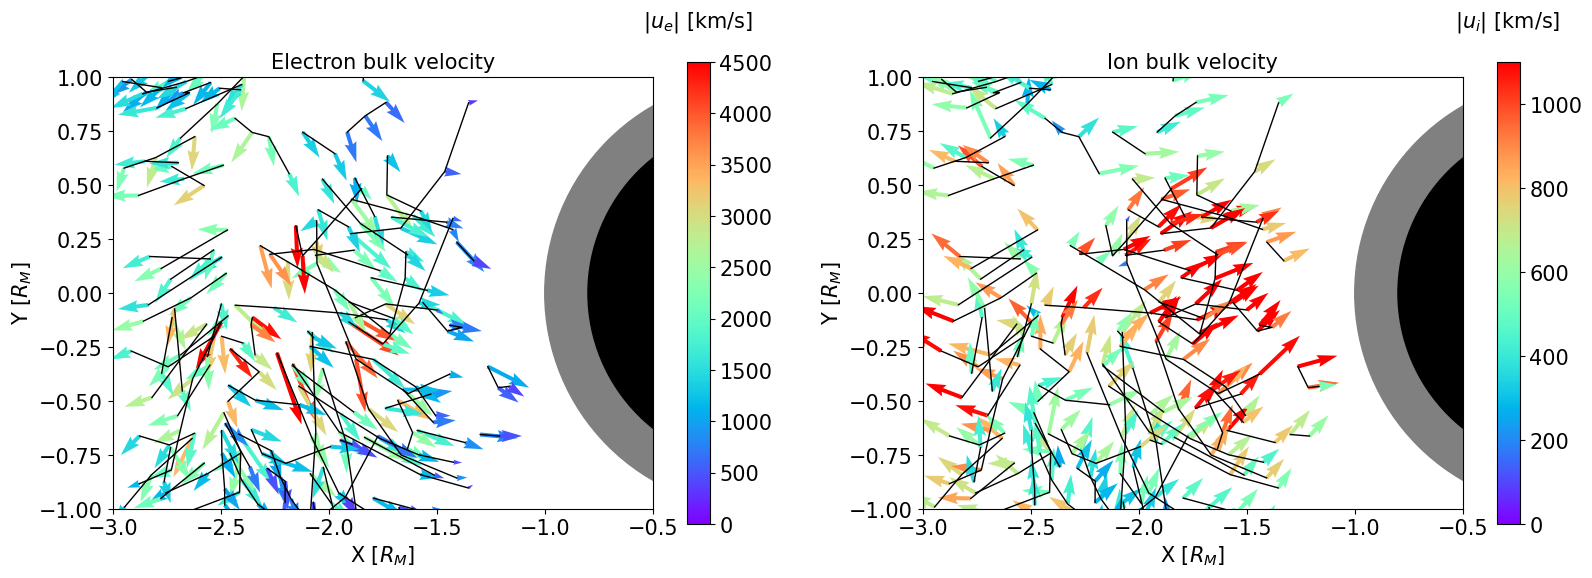

In [12]:
# PLOT TOTAL DF data

def average_elements(input_list, a):
    # Calculate the number of groups
    num_groups = len(input_list) // a 
    
    # Create the result list
    averaged_list = []
    
    for i in range(num_groups):
        # Calculate the start and end index of the sublist
        start_index = i * a
        end_index = start_index + a
        # Calculate the average of the sublist
        sublist = input_list[start_index:end_index]
        sublist_avg = sum(sublist) / a
        averaged_list.append(sublist_avg)
    
    return np.array(averaged_list)

fig,ax = plt.subplots(ncols = 2, figsize=(22,6))
avg_param = 10
for key in df_data.keys():
    if len(df_data[key]["time"])>20:
        X = average_elements(df_data[key]["X"],avg_param)
        Y = average_elements(df_data[key]["Y"],avg_param)
        uex = average_elements(df_data[key]["uex"],avg_param)
        uey = average_elements(df_data[key]["uey"],avg_param)
        uix = average_elements(df_data[key]["uix"],avg_param)
        uiy = average_elements(df_data[key]["uiy"],avg_param)
        ax[0].plot(X,Y, color='black', lw = 1)
        #ax[0].scatter(df_data[key]["X"],df_data[key]["Y"],s=1e3*df_data[key]["area"],c="black")#,vmin=0,vmax=1000)
        ax[1].plot(X,Y, color='black', lw = 1)
        #ax[1].scatter(df_data[key]["X"],df_data[key]["Y"],s=1e3*df_data[key]["area"],c="black")#,vmin=0,vmax=1000)
        ue = ax[0].quiver(X,Y,uex,uey,np.sqrt(uex**2+uey**2),cmap='rainbow',clim=[0,4500])
        ui = ax[1].quiver(X,Y,uix,uiy,np.sqrt(uix**2+uiy**2),cmap='rainbow',clim=[0,1100])
        #s = 500*data[key]["area"],

for i in [0,1]:
    inner = plt.Circle((0, 0), 0.8, color='black')
    outer = plt.Circle((0, 0), 1, color='grey')
    ax[i].add_patch(outer)
    ax[i].add_patch(inner)
    ax[i].set_ylim(-1,1)
    ax[i].set_xlim(-3,-0.5)
    ax[i].set_aspect(1) # you may also use am.imshow(..., aspect="auto") to restore the aspect ratio
    ax[i].tick_params(axis='both',labelsize=15)
    ax[i].set_xlabel("X [$R_M$]",fontsize=15)
    ax[i].set_ylabel("Y [$R_M$]",fontsize=15)
ax[0].set_title("Electron bulk velocity",fontsize=15)
ax[1].set_title("Ion bulk velocity",fontsize=15)
fig.subplots_adjust(right=0.8)
cbar1 = fig.colorbar(ue, ax=ax[0])
cbar1.ax.tick_params(labelsize=15)
cbar1.ax.set_title('$|u_e|$ [km/s]\n',fontsize=15)

cbar2 = fig.colorbar(ui, ax=ax[1])
cbar2.ax.tick_params(labelsize=15)
cbar2.ax.set_title('$|u_i|$ [km/s]\n',fontsize=15)

fig.savefig(str(dir[:-1]+"_plots/"+'DF_ion_electron_velocity.png'),bbox_inches='tight',dpi = 300)

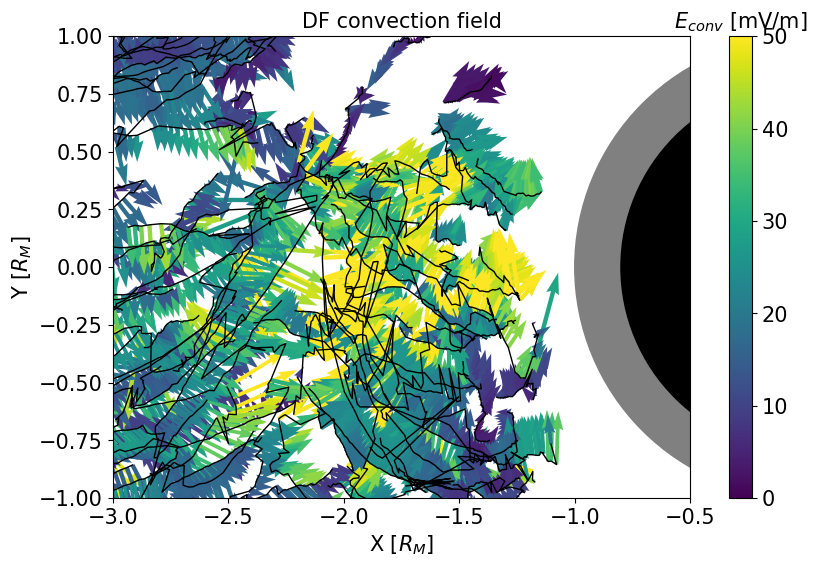

In [8]:
# PLOT TOTAL DF data

fig,ax = plt.subplots(ncols = 1, figsize=(10,6))
for key in df_data.keys():
    if len(df_data[key]["time"])>20:
        ax.plot(df_data[key]["X"],df_data[key]["Y"], color='black', lw = 1)
        E_conv = ax.quiver(df_data[key]["X"],df_data[key]["Y"],df_data[key]["E_convx"],df_data[key]["E_convy"],
                           np.sqrt(df_data[key]["E_convx"]**2+df_data[key]["E_convy"]**2)*1e3,
                       cmap='viridis',clim=[0,50])
        #s = 500*data[key]["area"],

inner = plt.Circle((0, 0), 0.8, color='black')
outer = plt.Circle((0, 0), 1, color='grey')
ax.add_patch(outer)
ax.add_patch(inner)
ax.set_ylim(-1,1)
ax.set_xlim(-3,-0.5)
ax.set_aspect(1) # you may also use am.imshow(..., aspect="auto") to restore the aspect ratio
ax.tick_params(axis='both',labelsize=15)
ax.set_xlabel("X [$R_M$]",fontsize=15)
ax.set_ylabel("Y [$R_M$]",fontsize=15)
ax.set_title("DF convection field",fontsize=15)
cbar1 = fig.colorbar(E_conv, ax=ax)
cbar1.ax.tick_params(labelsize=15)
cbar1.ax.set_title('$E_{conv}$ [mV/m]',fontsize=15)

fig.savefig(str(dir[:-1]+"_plots/"+'DF_convection_field.png'),bbox_inches='tight',dpi = 300)

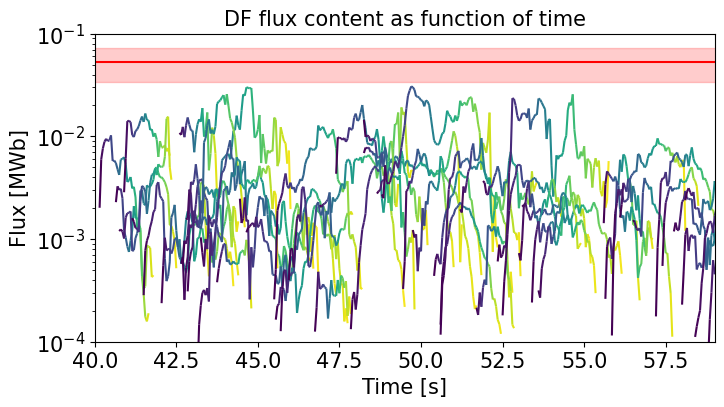

In [18]:
fig,ax = plt.subplots(figsize=(8,4))
for key in df_data.keys():
    if len(df_data[key]["time"])>20:
        #ax.plot(df_data[key]["time"],df_data[key]["Bz"]*df_data[key]["area"]*R_M**2*1e-9/1e6,c="black")
        #plot = ax.scatter(df_data[key]["time"],df_data[key]["Bz"]*df_data[key]["area"]*R_M**2*1e-9/1e6,c=(df_data[key]["time"]-df_data[key]["time"][0]))
        x = df_data[key]["time"]
        y = df_data[key]["Bz"]*df_data[key]["area"]*R_M**2*1e-9/1e6
        z = (df_data[key]["time"]-df_data[key]["time"][0])
        # Create a set of line segments so that each segment is colored separately
        points = np.array([x, y]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)

        # Create a LineCollection from the segments
        cmap = plt.get_cmap('viridis')  # You can choose any colormap you like
        norm = plt.Normalize(z.min(), z.max())
        lc = LineCollection(segments, cmap=cmap, norm=norm)
        
        # Set the values used for colormapping
        lc.set_array(z)
        
        ax.add_collection(lc)

ax.set_title("DF flux content as function of time",fontsize=15)
ax.set_xlabel("Time [s]",fontsize=15)
ax.set_ylabel("Flux [MWb]",fontsize=15)
ax.fill_between([-100,100], [0.034,0.034],[0.072,0.072],alpha = 0.2,color = "red")
ax.plot([-100,100],[0.053,0.053],color='red',label='Dewey et al. (2020)')
#ax.fill_between([-100,100], [0.002,0.002],[0.011,0.011],alpha = 0.2,color = "blue")
#ax.plot([-100,100],[0.002,0.002],color='blue',label='DiBraccio et al. (2015)')
ax.set_yscale("log")
ax.tick_params(axis='both',labelsize=15)
ax.set_xlim(40,59)
ax.set_ylim(1e-4,0.1)

fig.savefig(str(dir[:-1]+"_plots/"+'DF_flux_content.png'),bbox_inches='tight',dpi = 300)
#ax.set_xscale("log")
#ax.set_yscale("log")

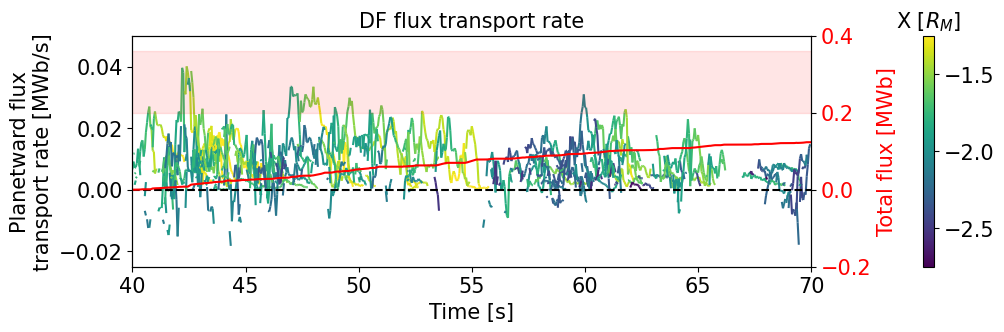

In [75]:
#Plot the radial flux transport rate as E_conv \cdot -rho_hat

fig,ax = plt.subplots(figsize=(12,3))

# Declare arrays to save total flux accumulated
t_bound = [40,70]
times = np.linspace(t_bound[0],t_bound[1],int((t_bound[1]-t_bound[0])/dt)+1)
total_flux = np.zeros_like(times)

ax2 = ax.twinx()
ax2.fill_between([-100,100], [0.2,0.2],[0.36,0.36],alpha = 0.1,color = "red")

for key in df_data.keys():
    if len(df_data[key]["time"])>0 and df_data[key]["X"].iloc[-1] > df_data[key]["X"].iloc[0]:
        closed_mask = df_data[key]["frac_closed"]<0.5
        x = np.ma.masked_where(closed_mask,df_data[key]["time"].to_numpy()) # horizontal axis data
        rho = np.sqrt(df_data[key]["X"]**2+df_data[key]["Y"]**2) # Axial distance
        #E_convrho = (-df_data[key]["E_convx"] * df_data[key]["X"] - df_data[key]["E_convy"] * df_data[key]["Y"])/rho # Convective efield dotted into axial direction
        #E_convrho = np.sqrt(df_data[key]["E_convx"]**2 + df_data[key]["E_convy"]**2)  # Convective efield dotted into axial direction
        width = 2*np.sqrt(df_data[key]["area"]*R_M**2/np.pi) # Assuming DF is circle, find diameter
        y = np.ma.masked_where(closed_mask,(width*df_data[key]["E_convy"]/1e6).to_numpy()) # Flux transport rate in MWb / sec 
        z = np.ma.masked_where(closed_mask,(df_data[key]["X"]).to_numpy()) #df_data[key]['frac_closed']-df_data[key]['frac_open']#rho\
        
        # Create a set of line segments so that each segment is colored separately
        points = np.array([x, y]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)

        # Create a LineCollection from the segments
        cmap = plt.get_cmap('viridis')  # You can choose any colormap you like
        norm = plt.Normalize(-2.75,-1.25)
        lc = LineCollection(segments, cmap=cmap, norm=norm)
        
        # Set the values used for colormapping
        lc.set_array(z)
        # Show the lines
        ax.add_collection(lc)

        # Save flux to runnning total
        flux_rate_masked_array = (width*df_data[key]["E_convy"]/1e6).to_numpy()
        flux_rate_masked_array[closed_mask] = 0
        start_i = np.where(np.abs(times-df_data[key]["time"][0])<0.01)[0].item()
        for j in range(len(x)):
            total_flux[start_i+j+1] = total_flux[start_i+j] + dt*flux_rate_masked_array[j]
        for k in range(start_i+j+1,len(times)-1):
            total_flux[k+1] = total_flux[k]



ax.set_title("DF flux transport rate",fontsize=15)
ax.axhline(y=0,c='black',linestyle='dashed')
ax2.plot(times,total_flux,color='red')
#ax.set_yscale("log")
ax.tick_params(axis='both',labelsize=15)
ax2.tick_params(axis='both',labelsize=15)
ax.set_xlim(t_bound)#t_bound[1])
ax.set_ylim(-0.025,0.05)
ax.xaxis.label.set_color('black')
ax.tick_params(axis ='y', labelcolor = "black",labelsize=15) 
ax2.set_ylim(-0.2,0.4)
cbar = plt.colorbar(lc, ax=ax,shrink=1, pad=0.12)
cbar.ax.tick_params(labelsize=15)
#cbar.set_ticks([-1, 1])
#cbar.set_ticklabels(['External','Closed'],rotation='vertical')
#cbar.ax.get_yticklabels()[0].set_va('bottom')
#cbar.ax.get_yticklabels()[1].set_va('top')
cbar.ax.set_title('X [$R_M$]',fontsize=15)

ax.set_xlabel("Time [s]",fontsize=15,color='black')
ax.set_ylabel("Planetward flux\ntransport rate [MWb/s]",fontsize=15,color="black")
ax2.set_ylabel("Total flux [MWb]",fontsize=15,color="red")
ax2.xaxis.label.set_color('red')
ax2.tick_params(axis ='y', labelcolor = "red",labelsize=15) 


fig.savefig(str(dir[:-1]+"_plots/"+'DF_flux_transport_rate.png'),bbox_inches='tight',dpi = 500)
#ax.set_xscale("log")
#ax.set_yscale("log")

In [68]:
y[j]

masked

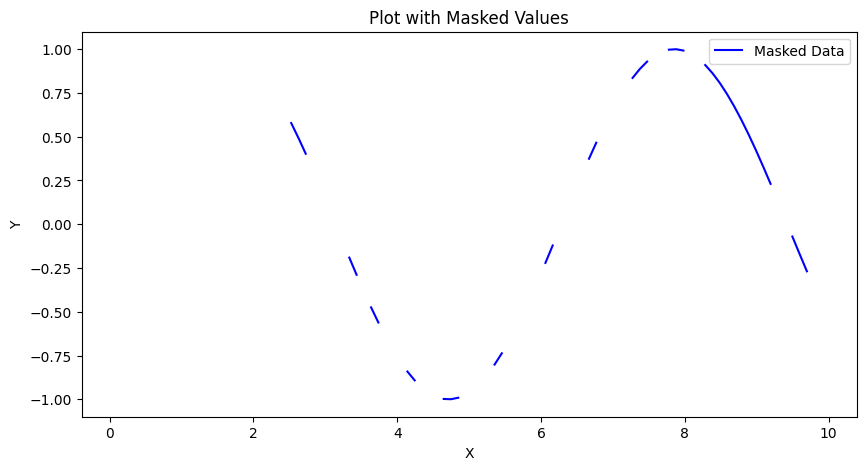

In [51]:
import numpy as np
import matplotlib.pyplot as plt

# Example data
x = np.linspace(0, 10, 100)
y = np.sin(x)
z = np.random.random(100)  # Random values for z

# Define your threshold
threshold = 0.5

# Mask the data where z is below the threshold
# np.ma.masked_where creates a masked array where the condition is True
y_masked = np.ma.masked_where(z < threshold, y)

# Plot the data
plt.figure(figsize=(10, 5))
plt.plot(x, y_masked, 'b-', label='Masked Data')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Plot with Masked Values')
plt.legend()
plt.show()

In [37]:
total_flux[start_i+j+1]

0.0

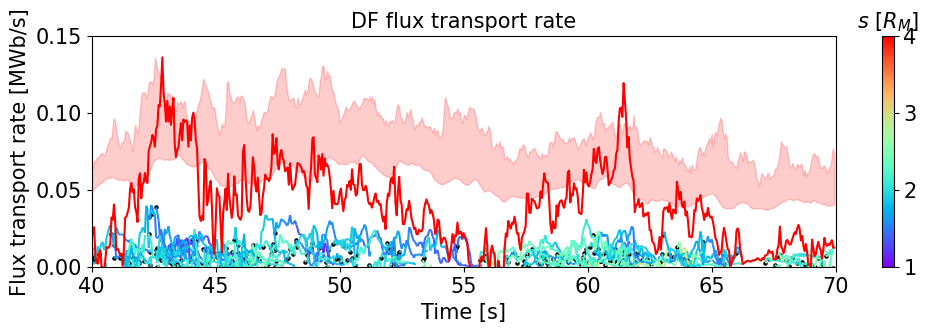

In [8]:
# Read in data

with open(dir+"cross_tail_data", 'rb') as f:
        cross_tail_data = pickle.load(f)

with open(dir+"df_data", 'rb') as f:
        df_data = pickle.load(f)

#Plot the radial flux transport rate as E_conv \cdot -rho_hat

fig,ax = plt.subplots(figsize=(12,3))

# Declare arrays to save total flux transport rate
t_start = 40
t_stop = 70.0
delta_t = 0.05
time_axis = np.linspace(t_start,t_stop-delta_t,int((t_stop-t_start)/delta_t))
total_flux_transport = np.zeros_like(time_axis)

for key in df_data.keys():
    if len(df_data[key]["time"])>0 and df_data[key]["X"].iloc[-1]>df_data[key]["X"].iloc[0]:
        x = df_data[key]["time"] # horizontal axis data
        rho = np.sqrt(df_data[key]["X"]**2+df_data[key]["Y"]**2) # Axial distance
        #E_convrho = (-df_data[key]["E_convx"] * df_data[key]["X"] - df_data[key]["E_convy"] * df_data[key]["Y"])/rho # Convective efield dotted into axial direction
        E_convrho = np.sqrt(df_data[key]["E_convx"]**2 + df_data[key]["E_convy"]**2)  # Convective efield dotted into axial direction
        width = 2*np.sqrt(df_data[key]["area"]*R_M**2/np.pi) # Assuming DF is circle, find diameter
        y = width * df_data[key]["E_convy"]/1e6 # Flux transport rate in MWb / sec 
        #z = (df_data[key]["time"]-df_data[key]["time"][0])
        z = rho
        # Create a set of line segments so that each segment is colored separately
        points = np.array([x, y]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)

        # Create a LineCollection from the segments
        cmap = plt.get_cmap('rainbow')  # You can choose any colormap you like
        norm = plt.Normalize(1, 4)
        lc = LineCollection(segments, cmap=cmap, norm=norm)
        
        # Set the values used for colormapping
        lc.set_array(z)

        # Show line segments
        ax.add_collection(lc)

        # Show DF start point
        ax.scatter(x[0],y[0],c='black',s=5)
        
        # Iterate thr ough each timestep for this DF, and add its flux transport rate contribution to the DF total
        for i in range(len(y)):
            it = int(round((x[i]-t_start)/delta_t,0)) # Work out which index in time_axis we are at
            #print("Time:",x[i],"Index:",it,"Time at index:",time_axis[it])
            total_flux_transport[it] += y[i] 
            

#ax.fill_between(cross_tail_data['time'],cross_tail_data['Phi_dot_mean'],cross_tail_data['Phi_dot_max'],color='red',alpha=0.2)
ax.fill_between(cross_tail_data['time'],cross_tail_data['Phi_e_dot_mean'],cross_tail_data['Phi_e_dot_max'],color='red',alpha=0.2)

ax.set_title("DF flux transport rate",fontsize=15)
#ax.set_yscale("log")
ax.tick_params(axis='both',labelsize=15)
ax.set_xlim(t_start,t_stop)
#ax.set_xlim(52,150)
ax.set_ylim(0,0.15)
cbar = plt.colorbar(lc, ax=ax)
cbar.ax.tick_params(labelsize=15)
cbar.ax.set_title('$s$ [$R_M$]',fontsize=15)

# Plot DF total flux transport rate
ax.plot(time_axis, total_flux_transport,color='red')

ax.set_xlabel("Time [s]",fontsize=15)
ax.set_ylabel("Flux transport rate [MWb/s]",fontsize=15)

fig.savefig(str(dir[:-1]+"_plots/"+'DF_flux_transport_rate_comparison.png'),bbox_inches='tight',dpi = 300)
#ax.set_xscale("log")
#ax.set_yscale("log")

In [87]:
cross_tail_data.keys()

dict_keys(['time', 'X', 'Phi_dot_mean', 'Phi_dot_max', 'Phi_e_dot_mean', 'Phi_e_dot_max'])

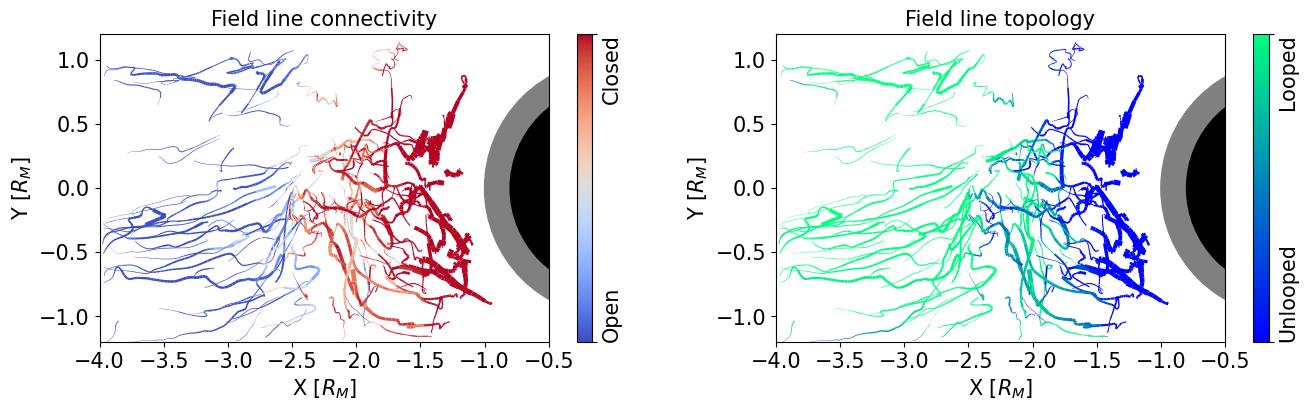

In [238]:
# Plot trajectory with color representing field line type

# Read in data

with open(dir+"cross_tail_data", 'rb') as f:
        cross_tail_data = pickle.load(f)

with open(dir+"df_data3", 'rb') as f:
        df_data = pickle.load(f)

#Plot the radial flux transport rate as E_conv \cdot -rho_hat

fig,ax = plt.subplots(ncols=2,figsize=(16,4))

# Declare arrays to save total flux accumulated

for key in df_data.keys():
    if len(df_data[key]["time"])>10:
        sigma=1 #Smoothing scale
        x = gaussian_filter1d(df_data[key]["X"], sigma=sigma) # horizontal axis data
        y = gaussian_filter1d(df_data[key]["Y"], sigma=sigma) # horizontal axis data
        z1 = df_data[key]["frac_closed"]-df_data[key]["frac_external"]
        z2 = df_data[key]["frac_ropey"]
        a = (df_data[key]["Bz"]*df_data[key]['area'])**0.6*2
        #a = df_data[key]["wake_Jy"]
        # Create a set of line segments so that each segment is colored separately
        points = np.array([x, y]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)

        # Create a LineCollection for the connectivity segments
        cmap = plt.get_cmap('coolwarm') 
        norm = plt.Normalize(-1, 1)
        lc1 = LineCollection(segments, cmap=cmap, norm=norm)
        
        # Create a LineCollection for the topology segments
        #cmap = Colormap('PRGn_10_r') .to_mpl()
        cmap = plt.get_cmap('winter') 
        norm = plt.Normalize(0, 1)
        lc2 = LineCollection(segments, cmap=cmap, norm=norm)
        
        # Set the values used for colormapping
        lc1.set_array(z1)
        lc2.set_array(z2)

        # Set the widths
        lc1.set_linewidths(np.array(a))
        lc2.set_linewidths(np.array(a))

        # Show line segments
        ax[0].add_collection(lc1)
        ax[1].add_collection(lc2)

        # Show DF start point
        #ax.scatter(x[0],y[0],c='black',s=3)

for axi in ax:
    inner = plt.Circle((0, 0), 0.8, color='black')
    outer = plt.Circle((0, 0), 1, color='grey')
    axi.add_patch(outer)
    axi.add_patch(inner)
    axi.tick_params(axis='both',labelsize=15)
    axi.set_xlim(-4,-0.5)
    axi.set_ylim(-1.2,1.2)
    axi.set_aspect(1)
    axi.set_xlabel("X [$R_M$]",fontsize=15)
    axi.set_ylabel("Y [$R_M$]",fontsize=15)

ax[0].set_title("Field line connectivity",fontsize=15)
ax[1].set_title("Field line topology",fontsize=15)

cbar1 = plt.colorbar(lc1, ax=ax[0])
cbar1.ax.tick_params(labelsize=15)
cbar1.set_ticks([-1, 1])
cbar1.set_ticklabels(['Open', 'Closed'],rotation='vertical')
cbar1.ax.get_yticklabels()[0].set_va('bottom')
cbar1.ax.get_yticklabels()[1].set_va('top')

cbar2 = plt.colorbar(lc2, ax=ax[1])
cbar2.ax.tick_params(labelsize=15)
cbar2.set_ticks([0,1])
cbar2.set_ticklabels(['Unlooped','Looped'],rotation='vertical')
cbar2.ax.get_yticklabels()[0].set_va('bottom')
cbar2.ax.get_yticklabels()[1].set_va('top')



fig.savefig(str(dir[:-1]+"_plots/"+'DF_connectivity.png'),bbox_inches='tight',dpi = 300)
#ax.set_xscale("log")
#ax.set_yscale("log")

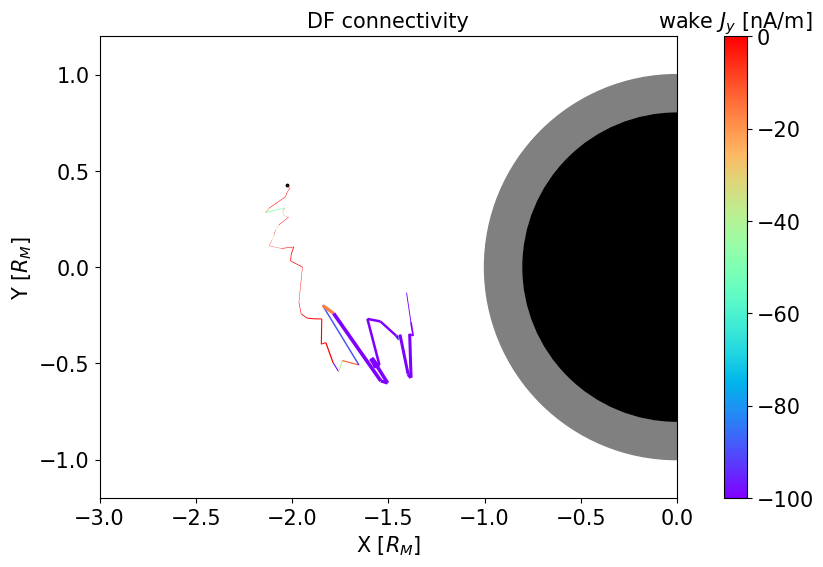

In [222]:
# Plot trajectory with color representing field line type

# Read in data

with open(dir+"cross_tail_data", 'rb') as f:
        cross_tail_data = pickle.load(f)

with open(dir+"df_data3", 'rb') as f:
        df_data = pickle.load(f)

#Plot the radial flux transport rate as E_conv \cdot -rho_hat

fig,ax = plt.subplots(figsize=(12,6))

# Declare arrays to save total flux accumulated

for key in df_data.keys():
    if len(df_data[key]["time"])>40:
        x = df_data[key]["X"] # horizontal axis data
        y = df_data[key]["Y"] # horizontal axis data
        z = df_data[key]["wake_Jy"]*1e6
        a = df_data[key]["Bz"]*df_data[key]['area']
        #a = df_data[key]["wake_Jy"]
        # Create a set of line segments so that each segment is colored separately
        points = np.array([x, y]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)

        # Create a LineCollection from the segments
        cmap = plt.get_cmap('rainbow')  # You can choose any colormap you like
        norm = plt.Normalize(-100, 0)
        lc = LineCollection(segments, cmap=cmap, norm=norm)
        
        # Set the values used for colormapping
        lc.set_array(z)

        # Set the widths
        lc.set_linewidths(np.array(a))

        # Show line segments
        ax.add_collection(lc)

        # Show DF start point
        ax.scatter(x[0],y[0],c='black',s=3)

inner = plt.Circle((0, 0), 0.8, color='black')
outer = plt.Circle((0, 0), 1, color='grey')
ax.add_patch(outer)
ax.add_patch(inner)

ax.set_title("DF connectivity",fontsize=15)
#ax.set_yscale("log")
ax.tick_params(axis='both',labelsize=15)
ax.set_xlim(-3,0)
ax.set_ylim(-1.2,1.2)
cbar = plt.colorbar(lc, ax=ax)
cbar.ax.tick_params(labelsize=15)
cbar.ax.set_title('wake $J_y$ [nA/m]',fontsize=15)
ax.set_aspect(1)
ax.set_xlabel("X [$R_M$]",fontsize=15)
ax.set_ylabel("Y [$R_M$]",fontsize=15)

fig.savefig(str(dir[:-1]+"_plots/"+'DF_wake_Jy.png'),bbox_inches='tight',dpi = 300)
#ax.set_xscale("log")
#ax.set_yscale("log")

Text(0.5, 1.0, 'DF age [s]')

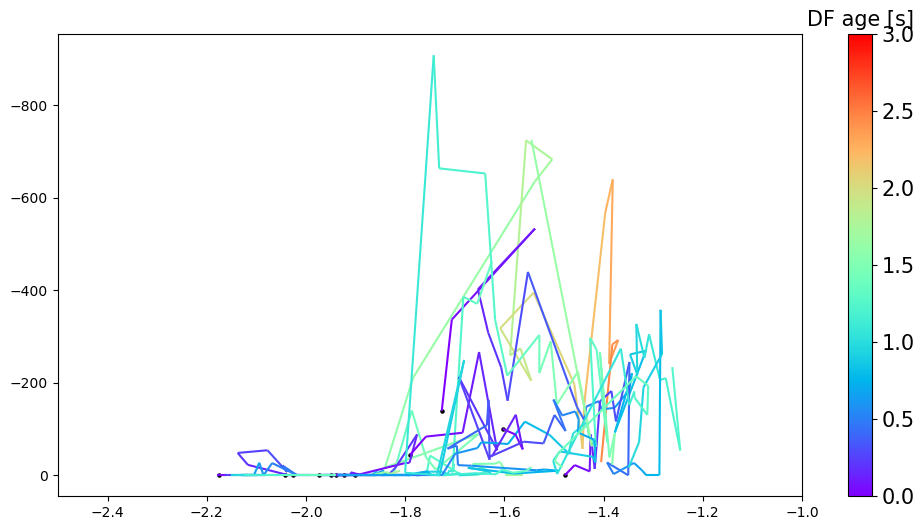

In [235]:
fig,ax = plt.subplots(figsize=(12,6))

# Declare arrays to save total flux accumulated

for key in df_data.keys():
    if len(df_data[key]["time"])>20 and df_data[key]["X"].iloc[-1] > -2:
        x = df_data[key]["X"]
        #x = np.sqrt(df_data[key]["X"]**2+df_data[key]["Y"]**2+df_data[key]["Z"]**2)
        #y = np.sqrt(df_data[key]["X"]**2+df_data[key]["Y"]**2+df_data[key]["Z"]**2)
        y = df_data[key]["wake_Jy"]*1e6 # Convert to uA/m*R_M
        #z = df_data[key]["frac_closed"]/(df_data[key]["frac_closed"]+df_data[key]["frac_ropey"])
        z = df_data[key]["time"]-df_data[key]["time"].iloc[0]

        # Create a set of line segments so that each segment is colored separately
        points = np.array([x, y]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)

        # Create a LineCollection from the segments
        cmap = plt.get_cmap('rainbow')  # You can choose any colormap you like
        norm = plt.Normalize(0,3)
        lc = LineCollection(segments, cmap=cmap, norm=norm)
        
        # Set the values used for colormapping
        lc.set_array(z)

        # Show line segments
        ax.add_collection(lc)

        # Show DF start point
        ax.scatter(x[0],y[0],c='black',s=5)
        #plt.gca().invert_xaxis()

ax.set_xlim(-2.5,-1)
plt.gca().invert_yaxis()
cbar = plt.colorbar(lc, ax=ax)
cbar.ax.tick_params(labelsize=15)
cbar.ax.set_title('DF age [s]',fontsize=15)

In [226]:
df_data[key]["X"].iloc[-1]

-2.9958635498495663

In [215]:
df_data[key]['area']*R_M**2

0    3.633789e+10
Name: area, dtype: float64

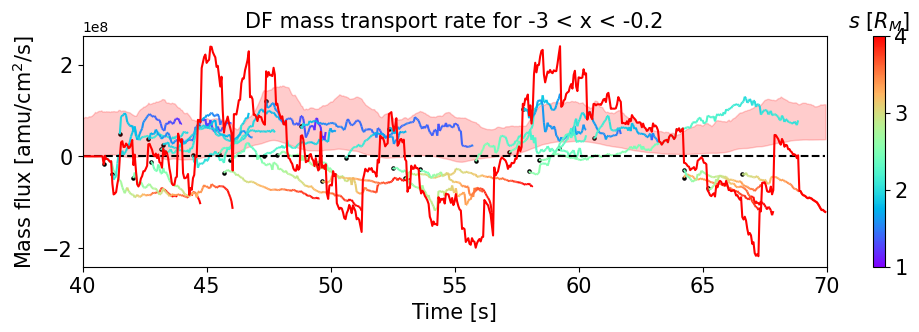

In [106]:
# Read in data

with open(dir+"cross_tail_data", 'rb') as f:
        cross_tail_data = pickle.load(f)

with open(dir+"df_data3", 'rb') as f:
        df_data = pickle.load(f)

#Plot the planetward mass flux rate

fig,ax = plt.subplots(figsize=(12,3))

# Declare arrays to save total flux transport rate
t_start = 40
t_stop = 70.0
delta_t = 0.05
time_axis = np.linspace(t_start,t_stop-delta_t,int((t_stop-t_start)/delta_t))
total_flux_transport = np.zeros_like(time_axis)

for key in df_data.keys():
    if len(df_data[key]["time"])>40:
        x = df_data[key]["time"] # horizontal axis data
        rho = np.sqrt(df_data[key]["X"]**2+df_data[key]["Y"]**2) # Axial distance
        #E_convrho = (-df_data[key]["E_convx"] * df_data[key]["X"] - df_data[key]["E_convy"] * df_data[key]["Y"])/rho # Convective efield dotted into axial direction
        y = df_data[key]["n"] * df_data[key]["uix"]*1e5*1e-6  # Mass flux, in amu/cc^2/s
        #z = (df_data[key]["time"]-df_data[key]["time"][0])
        z = rho
        # Create a set of line segments so that each segment is colored separately
        points = np.array([x, y]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)

        # Create a LineCollection from the segments
        cmap = plt.get_cmap('rainbow')  # You can choose any colormap you like
        norm = plt.Normalize(1, 4)
        lc = LineCollection(segments, cmap=cmap, norm=norm)
        
        # Set the values used for colormapping
        lc.set_array(z)

        # Show line segments
        ax.add_collection(lc)

        # Show DF start point
        ax.scatter(x[0],y[0],c='black',s=5)
        
        # Iterate through each timestep for this DF, and add its flux transport rate contribution to the DF total
        for i in range(len(y)):
            it = int(round((x[i]-t_start)/delta_t,0)) # Work out which index in time_axis we are at
            #print("Time:",x[i],"Index:",it,"Time at index:",time_axis[it])
            total_flux_transport[it] += y[i] 
            

ax.fill_between(cross_tail_data['time'],np.array(cross_tail_data['mass_transport_mean'])/m_p/1e6,np.array(cross_tail_data['mass_transport_max'])/m_p/1e6,color='red',alpha=0.2)
#ax.plot(cross_tail_data['time'],np.array(cross_tail_data['mass_transport'])/m_p/1e6,color='red',lw=5,alpha=0.2)
ax.plot([cross_tail_data['time'][0],cross_tail_data['time'][-1]],[0,0],c='black',linestyle='dashed')

ax.set_title(str("DF mass transport rate for "+str(round(xlims[0],1))+" < x < "+str(round(xlims[1],1))),fontsize=15)
#ax.set_yscale("log")
ax.tick_params(axis='both',labelsize=15)
ax.set_xlim(t_start,t_stop)
#ax.set_xlim(52,150)
#ax.set_ylim(0.,0.15)
cbar = plt.colorbar(lc, ax=ax)
cbar.ax.tick_params(labelsize=15)
cbar.ax.set_title('$s$ [$R_M$]',fontsize=15)

# Plot DF total flux transport rate
ax.plot(time_axis, total_flux_transport,color='red')

ax.set_xlabel("Time [s]",fontsize=15)
ax.set_ylabel("Mass flux [amu/cm$^2$/s]",fontsize=15)

fig.savefig(str(dir[:-1]+"_plots/"+'DF_mass_transport_rate.png'),bbox_inches='tight',dpi = 300)
#ax.set_xscale("log")
#ax.set_yscale("log")

In [177]:
cross_tail_data['X']

[-1.38281,
 -1.38281,
 -1.38281,
 -1.38281,
 -1.38281,
 -1.38281,
 -1.38281,
 -1.38281,
 -1.38281,
 -1.38281,
 -1.38281,
 -1.38281,
 -1.38281,
 -1.38281,
 -1.38281,
 -1.38281,
 -1.38281,
 -1.38281,
 -1.38281,
 -1.38281,
 -1.38281,
 -1.38281,
 -1.38281,
 -1.38281,
 -1.38281,
 -1.38281,
 -1.38281,
 -1.38281,
 -1.38281,
 -1.38281,
 -1.38281,
 -1.38281,
 -1.38281,
 -1.38281,
 -1.38281,
 -1.38281,
 -1.38281,
 -1.38281,
 -1.38281,
 -1.38281,
 -1.38281,
 -1.38281,
 -1.38281,
 -1.38281,
 -1.38281,
 -1.38281,
 -1.38281,
 -1.38281,
 -1.38281,
 -1.38281,
 -1.38281,
 -1.38281,
 -1.38281,
 -1.38281,
 -1.38281,
 -1.38281,
 -1.38281,
 -1.38281,
 -1.38281,
 -1.38281,
 -1.38281,
 -1.38281,
 -1.38281,
 -1.38281,
 -1.38281,
 -1.38281,
 -1.38281,
 -1.38281,
 -1.38281,
 -1.38281,
 -1.38281,
 -1.38281,
 -1.38281,
 -1.38281,
 -1.38281,
 -1.38281,
 -1.38281,
 -1.38281,
 -1.38281,
 -1.38281,
 -1.38281,
 -1.38281,
 -1.38281,
 -1.38281,
 -1.38281,
 -1.38281,
 -1.38281,
 -1.38281,
 -1.38281,
 -1.38281,
 -1.38281,

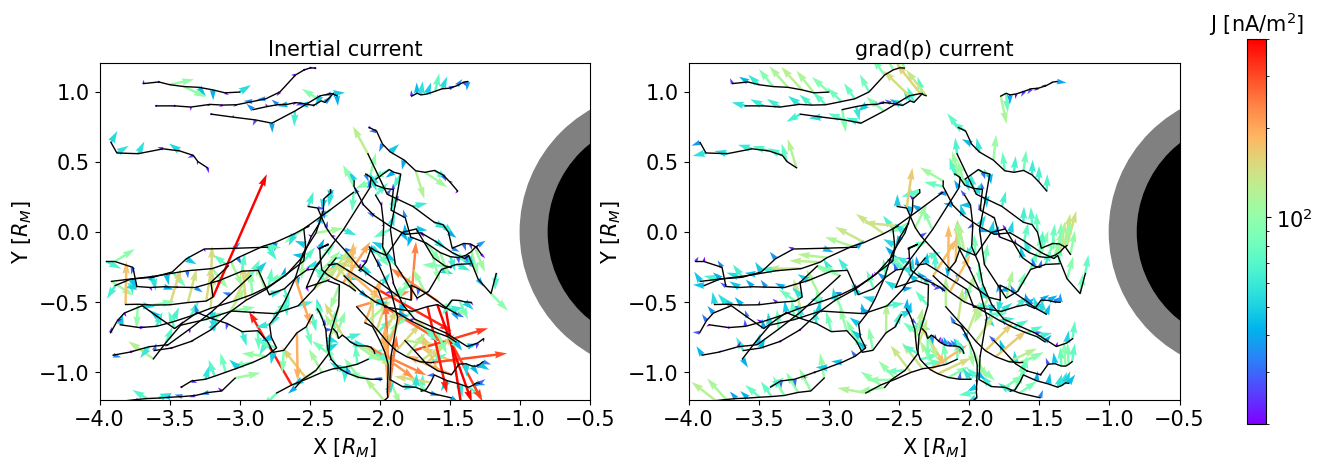

In [10]:
# PLOT TOTAL DF data
avg_param=5
fig,ax = plt.subplots(ncols = 2, figsize=(20,5))
for key in df_data.keys():
    if len(df_data[key]["time"])>40:
        X = average_elements(df_data[key]["X"],avg_param)
        Y = average_elements(df_data[key]["Y"],avg_param)
        area = average_elements(df_data[key]["area"],avg_param)
        J_inrtx = average_elements(df_data[key]["J_inrt,x"],avg_param)
        J_inrty = average_elements(df_data[key]["J_inrt,y"],avg_param)
        J_gradpy = average_elements(df_data[key]["J_gradp,y"],avg_param)
        J_gradpx = average_elements(df_data[key]["J_gradp,x"],avg_param)
        ax[0].plot(X,Y, color='black', lw = 1)
        ax[1].plot(X,Y, color='black', lw = 1)
        J_inrt = ax[0].quiver(X,Y,J_inrtx,J_inrty, np.sqrt(J_inrtx**2+J_inrty**2)*1e9,scale = 2e-6,width=5e-3,cmap='rainbow',clim=[20,400],norm=LogNorm())
        J_gradp = ax[1].quiver(X,Y,J_gradpx,J_gradpy,np.sqrt(J_gradpx**2+J_gradpy**2)*1e9,scale = 2e-6,width=5e-3,cmap='rainbow',clim=[20,400],norm=LogNorm())
        #s = 500*data[key]["area"],

for i in [0,1]:
    inner = plt.Circle((0, 0), 0.8, color='black')
    outer = plt.Circle((0, 0), 1, color='grey')
    ax[i].add_patch(outer)
    ax[i].add_patch(inner)
    ax[i].set_ylim(-1.2,1.2)
    ax[i].set_xlim(-4,-0.5)
    ax[i].set_aspect(1) # you may also use am.imshow(..., aspect="auto") to restore the aspect ratio
    ax[i].tick_params(axis='both',labelsize=15)
    ax[i].set_xlabel("X [$R_M$]",fontsize=15)
    ax[i].set_ylabel("Y [$R_M$]",fontsize=15)
ax[0].set_title("Inertial current",fontsize=15)
ax[1].set_title("grad(p) current",fontsize=15)
fig.subplots_adjust(right=0.8)
cbar1 = fig.colorbar(J_inrt, ax=ax[:], norm=LogNorm())
cbar1.ax.tick_params(labelsize=15)
cbar1.ax.set_title('J [nA/m$^2$]',fontsize=15)

fig.savefig(str(dir[:-1]+"_plots/"+'DF_currents.png'),bbox_inches='tight',dpi = 300)

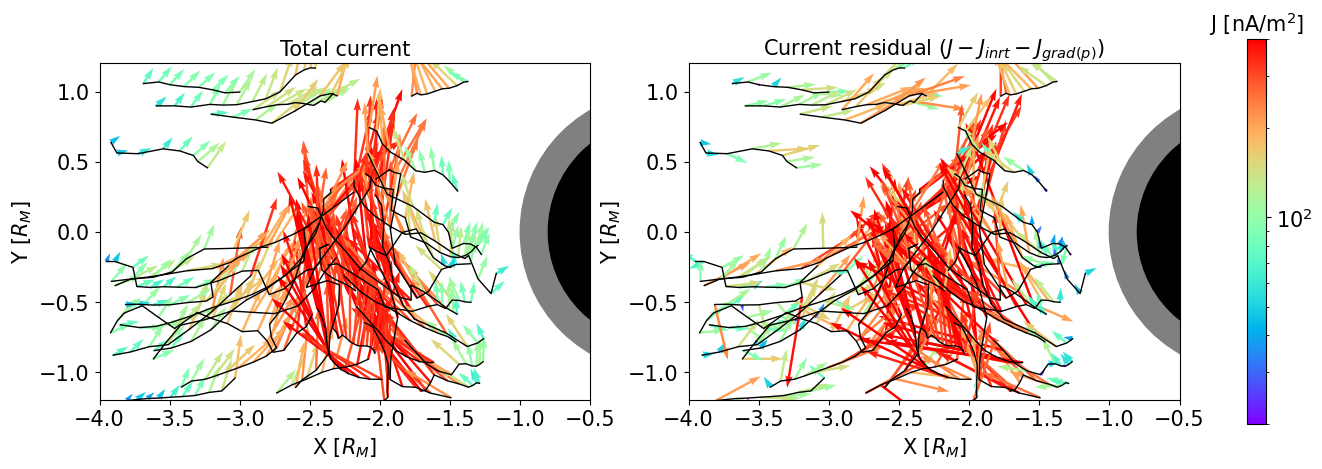

In [11]:
# PLOT current residual
avg_param=5
fig,ax = plt.subplots(ncols = 2, figsize=(20,5))
for key in df_data.keys():
    if len(df_data[key]["time"])>40:
        X = average_elements(df_data[key]["X"],avg_param)
        Y = average_elements(df_data[key]["Y"],avg_param)
        area = average_elements(df_data[key]["area"],avg_param)
        J_inrtx = average_elements(df_data[key]["J_inrt,x"],avg_param)
        J_inrty = average_elements(df_data[key]["J_inrt,y"],avg_param)
        J_gradpx = average_elements(df_data[key]["J_gradp,x"],avg_param)
        J_gradpy = average_elements(df_data[key]["J_gradp,y"],avg_param)
        Jx = average_elements(df_data[key]["Jx"],avg_param)
        Jy = average_elements(df_data[key]["Jy"],avg_param)
        J_residx = Jx - J_inrtx - J_gradpx
        J_residy = Jy - J_inrty - J_gradpy
        ax[0].plot(X,Y, color='black', lw = 1)
        ax[1].plot(X,Y, color='black', lw = 1)
        J_plot = ax[0].quiver(X,Y,Jx,Jy, np.sqrt(Jx**2+Jy**2)*1e9,scale = 2e-6,width=5e-3,cmap='rainbow',clim=[20,400],norm=LogNorm())
        J_resid = ax[1].quiver(X,Y,J_residx,J_residy, np.sqrt(J_residx**2+J_residy**2)*1e9,scale = 2e-6,width=5e-3,cmap='rainbow',clim=[20,400],norm=LogNorm())

for i in [0,1]:
    inner = plt.Circle((0, 0), 0.8, color='black')
    outer = plt.Circle((0, 0), 1, color='grey')
    ax[i].add_patch(outer)
    ax[i].add_patch(inner)
    ax[i].set_ylim(-1.2,1.2)
    ax[i].set_xlim(-4,-0.5)
    ax[i].set_aspect(1) # you may also use am.imshow(..., aspect="auto") to restore the aspect ratio
    ax[i].tick_params(axis='both',labelsize=15)
    ax[i].set_xlabel("X [$R_M$]",fontsize=15)
    ax[i].set_ylabel("Y [$R_M$]",fontsize=15)
ax[0].set_title("Total current",fontsize=15)    
ax[1].set_title("Current residual ($J-J_{inrt}-J_{grad(p)}$)",fontsize=15)
fig.subplots_adjust(right=0.8)
cbar1 = fig.colorbar(J_resid, ax=ax[:], norm=LogNorm())
cbar1.ax.tick_params(labelsize=15)
cbar1.ax.set_title('J [nA/m$^2$]',fontsize=15)
cbar1.ax.tick_params(labelsize=15)
cbar1.locator = LogLocator()
cbar1.formatter = LogFormatterSciNotation()  

fig.savefig(str(dir[:-1]+"_plots/"+'DF_current_residual.png'),bbox_inches='tight',dpi = 300)

Text(0, 0.5, '$pe/n^{5/3}$')

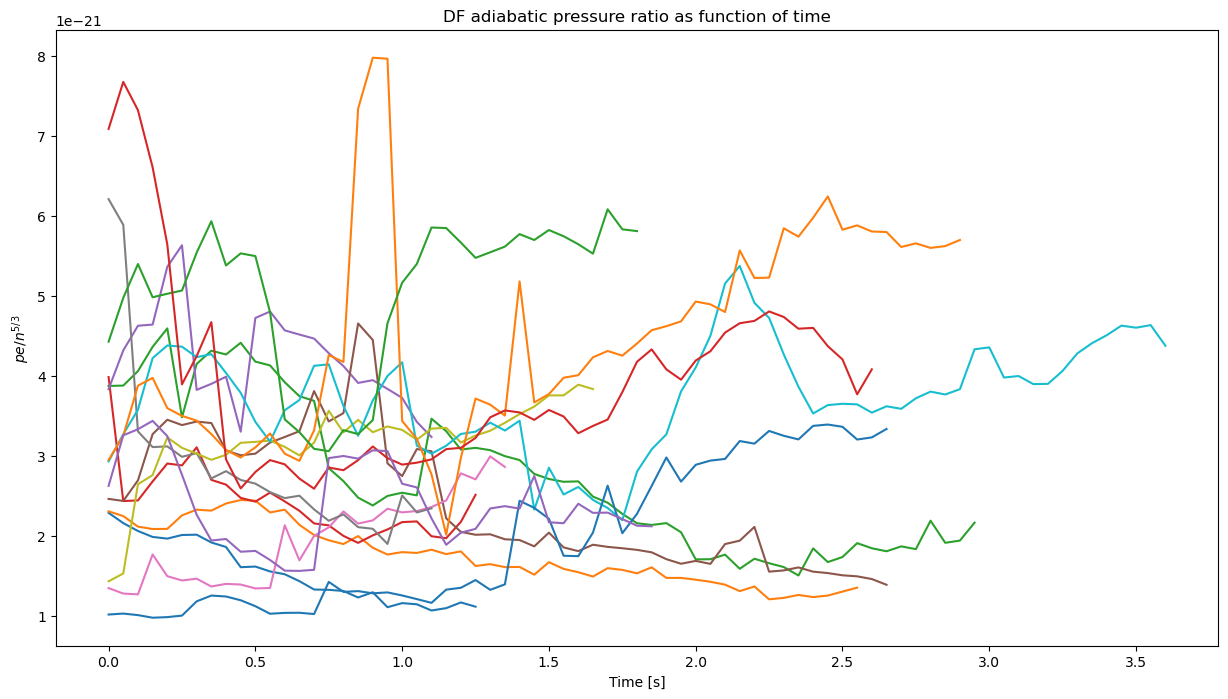

In [73]:
fig,ax = plt.subplots(figsize=(15,8))
for key in df_data.keys():
    if len(df_data[key]["time"])>20:
        plot = ax.plot(df_data[key]["time"]-df_data[key]["time"][0],df_data[key]["pe"]*1e9/(df_data[key]["n"]*1e6)**(5/3))
        #s = 500*data[key]["area"],
ax.set_title("DF adiabatic pressure ratio as function of time")
ax.set_xlabel("Time [s]")
ax.set_ylabel("$pe/n^{5/3}$")
#ax.set_xscale("log")
#ax.set_yscale("log")

In [116]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Step 1: Create example data for X, Y, Z, and Q
X = np.linspace(-5, 5, 100)
Y = np.linspace(-5, 5, 100)
X, Y = np.meshgrid(X, Y)
Z = np.sin(np.sqrt(X**2 + Y**2))
Q = np.cos(np.sqrt((X-2)**2 + Y**2))

# Step 2: Create the figure and 3D axis
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Step 3: Plot the surface with a uniform blue color and smaller grid lines
surf = ax.plot_surface(X, Y, Z, color='lightgrey', edgecolor='none')

# Step 4: Find the contour of Q = 0
contours = plt.contour(X, Y, Q, levels=[0])

# Step 5: Extract the contour lines and project onto the 3D surface
for contour in contours.collections:
    for path in contour.get_paths():
        vertices = path.vertices
        x_coords = vertices[:, 0]
        y_coords = vertices[:, 1]
        # Approximation: calculate the Z values for these points
        z_coords = np.sin(np.sqrt(x_coords**2 + y_coords**2))
        ax.plot(x_coords, y_coords, z_coords, color='black', linewidth=2.5)

fig.show()


Error in callback <function _draw_all_if_interactive at 0x1072bf2e0> (for post_execute), with arguments args (),kwargs {}:


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_10514/16007162.py:23: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for contour in contours.collections:
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_10514/16007162.py:32: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


AttributeError: 'PathCollection' object has no attribute 'do_3d_projection'

AttributeError: 'PathCollection' object has no attribute 'do_3d_projection'

<Figure size 640x480 with 1 Axes>

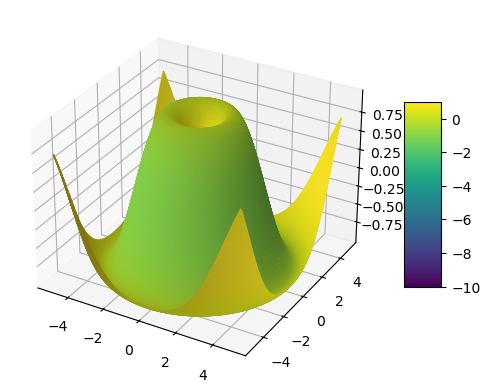

In [139]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

# Step 1: Create example data for X, Y, Z, and Q
X = np.linspace(-5, 5, 100)
Y = np.linspace(-5, 5, 100)
X, Y = np.meshgrid(X, Y)
Z = np.sin(np.sqrt(X**2 + Y**2))

# Q can be any function or data that corresponds to the shape of X and Y
Q = np.cos(np.sqrt(X**2 + Y**2))

# Specify the colormap bounds
Q_min = -10  # you can set this to whatever lower bound you need
Q_max = 1   # you can set this to whatever upper bound you need

# Step 2: Create the figure and 3D axis
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Step 3: Normalize Q to use as color data
norm = plt.Normalize(Q_min, Q_max)
colors = cm.viridis(norm(Q))  # change 'viridis' to any colormap you prefer

# Step 4: Plot the surface with colormap applied from Q
surf = ax.plot_surface(X, Y, Z, facecolors=colors, rstride=1, cstride=1, antialiased=True)

# Add a color bar which maps values from Q to colors for reference
m = cm.ScalarMappable(cmap=cm.viridis, norm=norm)
m.set_array(Q)
fig.colorbar(m, ax=ax, shrink=0.5, aspect=5)

# Display the plot
plt.show()

In [149]:
file

'3d_fluid_region0_0_t00000052_n00007072_amrex_csdata_t_052.00'

In [150]:
dir

'/Users/atcushen/Documents/MercuryModelling/runs/nightside_v4_run3/ta-3/'